In [1]:
import os
import torch
import numpy as  np


from pprint import pprint, pformat
import logging


In [2]:
logging.basicConfig(format='%(levelname)s - %(message)s')
log = logging.getLogger('root')
log.setLevel(logging.INFO)

In [3]:
log.info('vjnsegn')

INFO - vjnsegn


In [4]:
def read_data(filename='names.csv'):
    data = open(filename).readlines()
    samples = []
    for datum in data:
        samples.append(datum.split(',')[1])
        
    return samples

In [5]:
def read_dirs(dirs=['boy', 'girl']):
    samples = []
    for d in dirs:
        for filename in os.listdir('data/tamil-names/{}'.format(d)):
            s = read_data('data/tamil-names/{}/{}'.format(d, filename))
            s = [(d, n) for n in s]
            samples.extend(s)
            
    return list(set(samples))

In [6]:
names = read_dirs()
names = sorted(names, key=lambda x: len(x[1]))
categories = ['PAD', 'boy', 'girl']
letters = set([c for name in names for c in name[1]])
letters = list(letters)
letters.sort()
letters = ['PAD', ' '] + letters[10:] + ['EOS']
letters

['PAD',
 ' ',
 'ஃ',
 'அ',
 'ஆ',
 'இ',
 'ஈ',
 'உ',
 'ஊ',
 'எ',
 'ஏ',
 'ஐ',
 'ஒ',
 'ஓ',
 'க',
 'ங',
 'ச',
 'ஜ',
 'ஞ',
 'ட',
 'ண',
 'த',
 'ந',
 'ன',
 'ப',
 'ம',
 'ய',
 'ர',
 'ற',
 'ல',
 'ள',
 'ழ',
 'வ',
 'ா',
 'ி',
 'ீ',
 'ு',
 'ூ',
 'ெ',
 'ே',
 'ை',
 'ொ',
 'ோ',
 'ௌ',
 '்',
 'EOS']

In [11]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
class Generator(nn.Module):
    def __init__(self, category_size, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.category_size = category_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cat_embedding = nn.Embedding(category_size, hidden_size)
        self.inp_embedding = nn.Embedding(input_size, hidden_size)
        self.blend = nn.Linear(2*hidden_size, hidden_size)
        self.gru = nn.GRUCell(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, output_size)
        
    def forward(self, cat, char, hidden):
        log.debug('cat: {}, char: {}'.format(cat.size(), char.size()))
        cat = self.cat_embedding(cat)
        char = self.inp_embedding(char)
        log.debug('cat: {}, char: {}'.format(cat.size(), char.size()))
        merged = torch.cat([cat, char], cat.dim()-1)
        log.debug('cat: {}, char: {}, merged: {}'.format(cat.size(), char.size(), merged.size()))
        blended = self.blend(merged)
        log.debug('blended: {}'.format(blended.size()))
        log.debug('hidden: {}'.format(hidden.size()))
        hidden = self.gru(blended, hidden)
        log.debug('hidden: {}'.format(hidden.size()))
        return hidden, F.log_softmax(self.project(hidden))
    
    def init_hidden(self, batch_size=1):
        return Variable(torch.zeros(batch_size, self.hidden_size))

In [72]:
gen = Generator(len(categories), len(letters), 8, len(letters))

In [69]:
log.setLevel(logging.DEBUG)

In [70]:
gen(Variable(torch.LongTensor([1,0,1])), 
    Variable(torch.LongTensor([1, 2, 3])), 
    gen.init_hidden(3))

DEBUG - cat: torch.Size([3]), char: torch.Size([3])
DEBUG - cat: torch.Size([3, 8]), char: torch.Size([3, 8])
DEBUG - cat: torch.Size([3, 8]), char: torch.Size([3, 8]), merged: torch.Size([3, 16])
DEBUG - blended: torch.Size([3, 8])
DEBUG - hidden: torch.Size([3, 8])
DEBUG - hidden: torch.Size([3, 8])


(Variable containing:
 -0.0927 -0.2043  0.0010  0.1086 -0.0502 -0.0706 -0.2404  0.1327
 -0.0367 -0.2732  0.1120 -0.1035 -0.3466  0.1929 -0.0985  0.1261
 -0.0190  0.0484  0.0875 -0.0900 -0.0026 -0.0451 -0.2108  0.0217
 [torch.FloatTensor of size 3x8], Variable containing:
 
 Columns 0 to 9 
 -3.6150 -3.5758 -3.4284 -4.0232 -3.6526 -3.7083 -4.0840 -3.7943 -3.9689 -4.1117
 -3.5802 -3.5420 -3.6345 -4.0666 -3.8278 -3.7304 -4.1697 -3.8079 -3.9374 -4.1267
 -3.6048 -3.6166 -3.4596 -4.1027 -3.6407 -3.6440 -4.1117 -3.7479 -3.9385 -4.0866
 
 Columns 10 to 19 
 -3.8431 -3.7125 -4.0621 -3.5184 -4.1999 -3.8779 -4.0687 -4.0884 -3.9604 -3.4436
 -3.6484 -3.6426 -4.0409 -3.3708 -4.0751 -4.0541 -4.0170 -4.1764 -3.9422 -3.3328
 -3.9140 -3.6458 -3.9656 -3.4651 -4.2128 -3.9258 -4.0447 -4.0059 -3.8008 -3.5017
 
 Columns 20 to 29 
 -3.9833 -3.7161 -3.6568 -3.6347 -3.9484 -3.4582 -4.0729 -4.0191 -4.0272 -4.1303
 -4.0523 -3.6792 -3.7138 -3.5710 -3.7409 -3.3993 -4.1752 -4.0671 -4.0216 -4.2050
 -4.0324 -3.7288 -3

In [15]:
letters[30] + letters[-2]

'ள்'

In [16]:
def gen_sample(sample):
    cat, name = sample
    sample = []
    cat = categories.index(cat)
    for char in name:
        cid = letters.index(char)
        sample.append((cat, cid))
    sample.append((cat, len(letters)-1))
    return sample

In [17]:
[gen_sample(name) for name in names[1000:1020]]

[[(1, 10), (1, 28), (1, 14), (1, 23), (1, 44), (1, 45)],
 [(2, 5), (2, 26), (2, 29), (2, 20), (2, 34), (2, 45)],
 [(1, 25), (1, 31), (1, 25), (1, 20), (1, 34), (1, 45)],
 [(2, 21), (2, 20), (2, 34), (2, 14), (2, 40), (2, 45)],
 [(2, 4), (2, 26), (2, 42), (2, 21), (2, 34), (2, 45)],
 [(2, 24), (2, 21), (2, 36), (2, 25), (2, 40), (2, 45)],
 [(2, 21), (2, 14), (2, 32), (2, 20), (2, 34), (2, 45)],
 [(2, 25), (2, 21), (2, 36), (2, 27), (2, 40), (2, 45)],
 [(1, 25), (1, 20), (1, 25), (1, 29), (1, 40), (1, 45)],
 [(2, 22), (2, 33), (2, 32), (2, 20), (2, 34), (2, 45)],
 [(2, 3), (2, 14), (2, 25), (2, 29), (2, 40), (2, 45)],
 [(2, 12), (2, 24), (2, 44), (2, 24), (2, 36), (2, 45)],
 [(2, 24), (2, 16), (2, 36), (2, 25), (2, 40), (2, 45)],
 [(1, 22), (1, 33), (1, 19), (1, 23), (1, 44), (1, 45)],
 [(2, 32), (2, 19), (2, 34), (2, 32), (2, 36), (2, 45)],
 [(2, 3), (2, 14), (2, 25), (2, 20), (2, 34), (2, 45)],
 [(2, 24), (2, 42), (2, 27), (2, 27), (2, 34), (2, 45)],
 [(2, 25), (2, 35), (2, 23), (2, 29

In [18]:
sample_ids = []
for sample in names:
    try:
        s = gen_sample(sample)
        sample_ids.append(s)
    except:
        pass
print(len(names), len(sample_ids))
sample_ids[:100]

42700 42566


[[(2, 24), (2, 29), (2, 45)],
 [(1, 16), (1, 33), (1, 45)],
 [(2, 21), (2, 35), (2, 45)],
 [(2, 25), (2, 37), (2, 45)],
 [(2, 14), (2, 42), (2, 45)],
 [(2, 24), (2, 40), (2, 45)],
 [(1, 24), (1, 37), (1, 45)],
 [(1, 24), (1, 40), (1, 45)],
 [(2, 22), (2, 33), (2, 45)],
 [(2, 24), (2, 33), (2, 45)],
 [(1, 25), (1, 33), (1, 45)],
 [(2, 16), (2, 39), (2, 45)],
 [(2, 25), (2, 31), (2, 45)],
 [(2, 14), (2, 40), (2, 45)],
 [(2, 25), (2, 40), (2, 45)],
 [(1, 14), (1, 42), (1, 45)],
 [(1, 22), (1, 33), (1, 45)],
 [(1, 14), (1, 40), (1, 45)],
 [(2, 14), (2, 33), (2, 45)],
 [(1, 21), (1, 35), (1, 45)],
 [(1, 24), (1, 33), (1, 45)],
 [(1, 25), (1, 31), (1, 45)],
 [(1, 14), (1, 33), (1, 45)],
 [(1, 25), (1, 40), (1, 45)],
 [(2, 16), (2, 33), (2, 45)],
 [(1, 12), (1, 29), (1, 34), (1, 45)],
 [(2, 4), (2, 26), (2, 44), (2, 45)],
 [(2, 9), (2, 20), (2, 44), (2, 45)],
 [(2, 14), (2, 31), (2, 40), (2, 45)],
 [(1, 3), (1, 29), (1, 40), (1, 45)],
 [(2, 25), (2, 19), (2, 36), (2, 45)],
 [(2, 13), (2, 19),

In [19]:
_samples_ids = sample_ids

In [20]:
def batch_op(samples):
    max_len = max([len(sample) for sample in samples])
    return [sample + [(0,0)] * (max_len - len(sample)) for sample in samples]

In [21]:
batch_op(_samples_ids[:300])

[[(2, 24), (2, 29), (2, 45), (0, 0), (0, 0)],
 [(1, 16), (1, 33), (1, 45), (0, 0), (0, 0)],
 [(2, 21), (2, 35), (2, 45), (0, 0), (0, 0)],
 [(2, 25), (2, 37), (2, 45), (0, 0), (0, 0)],
 [(2, 14), (2, 42), (2, 45), (0, 0), (0, 0)],
 [(2, 24), (2, 40), (2, 45), (0, 0), (0, 0)],
 [(1, 24), (1, 37), (1, 45), (0, 0), (0, 0)],
 [(1, 24), (1, 40), (1, 45), (0, 0), (0, 0)],
 [(2, 22), (2, 33), (2, 45), (0, 0), (0, 0)],
 [(2, 24), (2, 33), (2, 45), (0, 0), (0, 0)],
 [(1, 25), (1, 33), (1, 45), (0, 0), (0, 0)],
 [(2, 16), (2, 39), (2, 45), (0, 0), (0, 0)],
 [(2, 25), (2, 31), (2, 45), (0, 0), (0, 0)],
 [(2, 14), (2, 40), (2, 45), (0, 0), (0, 0)],
 [(2, 25), (2, 40), (2, 45), (0, 0), (0, 0)],
 [(1, 14), (1, 42), (1, 45), (0, 0), (0, 0)],
 [(1, 22), (1, 33), (1, 45), (0, 0), (0, 0)],
 [(1, 14), (1, 40), (1, 45), (0, 0), (0, 0)],
 [(2, 14), (2, 33), (2, 45), (0, 0), (0, 0)],
 [(1, 21), (1, 35), (1, 45), (0, 0), (0, 0)],
 [(1, 24), (1, 33), (1, 45), (0, 0), (0, 0)],
 [(1, 25), (1, 31), (1, 45), (0, 0

In [65]:
def _tqdm(x):
    return tqdm(x)


INFO - [0] training...
100%|██████████| 266/266 [00:25<00:00,  9.41it/s]
INFO - [0] training loss:26.07294273376465
INFO - outputs and targets: [(array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0]), 0),
 (array([0


100%|██████████| 23/23 [00:00<00:00, 231.47it/s]INFO - [0] test loss:26.3052978515625

100%|██████████| 15/15 [00:00<00:00, 220.64it/s]INFO - [0] test loss:25.772323608398438

100%|██████████| 16/16 [00:00<00:00, 228.40it/s]INFO - [0] test loss:26.274831771850586

100%|██████████| 16/16 [00:00<00:00, 220.82it/s]INFO - [0] test loss:26.92151641845703

100%|██████████| 18/18 [00:00<00:00, 219.72it/s]INFO - [0] test loss:26.403520584106445

100%|██████████| 18/18 [00:00<00:00, 216.08it/s]INFO - [0] test loss:27.180126190185547

100%|██████████| 16/16 [00:00<00:00, 222.94it/s]INFO - [0] test loss:25.95881462097168

100%|██████████| 15/15 [00:00<00:00, 219.96it/s]INFO - [0] test loss:26.476913452148438

100%|██████████| 14/14 [00:00<00:00, 221.63it/s]INFO - [0] test loss:25.84881019592285

100%|██████████| 16/16 [00:00<00:00, 219.18it/s]INFO - [0] test loss:26.517333984375

100%|██████████| 16/16 [00:00<00:00, 171.55it/s]INFO - [0] test loss:25.79806137084961

100%|██████████| 17/17 [00:00

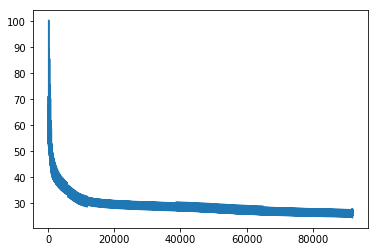

INFO - [1] training...
100%|██████████| 266/266 [00:26<00:00, 10.06it/s]
INFO - [1] training loss:26.066553115844727
INFO - [2] training...
100%|██████████| 266/266 [00:25<00:00, 10.24it/s]
INFO - [2] training loss:26.060182571411133
INFO - [3] training...
100%|██████████| 266/266 [00:26<00:00, 11.09it/s]
INFO - [3] training loss:26.053831100463867
INFO - [4] training...
100%|██████████| 266/266 [00:26<00:00, 10.65it/s]
INFO - [4] training loss:26.04751205444336
INFO - [5] training...
100%|██████████| 266/266 [00:24<00:00, 10.97it/s]
INFO - [5] training loss:26.041217803955078
INFO - [6] training...
100%|██████████| 266/266 [00:26<00:00,  9.93it/s]
INFO - [6] training loss:26.034948348999023
INFO - [7] training...
100%|██████████| 266/266 [00:24<00:00, 10.65it/s]
INFO - [7] training loss:26.028701782226562
INFO - [8] training...
100%|██████████| 266/266 [00:25<00:00, 10.00it/s]
INFO - [8] training loss:26.022489547729492
INFO - [9] training...
100%|██████████| 266/266 [00:24<00:00, 12.

100%|██████████| 15/15 [00:00<00:00, 208.12it/s]INFO - [10] test loss:26.646385192871094

100%|██████████| 22/22 [00:00<00:00, 174.71it/s]INFO - [10] test loss:25.79523468017578

100%|██████████| 14/14 [00:00<00:00, 129.39it/s]INFO - [10] test loss:26.225807189941406

100%|██████████| 19/19 [00:00<00:00, 211.21it/s]INFO - [10] test loss:26.55034828186035

100%|██████████| 23/23 [00:00<00:00, 214.68it/s]INFO - [10] test loss:26.24131965637207

100%|██████████| 15/15 [00:00<00:00, 210.30it/s]INFO - [10] test loss:25.70104217529297

100%|██████████| 16/16 [00:00<00:00, 213.46it/s]INFO - [10] test loss:26.21024513244629

100%|██████████| 16/16 [00:00<00:00, 209.91it/s]INFO - [10] test loss:26.850696563720703

100%|██████████| 18/18 [00:00<00:00, 223.01it/s]INFO - [10] test loss:26.334064483642578

100%|██████████| 18/18 [00:00<00:00, 158.23it/s]INFO - [10] test loss:27.11481285095215

100%|██████████| 16/16 [00:00<00:00, 217.48it/s]INFO - [10] test loss:25.89132308959961

100%|██████████| 

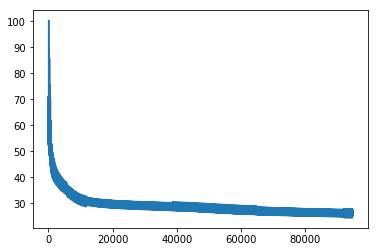

INFO - [11] training...
100%|██████████| 266/266 [00:27<00:00,  9.39it/s]
INFO - [11] training loss:26.003984451293945
INFO - [12] training...
100%|██████████| 266/266 [00:26<00:00,  9.38it/s]
INFO - [12] training loss:25.99787139892578
INFO - [13] training...
100%|██████████| 266/266 [00:26<00:00, 10.29it/s]
INFO - [13] training loss:25.991779327392578
INFO - [14] training...
100%|██████████| 266/266 [00:24<00:00, 10.93it/s]
INFO - [14] training loss:25.985713958740234
INFO - [15] training...
100%|██████████| 266/266 [00:25<00:00, 10.28it/s]
INFO - [15] training loss:25.979677200317383
INFO - [16] training...
100%|██████████| 266/266 [00:27<00:00, 10.92it/s]
INFO - [16] training loss:25.973665237426758
INFO - [17] training...
100%|██████████| 266/266 [00:23<00:00, 11.12it/s]
INFO - [17] training loss:25.96767807006836
INFO - [18] training...
100%|██████████| 266/266 [00:23<00:00, 11.32it/s]
INFO - [18] training loss:25.961719512939453
INFO - [19] training...
100%|██████████| 266/266 [

100%|██████████| 15/15 [00:00<00:00, 221.34it/s]INFO - [20] test loss:26.578044891357422

100%|██████████| 22/22 [00:00<00:00, 220.68it/s]INFO - [20] test loss:25.74144172668457

100%|██████████| 14/14 [00:00<00:00, 177.75it/s]INFO - [20] test loss:26.161184310913086

100%|██████████| 19/19 [00:00<00:00, 223.86it/s]INFO - [20] test loss:26.483089447021484

100%|██████████| 23/23 [00:00<00:00, 216.32it/s]INFO - [20] test loss:26.180335998535156

100%|██████████| 15/15 [00:00<00:00, 199.64it/s]INFO - [20] test loss:25.633440017700195

100%|██████████| 16/16 [00:00<00:00, 214.91it/s]INFO - [20] test loss:26.14910125732422

100%|██████████| 16/16 [00:00<00:00, 224.45it/s]INFO - [20] test loss:26.783401489257812

100%|██████████| 18/18 [00:00<00:00, 215.63it/s]INFO - [20] test loss:26.267940521240234

100%|██████████| 18/18 [00:00<00:00, 213.48it/s]INFO - [20] test loss:27.0522403717041

100%|██████████| 16/16 [00:00<00:00, 135.83it/s]INFO - [20] test loss:25.827194213867188

100%|█████████

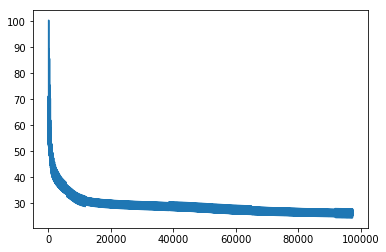

INFO - [21] training...
100%|██████████| 266/266 [00:27<00:00, 10.18it/s]
INFO - [21] training loss:25.943998336791992
INFO - [22] training...
100%|██████████| 266/266 [00:27<00:00,  8.97it/s]
INFO - [22] training loss:25.938140869140625
INFO - [23] training...
100%|██████████| 266/266 [00:28<00:00,  8.92it/s]
INFO - [23] training loss:25.93231201171875
INFO - [24] training...
100%|██████████| 266/266 [00:28<00:00, 10.25it/s]
INFO - [24] training loss:25.9265079498291
INFO - [25] training...
100%|██████████| 266/266 [00:26<00:00,  9.66it/s]
INFO - [25] training loss:25.92072868347168
INFO - [26] training...
100%|██████████| 266/266 [00:27<00:00,  9.67it/s]
INFO - [26] training loss:25.914981842041016
INFO - [27] training...
100%|██████████| 266/266 [00:25<00:00, 10.93it/s]
INFO - [27] training loss:25.909259796142578
INFO - [28] training...
100%|██████████| 266/266 [00:27<00:00,  9.68it/s]
INFO - [28] training loss:25.903560638427734
INFO - [29] training...
100%|██████████| 266/266 [00

100%|██████████| 16/16 [00:00<00:00, 212.19it/s]INFO - [30] test loss:26.29295539855957

100%|██████████| 14/14 [00:00<00:00, 205.56it/s]INFO - [30] test loss:25.234729766845703

100%|██████████| 22/22 [00:00<00:00, 213.82it/s]
INFO - [30] test loss:25.690311431884766
100%|██████████| 15/15 [00:00<00:00, 209.01it/s]INFO - [30] test loss:25.713672637939453

100%|██████████| 15/15 [00:00<00:00, 210.75it/s]INFO - [30] test loss:25.610992431640625

100%|██████████| 14/14 [00:00<00:00, 216.76it/s]INFO - [30] test loss:26.00993537902832

100%|██████████| 23/23 [00:00<00:00, 228.78it/s]
INFO - [30] test loss:26.122638702392578
100%|██████████| 15/15 [00:00<00:00, 220.48it/s]INFO - [30] test loss:26.031213760375977

100%|██████████| 15/15 [00:00<00:00, 221.06it/s]INFO - [30] test loss:25.033855438232422

100%|██████████| 14/14 [00:00<00:00, 224.46it/s]INFO - [30] test loss:24.84042739868164

100%|██████████| 15/15 [00:00<00:00, 232.28it/s]INFO - [30] test loss:25.74875259399414

100%|█████████

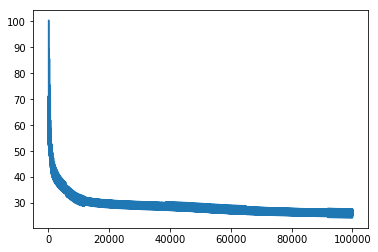

INFO - [31] training...
100%|██████████| 266/266 [00:24<00:00,  9.18it/s]
INFO - [31] training loss:25.886615753173828
INFO - [32] training...
100%|██████████| 266/266 [00:27<00:00, 11.89it/s]
INFO - [32] training loss:25.88101577758789
INFO - [33] training...
100%|██████████| 266/266 [00:25<00:00,  9.62it/s]
INFO - [33] training loss:25.875446319580078
INFO - [34] training...
100%|██████████| 266/266 [00:27<00:00,  9.88it/s]
INFO - [34] training loss:25.869895935058594
INFO - [35] training...
100%|██████████| 266/266 [00:27<00:00,  9.65it/s]
INFO - [35] training loss:25.8643741607666
INFO - [36] training...
100%|██████████| 266/266 [00:27<00:00,  9.23it/s]
INFO - [36] training loss:25.858867645263672
INFO - [37] training...
100%|██████████| 266/266 [00:28<00:00,  9.41it/s]
INFO - [37] training loss:25.8533878326416
INFO - [38] training...
100%|██████████| 266/266 [00:26<00:00, 10.36it/s]
INFO - [38] training loss:25.84793472290039
INFO - [39] training...
100%|██████████| 266/266 [00:2


100%|██████████| 14/14 [00:00<00:00, 192.84it/s]INFO - [40] test loss:25.17254638671875

100%|██████████| 15/15 [00:00<00:00, 213.66it/s]INFO - [40] test loss:25.657655715942383

100%|██████████| 15/15 [00:00<00:00, 215.08it/s]INFO - [40] test loss:25.554677963256836

100%|██████████| 14/14 [00:00<00:00, 213.53it/s]INFO - [40] test loss:25.957334518432617

100%|██████████| 23/23 [00:00<00:00, 219.27it/s]
INFO - [40] test loss:26.068113327026367
100%|██████████| 15/15 [00:00<00:00, 213.91it/s]INFO - [40] test loss:25.968210220336914

100%|██████████| 15/15 [00:00<00:00, 149.52it/s]
INFO - [40] test loss:25.50882911682129
100%|██████████| 15/15 [00:00<00:00, 189.80it/s]INFO - [40] test loss:24.981046676635742

100%|██████████| 14/14 [00:00<00:00, 212.81it/s]INFO - [40] test loss:24.786273956298828

100%|██████████| 15/15 [00:00<00:00, 214.71it/s]INFO - [40] test loss:25.6901798248291

100%|██████████| 16/16 [00:00<00:00, 222.37it/s]INFO - [40] test loss:26.46928596496582

100%|█████████

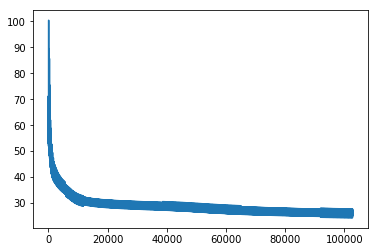

INFO - [41] training...
100%|██████████| 266/266 [00:26<00:00, 10.09it/s]
INFO - [41] training loss:25.831697463989258
INFO - [42] training...
100%|██████████| 266/266 [00:28<00:00,  8.81it/s]
INFO - [42] training loss:25.82632827758789
INFO - [43] training...
100%|██████████| 266/266 [00:28<00:00,  9.86it/s]
INFO - [43] training loss:25.82097816467285
INFO - [44] training...
100%|██████████| 266/266 [00:26<00:00,  9.84it/s]
INFO - [44] training loss:25.815649032592773
INFO - [45] training...
100%|██████████| 266/266 [00:27<00:00,  9.35it/s]
INFO - [45] training loss:25.810340881347656
INFO - [46] training...
100%|██████████| 266/266 [00:28<00:00,  9.34it/s]
INFO - [46] training loss:25.80504608154297
INFO - [47] training...
100%|██████████| 266/266 [00:29<00:00,  8.68it/s]
INFO - [47] training loss:25.799772262573242
INFO - [48] training...
100%|██████████| 266/266 [00:25<00:00,  9.90it/s]
INFO - [48] training loss:25.794513702392578
INFO - [49] training...
100%|██████████| 266/266 [0

100%|██████████| 15/15 [00:00<00:00, 223.31it/s]INFO - [50] test loss:26.393692016601562

100%|██████████| 22/22 [00:00<00:00, 227.43it/s]INFO - [50] test loss:25.595909118652344

100%|██████████| 14/14 [00:00<00:00, 221.12it/s]INFO - [50] test loss:25.98479461669922

100%|██████████| 19/19 [00:00<00:00, 224.31it/s]INFO - [50] test loss:26.299821853637695

100%|██████████| 23/23 [00:00<00:00, 231.03it/s]INFO - [50] test loss:26.016427993774414

100%|██████████| 15/15 [00:00<00:00, 226.90it/s]INFO - [50] test loss:25.451025009155273

100%|██████████| 16/16 [00:00<00:00, 158.72it/s]
INFO - [50] test loss:25.983671188354492

100%|██████████| 16/16 [00:00<00:00, 216.01it/s]INFO - [50] test loss:26.602758407592773

100%|██████████| 18/18 [00:00<00:00, 220.87it/s]INFO - [50] test loss:26.09029769897461

100%|██████████| 18/18 [00:00<00:00, 219.32it/s]INFO - [50] test loss:26.883522033691406

100%|██████████| 16/16 [00:00<00:00, 219.99it/s]INFO - [50] test loss:25.65552520751953

100%|███████

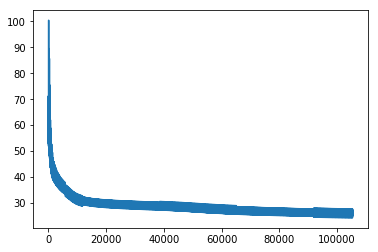

INFO - [51] training...
100%|██████████| 266/266 [00:26<00:00, 10.02it/s]
INFO - [51] training loss:25.77883529663086
INFO - [52] training...
100%|██████████| 266/266 [00:27<00:00,  9.59it/s]
INFO - [52] training loss:25.77364158630371
INFO - [53] training...
100%|██████████| 266/266 [00:25<00:00, 12.03it/s]
INFO - [53] training loss:25.768457412719727
INFO - [54] training...
100%|██████████| 266/266 [00:28<00:00,  8.96it/s]
INFO - [54] training loss:25.76329231262207
INFO - [55] training...
100%|██████████| 266/266 [00:27<00:00, 10.78it/s]
INFO - [55] training loss:25.758132934570312
INFO - [56] training...
100%|██████████| 266/266 [00:26<00:00,  9.40it/s]
INFO - [56] training loss:25.752992630004883
INFO - [57] training...
100%|██████████| 266/266 [00:27<00:00,  8.34it/s]
INFO - [57] training loss:25.747859954833984
INFO - [58] training...
100%|██████████| 266/266 [00:25<00:00, 12.65it/s]
INFO - [58] training loss:25.74273109436035
INFO - [59] training...
100%|██████████| 266/266 [00

100%|██████████| 16/16 [00:00<00:00, 217.19it/s]INFO - [60] test loss:26.12818145751953

100%|██████████| 14/14 [00:00<00:00, 222.91it/s]INFO - [60] test loss:25.056482315063477

100%|██████████| 15/15 [00:00<00:00, 225.61it/s]INFO - [60] test loss:25.55502700805664

100%|██████████| 15/15 [00:00<00:00, 219.27it/s]INFO - [60] test loss:25.449932098388672

100%|██████████| 14/14 [00:00<00:00, 218.61it/s]INFO - [60] test loss:25.858829498291016

100%|██████████| 15/15 [00:00<00:00, 151.64it/s]INFO - [60] test loss:25.85148048400879

100%|██████████| 15/15 [00:00<00:00, 194.80it/s]INFO - [60] test loss:24.88385581970215

100%|██████████| 14/14 [00:00<00:00, 214.55it/s]INFO - [60] test loss:24.683286666870117

100%|██████████| 15/15 [00:00<00:00, 218.41it/s]INFO - [60] test loss:25.58005714416504

100%|██████████| 16/16 [00:00<00:00, 217.21it/s]INFO - [60] test loss:26.355798721313477

100%|██████████| 16/16 [00:00<00:00, 217.67it/s]INFO - [60] test loss:25.004446029663086

100%|██████████

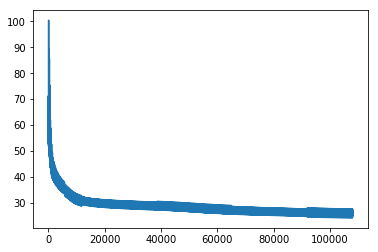

INFO - [61] training...
100%|██████████| 266/266 [00:26<00:00, 10.81it/s]
INFO - [61] training loss:25.727418899536133
INFO - [62] training...
100%|██████████| 266/266 [00:22<00:00,  7.71it/s]
INFO - [62] training loss:25.722332000732422
INFO - [63] training...
100%|██████████| 266/266 [00:28<00:00,  9.22it/s]
INFO - [63] training loss:25.717243194580078
INFO - [64] training...
100%|██████████| 266/266 [00:24<00:00, 10.98it/s]
INFO - [64] training loss:25.712167739868164
INFO - [65] training...
100%|██████████| 266/266 [00:27<00:00,  9.53it/s]
INFO - [65] training loss:25.707094192504883
INFO - [66] training...
100%|██████████| 266/266 [00:26<00:00,  9.40it/s]
INFO - [66] training loss:25.702024459838867
INFO - [67] training...
100%|██████████| 266/266 [00:28<00:00,  9.22it/s]
INFO - [67] training loss:25.69695472717285
INFO - [68] training...
100%|██████████| 266/266 [00:27<00:00,  9.84it/s]
INFO - [68] training loss:25.69188690185547
INFO - [69] training...
100%|██████████| 266/266 [

100%|██████████| 16/16 [00:00<00:00, 158.50it/s]
INFO - [70] test loss:26.078737258911133

100%|██████████| 14/14 [00:00<00:00, 215.80it/s]INFO - [70] test loss:25.001630783081055

100%|██████████| 22/22 [00:00<00:00, 216.21it/s]
INFO - [70] test loss:25.509571075439453
100%|██████████| 15/15 [00:00<00:00, 218.20it/s]INFO - [70] test loss:25.507373809814453

100%|██████████| 15/15 [00:00<00:00, 224.12it/s]INFO - [70] test loss:25.400375366210938

100%|██████████| 14/14 [00:00<00:00, 218.98it/s]INFO - [70] test loss:25.8120174407959

100%|██████████| 23/23 [00:00<00:00, 227.71it/s]
INFO - [70] test loss:25.91962242126465
100%|██████████| 15/15 [00:00<00:00, 221.92it/s]INFO - [70] test loss:25.796438217163086

100%|██████████| 15/15 [00:00<00:00, 225.22it/s]INFO - [70] test loss:24.83827018737793

100%|██████████| 14/14 [00:00<00:00, 220.53it/s]INFO - [70] test loss:24.633150100708008

100%|██████████| 15/15 [00:00<00:00, 222.31it/s]INFO - [70] test loss:25.527315139770508

100%|████████

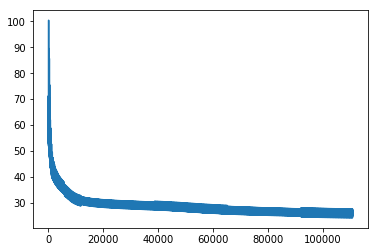

INFO - [71] training...
100%|██████████| 266/266 [00:27<00:00, 10.47it/s]
INFO - [71] training loss:25.67669105529785
INFO - [72] training...
100%|██████████| 266/266 [00:25<00:00, 12.71it/s]
INFO - [72] training loss:25.671621322631836
INFO - [73] training...
100%|██████████| 266/266 [00:22<00:00,  8.97it/s]
INFO - [73] training loss:25.666555404663086
INFO - [74] training...
100%|██████████| 266/266 [00:27<00:00,  9.15it/s]
INFO - [74] training loss:25.661479949951172
INFO - [75] training...
100%|██████████| 266/266 [00:27<00:00,  9.00it/s]
INFO - [75] training loss:25.656404495239258
INFO - [76] training...
100%|██████████| 266/266 [00:24<00:00, 12.48it/s]
INFO - [76] training loss:25.651321411132812
INFO - [77] training...
100%|██████████| 266/266 [00:27<00:00,  9.20it/s]
INFO - [77] training loss:25.64623260498047
INFO - [78] training...
100%|██████████| 266/266 [00:27<00:00, 10.13it/s]
INFO - [78] training loss:25.641136169433594
INFO - [79] training...
100%|██████████| 266/266 [

100%|██████████| 14/14 [00:00<00:00, 216.21it/s]INFO - [80] test loss:24.94818687438965

100%|██████████| 22/22 [00:00<00:00, 215.79it/s]
INFO - [80] test loss:25.468259811401367
100%|██████████| 15/15 [00:00<00:00, 219.81it/s]INFO - [80] test loss:25.461400985717773

100%|██████████| 15/15 [00:00<00:00, 216.73it/s]INFO - [80] test loss:25.351806640625

100%|██████████| 14/14 [00:00<00:00, 209.28it/s]INFO - [80] test loss:25.766145706176758

100%|██████████| 15/15 [00:00<00:00, 195.51it/s]INFO - [80] test loss:25.742645263671875

100%|██████████| 15/15 [00:00<00:00, 220.31it/s]INFO - [80] test loss:24.793787002563477

100%|██████████| 14/14 [00:00<00:00, 226.49it/s]INFO - [80] test loss:24.582983016967773

100%|██████████| 15/15 [00:00<00:00, 190.61it/s]INFO - [80] test loss:25.475208282470703

100%|██████████| 16/16 [00:00<00:00, 220.43it/s]INFO - [80] test loss:26.25089454650879

100%|██████████| 16/16 [00:00<00:00, 217.87it/s]INFO - [80] test loss:24.896221160888672

100%|██████████

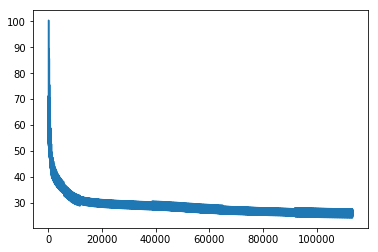

INFO - [81] training...
100%|██████████| 266/266 [00:27<00:00, 10.22it/s]
INFO - [81] training loss:25.625795364379883
INFO - [82] training...
100%|██████████| 266/266 [00:26<00:00, 12.41it/s]
INFO - [82] training loss:25.62066650390625
INFO - [83] training...
100%|██████████| 266/266 [00:27<00:00,  9.12it/s]
INFO - [83] training loss:25.615520477294922
INFO - [84] training...
100%|██████████| 266/266 [00:27<00:00, 10.34it/s]
INFO - [84] training loss:25.610366821289062
INFO - [85] training...
100%|██████████| 266/266 [00:28<00:00, 10.08it/s]
INFO - [85] training loss:25.60519790649414
INFO - [86] training...
100%|██████████| 266/266 [00:25<00:00,  9.03it/s]
INFO - [86] training loss:25.60001564025879
INFO - [87] training...
100%|██████████| 266/266 [00:27<00:00,  8.51it/s]
INFO - [87] training loss:25.594818115234375
INFO - [88] training...
100%|██████████| 266/266 [00:27<00:00,  8.49it/s]
INFO - [88] training loss:25.589603424072266
INFO - [89] training...
100%|██████████| 266/266 [0


100%|██████████| 14/14 [00:00<00:00, 213.63it/s]INFO - [90] test loss:24.895618438720703

100%|██████████| 15/15 [00:00<00:00, 204.48it/s]INFO - [90] test loss:25.416484832763672

100%|██████████| 15/15 [00:00<00:00, 212.14it/s]INFO - [90] test loss:25.303478240966797

100%|██████████| 14/14 [00:00<00:00, 210.79it/s]INFO - [90] test loss:25.720640182495117

100%|██████████| 15/15 [00:00<00:00, 154.77it/s]INFO - [90] test loss:25.68936538696289

100%|██████████| 15/15 [00:00<00:00, 126.07it/s]INFO - [90] test loss:24.749778747558594

100%|██████████| 14/14 [00:00<00:00, 210.69it/s]INFO - [90] test loss:24.532169342041016

100%|██████████| 15/15 [00:00<00:00, 216.52it/s]INFO - [90] test loss:25.423093795776367

100%|██████████| 16/16 [00:00<00:00, 218.35it/s]INFO - [90] test loss:26.20014190673828

100%|██████████| 16/16 [00:00<00:00, 215.49it/s]INFO - [90] test loss:24.844160079956055

100%|██████████| 16/16 [00:00<00:00, 220.36it/s]INFO - [90] test loss:26.100496292114258

100%|██████

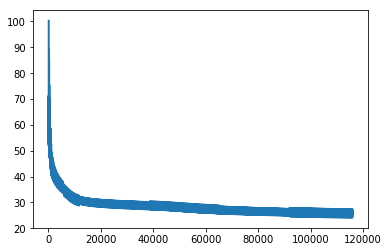

INFO - [91] training...
100%|██████████| 266/266 [00:26<00:00, 10.29it/s]
INFO - [91] training loss:25.57386016845703
INFO - [92] training...
100%|██████████| 266/266 [00:27<00:00,  9.05it/s]
INFO - [92] training loss:25.568580627441406
INFO - [93] training...
100%|██████████| 266/266 [00:27<00:00, 10.15it/s]
INFO - [93] training loss:25.563278198242188
INFO - [94] training...
100%|██████████| 266/266 [00:27<00:00,  9.69it/s]
INFO - [94] training loss:25.557952880859375
INFO - [95] training...
100%|██████████| 266/266 [00:27<00:00,  9.82it/s]
INFO - [95] training loss:25.5526123046875
INFO - [96] training...
100%|██████████| 266/266 [00:27<00:00,  9.77it/s]
INFO - [96] training loss:25.547252655029297
INFO - [97] training...
100%|██████████| 266/266 [00:23<00:00,  8.20it/s]
INFO - [97] training loss:25.541866302490234
INFO - [98] training...
100%|██████████| 266/266 [00:28<00:00,  7.89it/s]
INFO - [98] training loss:25.536460876464844
INFO - [99] training...
100%|██████████| 266/266 [0


100%|██████████| 14/14 [00:00<00:00, 209.18it/s]INFO - [100] test loss:24.843446731567383

100%|██████████| 15/15 [00:00<00:00, 218.25it/s]INFO - [100] test loss:25.371912002563477

100%|██████████| 15/15 [00:00<00:00, 223.00it/s]INFO - [100] test loss:25.254636764526367

100%|██████████| 14/14 [00:00<00:00, 223.14it/s]INFO - [100] test loss:25.6749324798584

100%|██████████| 23/23 [00:00<00:00, 225.14it/s]
INFO - [100] test loss:25.782522201538086
100%|██████████| 15/15 [00:00<00:00, 222.02it/s]INFO - [100] test loss:25.635848999023438

100%|██████████| 15/15 [00:00<00:00, 219.20it/s]INFO - [100] test loss:24.70565414428711

100%|██████████| 14/14 [00:00<00:00, 223.49it/s]INFO - [100] test loss:24.4802303314209

100%|██████████| 15/15 [00:00<00:00, 224.29it/s]INFO - [100] test loss:25.370399475097656

100%|██████████| 16/16 [00:00<00:00, 224.57it/s]INFO - [100] test loss:26.149673461914062

100%|██████████| 16/16 [00:00<00:00, 228.26it/s]INFO - [100] test loss:24.792940139770508

100

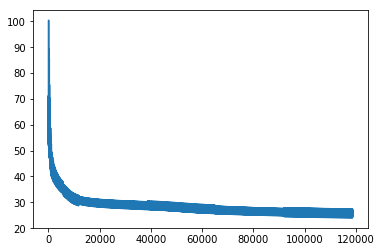

INFO - [101] training...
100%|██████████| 266/266 [00:26<00:00,  9.78it/s]
INFO - [101] training loss:25.520105361938477
INFO - [102] training...
100%|██████████| 266/266 [00:26<00:00,  9.88it/s]
INFO - [102] training loss:25.51460838317871
INFO - [103] training...
100%|██████████| 266/266 [00:27<00:00,  9.12it/s]
INFO - [103] training loss:25.509082794189453
INFO - [104] training...
100%|██████████| 266/266 [00:25<00:00, 10.60it/s]
INFO - [104] training loss:25.503536224365234
INFO - [105] training...
100%|██████████| 266/266 [00:22<00:00, 11.61it/s]
INFO - [105] training loss:25.497968673706055
INFO - [106] training...
100%|██████████| 266/266 [00:27<00:00,  9.79it/s]
INFO - [106] training loss:25.49237060546875
INFO - [107] training...
100%|██████████| 266/266 [00:26<00:00,  8.83it/s]
INFO - [107] training loss:25.48674964904785
INFO - [108] training...
100%|██████████| 266/266 [00:27<00:00,  8.88it/s]
INFO - [108] training loss:25.481111526489258
INFO - [109] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 235.96it/s]INFO - [110] test loss:25.892345428466797

100%|██████████| 14/14 [00:00<00:00, 234.86it/s]INFO - [110] test loss:24.79129409790039

100%|██████████| 15/15 [00:00<00:00, 234.80it/s]INFO - [110] test loss:25.326993942260742

100%|██████████| 15/15 [00:00<00:00, 233.42it/s]INFO - [110] test loss:25.204586029052734

100%|██████████| 14/14 [00:00<00:00, 222.45it/s]INFO - [110] test loss:25.628490447998047

100%|██████████| 15/15 [00:00<00:00, 225.36it/s]INFO - [110] test loss:25.58150291442871

100%|██████████| 15/15 [00:00<00:00, 214.47it/s]INFO - [110] test loss:24.660974502563477

100%|██████████| 14/14 [00:00<00:00, 219.07it/s]INFO - [110] test loss:24.427064895629883

100%|██████████| 15/15 [00:00<00:00, 194.01it/s]INFO - [110] test loss:25.31684112548828

100%|██████████| 16/16 [00:00<00:00, 226.04it/s]INFO - [110] test loss:26.098941802978516

100%|██████████| 16/16 [00:00<00:00, 224.79it/s]INFO - [110] test loss:24.742210388183594

10

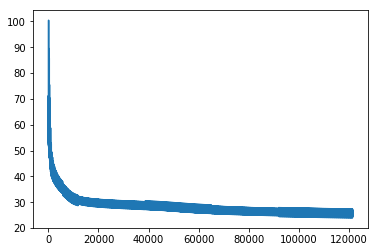

INFO - [111] training...
100%|██████████| 266/266 [00:28<00:00,  9.51it/s]
INFO - [111] training loss:25.46405029296875
INFO - [112] training...
100%|██████████| 266/266 [00:28<00:00,  8.49it/s]
INFO - [112] training loss:25.458316802978516
INFO - [113] training...
100%|██████████| 266/266 [00:26<00:00,  9.42it/s]
INFO - [113] training loss:25.452560424804688
INFO - [114] training...
100%|██████████| 266/266 [00:27<00:00,  9.66it/s]
INFO - [114] training loss:25.446786880493164
INFO - [115] training...
100%|██████████| 266/266 [00:26<00:00, 10.55it/s]
INFO - [115] training loss:25.440982818603516
INFO - [116] training...
100%|██████████| 266/266 [00:26<00:00, 11.26it/s]
INFO - [116] training loss:25.43517303466797
INFO - [117] training...
100%|██████████| 266/266 [00:26<00:00, 12.55it/s]
INFO - [117] training loss:25.42933464050293
INFO - [118] training...
100%|██████████| 266/266 [00:21<00:00, 10.76it/s]
INFO - [118] training loss:25.423480987548828
INFO - [119] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 205.87it/s]INFO - [120] test loss:25.845722198486328

100%|██████████| 14/14 [00:00<00:00, 210.48it/s]INFO - [120] test loss:24.738948822021484

100%|██████████| 22/22 [00:00<00:00, 216.97it/s]
INFO - [120] test loss:25.307540893554688
100%|██████████| 15/15 [00:00<00:00, 224.65it/s]INFO - [120] test loss:25.28118133544922

100%|██████████| 15/15 [00:00<00:00, 171.16it/s]INFO - [120] test loss:25.153032302856445

100%|██████████| 14/14 [00:00<00:00, 217.41it/s]INFO - [120] test loss:25.580963134765625

100%|██████████| 23/23 [00:00<00:00, 221.10it/s]
INFO - [120] test loss:25.690086364746094
100%|██████████| 15/15 [00:00<00:00, 219.73it/s]INFO - [120] test loss:25.52602767944336

100%|██████████| 15/15 [00:00<00:00, 222.61it/s]INFO - [120] test loss:24.615493774414062

100%|██████████| 14/14 [00:00<00:00, 214.40it/s]INFO - [120] test loss:24.373044967651367

100%|██████████| 15/15 [00:00<00:00, 216.73it/s]INFO - [120] test loss:25.26253890991211

10

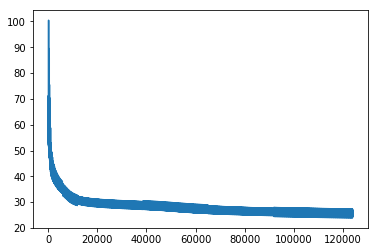

INFO - [121] training...
100%|██████████| 266/266 [00:27<00:00, 10.62it/s]
INFO - [121] training loss:25.40582275390625
INFO - [122] training...
100%|██████████| 266/266 [00:26<00:00,  8.62it/s]
INFO - [122] training loss:25.399911880493164
INFO - [123] training...
100%|██████████| 266/266 [00:25<00:00,  9.90it/s]
INFO - [123] training loss:25.39398956298828
INFO - [124] training...
100%|██████████| 266/266 [00:24<00:00,  7.36it/s]
INFO - [124] training loss:25.388050079345703
INFO - [125] training...
100%|██████████| 266/266 [00:27<00:00, 10.53it/s]
INFO - [125] training loss:25.382102966308594
INFO - [126] training...
100%|██████████| 266/266 [00:26<00:00, 10.02it/s]
INFO - [126] training loss:25.376148223876953
INFO - [127] training...
100%|██████████| 266/266 [00:21<00:00,  9.93it/s]
INFO - [127] training loss:25.37018585205078
INFO - [128] training...
100%|██████████| 266/266 [00:27<00:00,  9.59it/s]
INFO - [128] training loss:25.36422348022461
INFO - [129] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 231.55it/s]INFO - [130] test loss:25.7985897064209

100%|██████████| 14/14 [00:00<00:00, 184.91it/s]INFO - [130] test loss:24.686384201049805

100%|██████████| 22/22 [00:00<00:00, 217.58it/s]
INFO - [130] test loss:25.268320083618164
100%|██████████| 15/15 [00:00<00:00, 211.27it/s]INFO - [130] test loss:25.234350204467773

100%|██████████| 15/15 [00:00<00:00, 148.40it/s]
INFO - [130] test loss:25.100284576416016

100%|██████████| 14/14 [00:00<00:00, 171.85it/s]INFO - [130] test loss:25.532236099243164

100%|██████████| 15/15 [00:00<00:00, 218.61it/s]INFO - [130] test loss:25.469587326049805

100%|██████████| 15/15 [00:00<00:00, 186.58it/s]INFO - [130] test loss:24.569190979003906

100%|██████████| 14/14 [00:00<00:00, 214.06it/s]INFO - [130] test loss:24.319087982177734

100%|██████████| 15/15 [00:00<00:00, 206.25it/s]INFO - [130] test loss:25.208078384399414

100%|██████████| 16/16 [00:00<00:00, 121.75it/s]INFO - [130] test loss:25.995576858520508



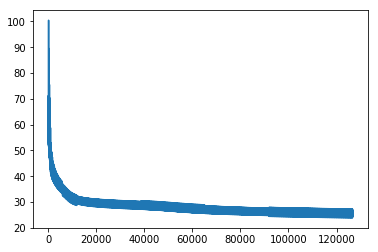

INFO - [131] training...
100%|██████████| 266/266 [00:26<00:00, 12.55it/s]
INFO - [131] training loss:25.346296310424805
INFO - [132] training...
100%|██████████| 266/266 [00:26<00:00, 10.76it/s]
INFO - [132] training loss:25.340320587158203
INFO - [133] training...
100%|██████████| 266/266 [00:24<00:00,  9.01it/s]
INFO - [133] training loss:25.3343448638916
INFO - [134] training...
100%|██████████| 266/266 [00:27<00:00, 10.16it/s]
INFO - [134] training loss:25.328371047973633
INFO - [135] training...
100%|██████████| 266/266 [00:25<00:00, 10.37it/s]
INFO - [135] training loss:25.322397232055664
INFO - [136] training...
100%|██████████| 266/266 [00:27<00:00,  9.89it/s]
INFO - [136] training loss:25.316429138183594
INFO - [137] training...
100%|██████████| 266/266 [00:26<00:00,  9.43it/s]
INFO - [137] training loss:25.310468673706055
INFO - [138] training...
100%|██████████| 266/266 [00:26<00:00, 11.51it/s]
INFO - [138] training loss:25.30451011657715
INFO - [139] training...
100%|█████

100%|██████████| 15/15 [00:00<00:00, 221.25it/s]INFO - [140] test loss:25.893062591552734

100%|██████████| 22/22 [00:00<00:00, 221.10it/s]INFO - [140] test loss:25.230045318603516

100%|██████████| 14/14 [00:00<00:00, 146.98it/s]INFO - [140] test loss:25.52245330810547

100%|██████████| 15/15 [00:00<00:00, 145.33it/s]
INFO - [140] test loss:25.04712677001953
100%|██████████| 19/19 [00:00<00:00, 215.75it/s]INFO - [140] test loss:25.806365966796875

100%|██████████| 23/23 [00:00<00:00, 220.39it/s]
INFO - [140] test loss:25.594436645507812

100%|██████████| 15/15 [00:00<00:00, 180.91it/s]INFO - [140] test loss:24.970468521118164

100%|██████████| 16/16 [00:00<00:00, 215.55it/s]INFO - [140] test loss:25.52667999267578

100%|██████████| 16/16 [00:00<00:00, 215.70it/s]INFO - [140] test loss:26.11016082763672

100%|██████████| 18/18 [00:00<00:00, 217.69it/s]INFO - [140] test loss:25.62668800354004

100%|██████████| 18/18 [00:00<00:00, 211.35it/s]INFO - [140] test loss:26.457752227783203

100

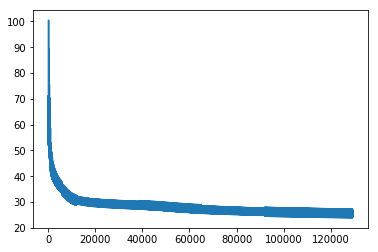

INFO - [141] training...
100%|██████████| 266/266 [00:24<00:00, 11.06it/s]
INFO - [141] training loss:25.28668212890625
INFO - [142] training...
100%|██████████| 266/266 [00:27<00:00,  9.67it/s]
INFO - [142] training loss:25.280757904052734
INFO - [143] training...
100%|██████████| 266/266 [00:26<00:00,  9.95it/s]
INFO - [143] training loss:25.27484130859375
INFO - [144] training...
100%|██████████| 266/266 [00:26<00:00, 10.11it/s]
INFO - [144] training loss:25.268938064575195
INFO - [145] training...
100%|██████████| 266/266 [00:28<00:00,  9.29it/s]
INFO - [145] training loss:25.263044357299805
INFO - [146] training...
100%|██████████| 266/266 [00:27<00:00,  8.19it/s]
INFO - [146] training loss:25.257160186767578
INFO - [147] training...
100%|██████████| 266/266 [00:28<00:00, 10.45it/s]
INFO - [147] training loss:25.25128936767578
INFO - [148] training...
100%|██████████| 266/266 [00:26<00:00,  9.74it/s]
INFO - [148] training loss:25.245426177978516
INFO - [149] training...
100%|█████


100%|██████████| 14/14 [00:00<00:00, 220.21it/s]INFO - [150] test loss:24.58139419555664

100%|██████████| 15/15 [00:00<00:00, 219.06it/s]INFO - [150] test loss:25.138614654541016

100%|██████████| 15/15 [00:00<00:00, 231.01it/s]INFO - [150] test loss:24.994226455688477

100%|██████████| 14/14 [00:00<00:00, 223.70it/s]INFO - [150] test loss:25.43202018737793

100%|██████████| 23/23 [00:00<00:00, 225.69it/s]
INFO - [150] test loss:25.54595375061035
100%|██████████| 15/15 [00:00<00:00, 225.80it/s]INFO - [150] test loss:25.355960845947266

100%|██████████| 15/15 [00:00<00:00, 138.26it/s]INFO - [150] test loss:24.474702835083008

100%|██████████| 14/14 [00:00<00:00, 215.84it/s]INFO - [150] test loss:24.21490478515625

100%|██████████| 15/15 [00:00<00:00, 214.81it/s]INFO - [150] test loss:25.10120391845703

100%|██████████| 16/16 [00:00<00:00, 213.44it/s]INFO - [150] test loss:25.890378952026367

100%|██████████| 16/16 [00:00<00:00, 217.81it/s]INFO - [150] test loss:24.542142868041992

100

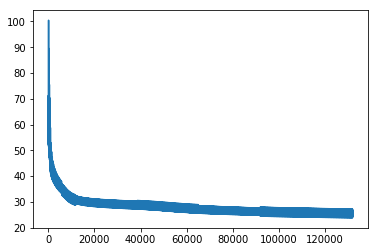

INFO - [151] training...
100%|██████████| 266/266 [00:27<00:00,  9.80it/s]
INFO - [151] training loss:25.227924346923828
INFO - [152] training...
100%|██████████| 266/266 [00:26<00:00,  9.62it/s]
INFO - [152] training loss:25.22211456298828
INFO - [153] training...
100%|██████████| 266/266 [00:24<00:00, 11.07it/s]
INFO - [153] training loss:25.21631622314453
INFO - [154] training...
100%|██████████| 266/266 [00:24<00:00, 10.67it/s]
INFO - [154] training loss:25.21053695678711
INFO - [155] training...
100%|██████████| 266/266 [00:24<00:00, 10.66it/s]
INFO - [155] training loss:25.204763412475586
INFO - [156] training...
100%|██████████| 266/266 [00:27<00:00,  9.68it/s]
INFO - [156] training loss:25.199010848999023
INFO - [157] training...
100%|██████████| 266/266 [00:28<00:00, 10.42it/s]
INFO - [157] training loss:25.193269729614258
INFO - [158] training...
100%|██████████| 266/266 [00:27<00:00,  9.70it/s]
INFO - [158] training loss:25.187536239624023
INFO - [159] training...
100%|█████

100%|██████████| 15/15 [00:00<00:00, 207.35it/s]INFO - [160] test loss:25.77845001220703

100%|██████████| 22/22 [00:00<00:00, 210.74it/s]
INFO - [160] test loss:25.157350540161133

100%|██████████| 15/15 [00:00<00:00, 142.20it/s]
INFO - [160] test loss:25.090421676635742
100%|██████████| 14/14 [00:00<00:00, 198.05it/s]INFO - [160] test loss:25.41650390625

100%|██████████| 19/19 [00:00<00:00, 174.58it/s]INFO - [160] test loss:25.69662094116211

100%|██████████| 23/23 [00:00<00:00, 210.33it/s]INFO - [160] test loss:25.497407913208008

100%|██████████| 15/15 [00:00<00:00, 214.88it/s]INFO - [160] test loss:24.863849639892578

100%|██████████| 16/16 [00:00<00:00, 217.21it/s]INFO - [160] test loss:25.41864776611328

100%|██████████| 16/16 [00:00<00:00, 210.25it/s]INFO - [160] test loss:26.000370025634766

100%|██████████| 18/18 [00:00<00:00, 138.37it/s]INFO - [160] test loss:25.524858474731445

100%|██████████| 18/18 [00:00<00:00, 221.20it/s]INFO - [160] test loss:26.356929779052734

100%|

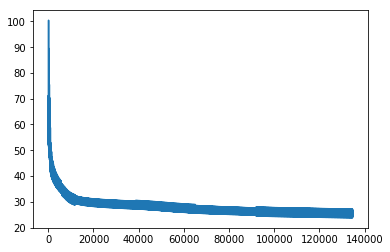

INFO - [161] training...
100%|██████████| 266/266 [00:27<00:00,  8.41it/s]
INFO - [161] training loss:25.17043685913086
INFO - [162] training...
100%|██████████| 266/266 [00:23<00:00, 11.18it/s]
INFO - [162] training loss:25.16476058959961
INFO - [163] training...
100%|██████████| 266/266 [00:21<00:00, 10.54it/s]
INFO - [163] training loss:25.159101486206055
INFO - [164] training...
100%|██████████| 266/266 [00:26<00:00, 10.74it/s]
INFO - [164] training loss:25.153453826904297
INFO - [165] training...
100%|██████████| 266/266 [00:27<00:00,  9.52it/s]
INFO - [165] training loss:25.147825241088867
INFO - [166] training...
100%|██████████| 266/266 [00:26<00:00,  9.26it/s]
INFO - [166] training loss:25.1422061920166
INFO - [167] training...
100%|██████████| 266/266 [00:26<00:00,  9.49it/s]
INFO - [167] training loss:25.1366024017334
INFO - [168] training...
100%|██████████| 266/266 [00:26<00:00,  8.93it/s]
INFO - [168] training loss:25.131006240844727
INFO - [169] training...
100%|████████

100%|██████████| 14/14 [00:00<00:00, 212.30it/s]INFO - [170] test loss:24.477943420410156

100%|██████████| 22/22 [00:00<00:00, 215.97it/s]
INFO - [170] test loss:25.122989654541016
100%|██████████| 15/15 [00:00<00:00, 221.84it/s]INFO - [170] test loss:25.04238510131836

100%|██████████| 15/15 [00:00<00:00, 215.65it/s]INFO - [170] test loss:24.890050888061523

100%|██████████| 14/14 [00:00<00:00, 216.86it/s]INFO - [170] test loss:25.33078384399414

100%|██████████| 23/23 [00:00<00:00, 223.70it/s]
INFO - [170] test loss:25.448942184448242
100%|██████████| 15/15 [00:00<00:00, 222.70it/s]INFO - [170] test loss:25.244009017944336

100%|██████████| 15/15 [00:00<00:00, 225.79it/s]INFO - [170] test loss:24.378870010375977

100%|██████████| 14/14 [00:00<00:00, 224.56it/s]INFO - [170] test loss:24.11728858947754

100%|██████████| 15/15 [00:00<00:00, 229.18it/s]INFO - [170] test loss:24.998624801635742

100%|██████████| 16/16 [00:00<00:00, 226.15it/s]INFO - [170] test loss:25.785537719726562

10

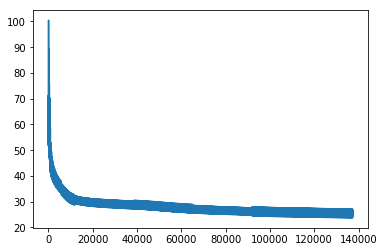

INFO - [171] training...
100%|██████████| 266/266 [00:29<00:00,  9.13it/s]
INFO - [171] training loss:25.11431121826172
INFO - [172] training...
100%|██████████| 266/266 [00:23<00:00, 11.41it/s]
INFO - [172] training loss:25.108766555786133
INFO - [173] training...
100%|██████████| 266/266 [00:23<00:00,  9.47it/s]
INFO - [173] training loss:25.103242874145508
INFO - [174] training...
100%|██████████| 266/266 [00:26<00:00,  9.26it/s]
INFO - [174] training loss:25.097726821899414
INFO - [175] training...
100%|██████████| 266/266 [00:26<00:00, 12.61it/s]
INFO - [175] training loss:25.09222984313965
INFO - [176] training...
100%|██████████| 266/266 [00:23<00:00, 10.61it/s]
INFO - [176] training loss:25.08673858642578
INFO - [177] training...
100%|██████████| 266/266 [00:27<00:00,  9.59it/s]
INFO - [177] training loss:25.08126449584961
INFO - [178] training...
100%|██████████| 266/266 [00:27<00:00,  9.49it/s]
INFO - [178] training loss:25.0757999420166
INFO - [179] training...
100%|████████

100%|██████████| 14/14 [00:00<00:00, 217.94it/s]INFO - [180] test loss:24.426931381225586

100%|██████████| 15/15 [00:00<00:00, 166.36it/s]INFO - [180] test loss:24.994665145874023

100%|██████████| 15/15 [00:00<00:00, 221.38it/s]INFO - [180] test loss:24.838531494140625

100%|██████████| 14/14 [00:00<00:00, 215.19it/s]INFO - [180] test loss:25.28074073791504

100%|██████████| 23/23 [00:00<00:00, 226.53it/s]
INFO - [180] test loss:25.400625228881836
100%|██████████| 15/15 [00:00<00:00, 218.28it/s]INFO - [180] test loss:25.18890380859375

100%|██████████| 15/15 [00:00<00:00, 221.26it/s]INFO - [180] test loss:24.330799102783203

100%|██████████| 14/14 [00:00<00:00, 224.17it/s]INFO - [180] test loss:24.07050895690918

100%|██████████| 15/15 [00:00<00:00, 230.90it/s]INFO - [180] test loss:24.94891357421875

100%|██████████| 16/16 [00:00<00:00, 219.85it/s]INFO - [180] test loss:25.733877182006836

100%|██████████| 16/16 [00:00<00:00, 226.46it/s]INFO - [180] test loss:24.39801788330078

100%

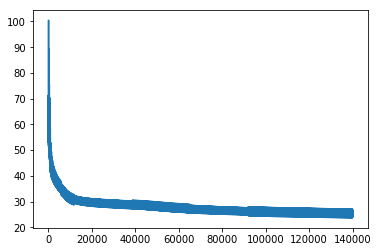

INFO - [181] training...
100%|██████████| 266/266 [00:27<00:00,  9.83it/s]
INFO - [181] training loss:25.059476852416992
INFO - [182] training...
100%|██████████| 266/266 [00:27<00:00,  7.70it/s]
INFO - [182] training loss:25.054059982299805
INFO - [183] training...
100%|██████████| 266/266 [00:26<00:00,  9.78it/s]
INFO - [183] training loss:25.04865264892578
INFO - [184] training...
100%|██████████| 266/266 [00:27<00:00, 10.24it/s]
INFO - [184] training loss:25.04326057434082
INFO - [185] training...
100%|██████████| 266/266 [00:24<00:00,  8.41it/s]
INFO - [185] training loss:25.03787612915039
INFO - [186] training...
100%|██████████| 266/266 [00:25<00:00,  9.78it/s]
INFO - [186] training loss:25.032499313354492
INFO - [187] training...
100%|██████████| 266/266 [00:27<00:00,  9.30it/s]
INFO - [187] training loss:25.02713966369629
INFO - [188] training...
100%|██████████| 266/266 [00:26<00:00, 10.29it/s]
INFO - [188] training loss:25.021793365478516
INFO - [189] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 134.40it/s]INFO - [190] test loss:25.525188446044922

100%|██████████| 14/14 [00:00<00:00, 152.98it/s]INFO - [190] test loss:24.376277923583984

100%|██████████| 15/15 [00:00<00:00, 212.03it/s]INFO - [190] test loss:24.947338104248047

100%|██████████| 15/15 [00:00<00:00, 206.96it/s]INFO - [190] test loss:24.787099838256836

100%|██████████| 14/14 [00:00<00:00, 196.93it/s]INFO - [190] test loss:25.231435775756836

100%|██████████| 15/15 [00:00<00:00, 209.98it/s]INFO - [190] test loss:25.134279251098633

100%|██████████| 15/15 [00:00<00:00, 206.28it/s]INFO - [190] test loss:24.282718658447266

100%|██████████| 14/14 [00:00<00:00, 199.42it/s]INFO - [190] test loss:24.02471160888672

100%|██████████| 15/15 [00:00<00:00, 215.45it/s]INFO - [190] test loss:24.900157928466797

100%|██████████| 16/16 [00:00<00:00, 163.48it/s]INFO - [190] test loss:25.682937622070312

100%|██████████| 16/16 [00:00<00:00, 210.22it/s]INFO - [190] test loss:24.35159683227539

1

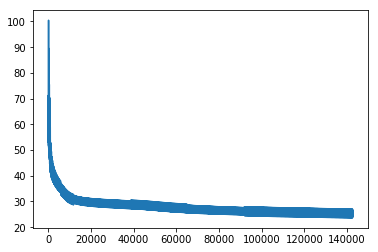

INFO - [191] training...
100%|██████████| 266/266 [00:23<00:00, 11.30it/s]
INFO - [191] training loss:25.00579833984375
INFO - [192] training...
100%|██████████| 266/266 [00:25<00:00, 10.38it/s]
INFO - [192] training loss:25.000484466552734
INFO - [193] training...
100%|██████████| 266/266 [00:22<00:00, 12.65it/s]
INFO - [193] training loss:24.995182037353516
INFO - [194] training...
100%|██████████| 266/266 [00:23<00:00,  9.87it/s]
INFO - [194] training loss:24.989885330200195
INFO - [195] training...
100%|██████████| 266/266 [00:26<00:00,  9.51it/s]
INFO - [195] training loss:24.984600067138672
INFO - [196] training...
100%|██████████| 266/266 [00:26<00:00, 10.93it/s]
INFO - [196] training loss:24.979326248168945
INFO - [197] training...
100%|██████████| 266/266 [00:25<00:00, 10.52it/s]
INFO - [197] training loss:24.974058151245117
INFO - [198] training...
100%|██████████| 266/266 [00:26<00:00,  9.87it/s]
INFO - [198] training loss:24.968801498413086
INFO - [199] training...
100%|███


100%|██████████| 14/14 [00:00<00:00, 204.82it/s]INFO - [200] test loss:24.325855255126953

100%|██████████| 15/15 [00:00<00:00, 210.22it/s]INFO - [200] test loss:24.900365829467773

100%|██████████| 15/15 [00:00<00:00, 223.12it/s]INFO - [200] test loss:24.735584259033203

100%|██████████| 14/14 [00:00<00:00, 223.83it/s]INFO - [200] test loss:25.183040618896484

100%|██████████| 23/23 [00:00<00:00, 226.91it/s]
INFO - [200] test loss:25.304277420043945
100%|██████████| 15/15 [00:00<00:00, 128.46it/s]INFO - [200] test loss:25.080007553100586

100%|██████████| 15/15 [00:00<00:00, 217.90it/s]INFO - [200] test loss:24.234636306762695

100%|██████████| 14/14 [00:00<00:00, 216.25it/s]INFO - [200] test loss:23.979618072509766

100%|██████████| 15/15 [00:00<00:00, 127.83it/s]INFO - [200] test loss:24.852256774902344

100%|██████████| 16/16 [00:00<00:00, 220.19it/s]INFO - [200] test loss:25.63279151916504

100%|██████████| 16/16 [00:00<00:00, 216.14it/s]INFO - [200] test loss:24.30596351623535



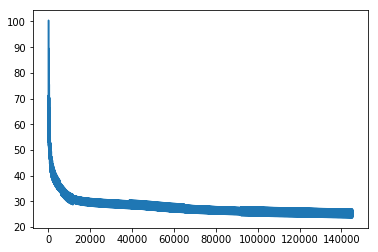

INFO - [201] training...
100%|██████████| 266/266 [00:26<00:00, 11.84it/s]
INFO - [201] training loss:24.953075408935547
INFO - [202] training...
100%|██████████| 266/266 [00:22<00:00,  9.99it/s]
INFO - [202] training loss:24.947851181030273
INFO - [203] training...
100%|██████████| 266/266 [00:27<00:00,  9.35it/s]
INFO - [203] training loss:24.942630767822266
INFO - [204] training...
100%|██████████| 266/266 [00:28<00:00, 10.34it/s]
INFO - [204] training loss:24.937423706054688
INFO - [205] training...
100%|██████████| 266/266 [00:26<00:00, 10.70it/s]
INFO - [205] training loss:24.932214736938477
INFO - [206] training...
100%|██████████| 266/266 [00:25<00:00,  9.47it/s]
INFO - [206] training loss:24.92702293395996
INFO - [207] training...
100%|██████████| 266/266 [00:25<00:00, 11.23it/s]
INFO - [207] training loss:24.921833038330078
INFO - [208] training...
100%|██████████| 266/266 [00:26<00:00, 10.15it/s]
INFO - [208] training loss:24.916650772094727
INFO - [209] training...
100%|███


100%|██████████| 14/14 [00:00<00:00, 223.84it/s]INFO - [210] test loss:24.275537490844727

100%|██████████| 15/15 [00:00<00:00, 228.31it/s]INFO - [210] test loss:24.85365867614746

100%|██████████| 15/15 [00:00<00:00, 213.08it/s]INFO - [210] test loss:24.683908462524414

100%|██████████| 14/14 [00:00<00:00, 225.40it/s]INFO - [210] test loss:25.13566017150879

100%|██████████| 23/23 [00:00<00:00, 223.63it/s]
INFO - [210] test loss:25.256019592285156
100%|██████████| 15/15 [00:00<00:00, 222.56it/s]INFO - [210] test loss:25.025991439819336

100%|██████████| 15/15 [00:00<00:00, 218.89it/s]INFO - [210] test loss:24.18653106689453

100%|██████████| 14/14 [00:00<00:00, 214.38it/s]INFO - [210] test loss:23.93499183654785

100%|██████████| 15/15 [00:00<00:00, 215.38it/s]INFO - [210] test loss:24.805213928222656

100%|██████████| 16/16 [00:00<00:00, 203.74it/s]INFO - [210] test loss:25.583467483520508

100%|██████████| 16/16 [00:00<00:00, 219.91it/s]INFO - [210] test loss:24.26103973388672

100

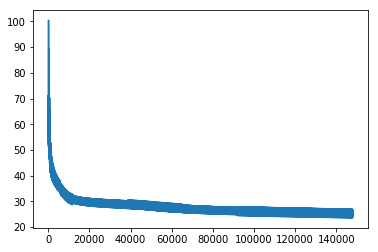

INFO - [211] training...
100%|██████████| 266/266 [00:26<00:00, 12.55it/s]
INFO - [211] training loss:24.901140213012695
INFO - [212] training...
100%|██████████| 266/266 [00:25<00:00,  8.75it/s]
INFO - [212] training loss:24.895978927612305
INFO - [213] training...
100%|██████████| 266/266 [00:25<00:00, 10.48it/s]
INFO - [213] training loss:24.89082908630371
INFO - [214] training...
100%|██████████| 266/266 [00:27<00:00,  9.77it/s]
INFO - [214] training loss:24.88567543029785
INFO - [215] training...
100%|██████████| 266/266 [00:27<00:00,  9.71it/s]
INFO - [215] training loss:24.880535125732422
INFO - [216] training...
100%|██████████| 266/266 [00:28<00:00,  9.52it/s]
INFO - [216] training loss:24.87540054321289
INFO - [217] training...
100%|██████████| 266/266 [00:26<00:00, 10.33it/s]
INFO - [217] training loss:24.870267868041992
INFO - [218] training...
100%|██████████| 266/266 [00:25<00:00, 10.30it/s]
INFO - [218] training loss:24.865144729614258
INFO - [219] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 124.10it/s]INFO - [220] test loss:25.396766662597656

100%|██████████| 14/14 [00:00<00:00, 227.42it/s]INFO - [220] test loss:24.225200653076172

100%|██████████| 15/15 [00:00<00:00, 134.32it/s]INFO - [220] test loss:24.807085037231445

100%|██████████| 15/15 [00:00<00:00, 212.32it/s]INFO - [220] test loss:24.632184982299805

100%|██████████| 14/14 [00:00<00:00, 215.65it/s]INFO - [220] test loss:25.089324951171875

100%|██████████| 15/15 [00:00<00:00, 216.85it/s]INFO - [220] test loss:24.972143173217773

100%|██████████| 15/15 [00:00<00:00, 200.61it/s]INFO - [220] test loss:24.13825035095215

100%|██████████| 14/14 [00:00<00:00, 125.61it/s]INFO - [220] test loss:23.890607833862305

100%|██████████| 15/15 [00:00<00:00, 217.67it/s]INFO - [220] test loss:24.759063720703125

100%|██████████| 16/16 [00:00<00:00, 217.14it/s]INFO - [220] test loss:25.534900665283203

100%|██████████| 16/16 [00:00<00:00, 224.71it/s]INFO - [220] test loss:24.216753005981445



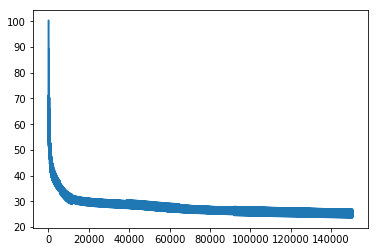

INFO - [221] training...
100%|██████████| 266/266 [00:26<00:00,  9.99it/s]
INFO - [221] training loss:24.84978485107422
INFO - [222] training...
100%|██████████| 266/266 [00:27<00:00,  9.84it/s]
INFO - [222] training loss:24.84467315673828
INFO - [223] training...
100%|██████████| 266/266 [00:26<00:00,  9.58it/s]
INFO - [223] training loss:24.839567184448242
INFO - [224] training...
100%|██████████| 266/266 [00:27<00:00,  9.73it/s]
INFO - [224] training loss:24.834463119506836
INFO - [225] training...
100%|██████████| 266/266 [00:27<00:00,  9.56it/s]
INFO - [225] training loss:24.82935905456543
INFO - [226] training...
100%|██████████| 266/266 [00:27<00:00, 10.01it/s]
INFO - [226] training loss:24.82425880432129
INFO - [227] training...
100%|██████████| 266/266 [00:25<00:00, 10.63it/s]
INFO - [227] training loss:24.819162368774414
INFO - [228] training...
100%|██████████| 266/266 [00:25<00:00, 10.59it/s]
INFO - [228] training loss:24.814058303833008
INFO - [229] training...
100%|██████

100%|██████████| 15/15 [00:00<00:00, 224.99it/s]INFO - [230] test loss:25.392776489257812

100%|██████████| 22/22 [00:00<00:00, 231.66it/s]INFO - [230] test loss:24.938732147216797

100%|██████████| 14/14 [00:00<00:00, 228.35it/s]INFO - [230] test loss:25.05948829650879

100%|██████████| 19/19 [00:00<00:00, 228.31it/s]INFO - [230] test loss:25.324298858642578

100%|██████████| 23/23 [00:00<00:00, 202.46it/s]INFO - [230] test loss:25.158374786376953

100%|██████████| 15/15 [00:00<00:00, 220.35it/s]INFO - [230] test loss:24.51315689086914

100%|██████████| 16/16 [00:00<00:00, 202.63it/s]INFO - [230] test loss:25.060619354248047

100%|██████████| 16/16 [00:00<00:00, 216.23it/s]INFO - [230] test loss:25.63629722595215

100%|██████████| 18/18 [00:00<00:00, 223.70it/s]INFO - [230] test loss:25.19281005859375

100%|██████████| 18/18 [00:00<00:00, 222.14it/s]INFO - [230] test loss:25.998519897460938

100%|██████████| 16/16 [00:00<00:00, 223.11it/s]INFO - [230] test loss:24.795331954956055

100

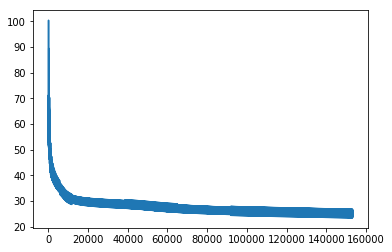

INFO - [231] training...
100%|██████████| 266/266 [00:26<00:00, 10.16it/s]
INFO - [231] training loss:24.798770904541016
INFO - [232] training...
100%|██████████| 266/266 [00:27<00:00,  9.41it/s]
INFO - [232] training loss:24.793676376342773
INFO - [233] training...
100%|██████████| 266/266 [00:27<00:00,  9.63it/s]
INFO - [233] training loss:24.788576126098633
INFO - [234] training...
100%|██████████| 266/266 [00:28<00:00,  8.05it/s]
INFO - [234] training loss:24.78347396850586
INFO - [235] training...
100%|██████████| 266/266 [00:27<00:00,  9.24it/s]
INFO - [235] training loss:24.778364181518555
INFO - [236] training...
100%|██████████| 266/266 [00:26<00:00,  9.95it/s]
INFO - [236] training loss:24.77326011657715
INFO - [237] training...
100%|██████████| 266/266 [00:27<00:00,  9.62it/s]
INFO - [237] training loss:24.768150329589844
INFO - [238] training...
100%|██████████| 266/266 [00:26<00:00,  9.74it/s]
INFO - [238] training loss:24.763032913208008
INFO - [239] training...
100%|████


100%|██████████| 14/14 [00:00<00:00, 223.57it/s]INFO - [240] test loss:24.123403549194336

100%|██████████| 15/15 [00:00<00:00, 222.25it/s]INFO - [240] test loss:24.712936401367188

100%|██████████| 15/15 [00:00<00:00, 223.06it/s]INFO - [240] test loss:24.529563903808594

100%|██████████| 14/14 [00:00<00:00, 224.61it/s]INFO - [240] test loss:24.99924087524414

100%|██████████| 23/23 [00:00<00:00, 224.21it/s]
INFO - [240] test loss:25.108078002929688
100%|██████████| 15/15 [00:00<00:00, 214.80it/s]INFO - [240] test loss:24.864717483520508

100%|██████████| 15/15 [00:00<00:00, 223.13it/s]INFO - [240] test loss:24.038707733154297

100%|██████████| 14/14 [00:00<00:00, 223.61it/s]INFO - [240] test loss:23.800832748413086

100%|██████████| 15/15 [00:00<00:00, 226.69it/s]INFO - [240] test loss:24.66967010498047

100%|██████████| 16/16 [00:00<00:00, 223.64it/s]INFO - [240] test loss:25.43910026550293

100%|██████████| 16/16 [00:00<00:00, 219.62it/s]INFO - [240] test loss:24.129135131835938

1

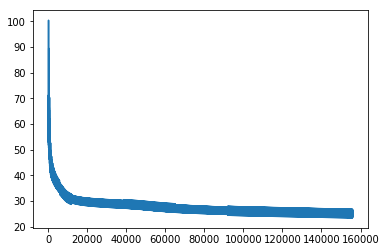

INFO - [241] training...
100%|██████████| 266/266 [00:25<00:00,  9.89it/s]
INFO - [241] training loss:24.747657775878906
INFO - [242] training...
100%|██████████| 266/266 [00:28<00:00,  9.56it/s]
INFO - [242] training loss:24.742521286010742
INFO - [243] training...
100%|██████████| 266/266 [00:21<00:00, 12.29it/s]
INFO - [243] training loss:24.73737144470215
INFO - [244] training...
100%|██████████| 266/266 [00:27<00:00,  7.95it/s]
INFO - [244] training loss:24.732229232788086
INFO - [245] training...
100%|██████████| 266/266 [00:23<00:00, 11.34it/s]
INFO - [245] training loss:24.727073669433594
INFO - [246] training...
100%|██████████| 266/266 [00:26<00:00,  9.33it/s]
INFO - [246] training loss:24.721914291381836
INFO - [247] training...
100%|██████████| 266/266 [00:27<00:00,  9.58it/s]
INFO - [247] training loss:24.716747283935547
INFO - [248] training...
100%|██████████| 266/266 [00:27<00:00,  8.22it/s]
INFO - [248] training loss:24.711576461791992
INFO - [249] training...
100%|███

100%|██████████| 14/14 [00:00<00:00, 225.64it/s]INFO - [250] test loss:24.071285247802734

100%|██████████| 15/15 [00:00<00:00, 136.44it/s]INFO - [250] test loss:24.66462516784668

100%|██████████| 15/15 [00:00<00:00, 212.73it/s]INFO - [250] test loss:24.479251861572266

100%|██████████| 14/14 [00:00<00:00, 202.08it/s]INFO - [250] test loss:24.95503807067871

100%|██████████| 15/15 [00:00<00:00, 211.28it/s]INFO - [250] test loss:24.811279296875

100%|██████████| 15/15 [00:00<00:00, 213.09it/s]INFO - [250] test loss:23.985685348510742

100%|██████████| 14/14 [00:00<00:00, 213.48it/s]INFO - [250] test loss:23.754302978515625

100%|██████████| 15/15 [00:00<00:00, 225.77it/s]INFO - [250] test loss:24.626253128051758

100%|██████████| 16/16 [00:00<00:00, 224.43it/s]INFO - [250] test loss:25.391010284423828

100%|██████████| 16/16 [00:00<00:00, 226.41it/s]INFO - [250] test loss:24.08514976501465

100%|██████████| 16/16 [00:00<00:00, 225.10it/s]INFO - [250] test loss:25.26438331604004

100%|█

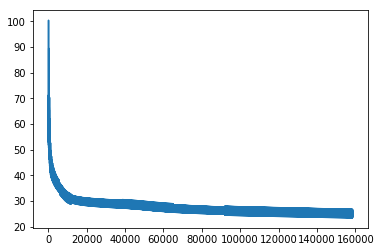

INFO - [251] training...
100%|██████████| 266/266 [00:24<00:00,  9.81it/s]
INFO - [251] training loss:24.696041107177734
INFO - [252] training...
100%|██████████| 266/266 [00:27<00:00,  9.63it/s]
INFO - [252] training loss:24.69085121154785
INFO - [253] training...
100%|██████████| 266/266 [00:28<00:00,  9.43it/s]
INFO - [253] training loss:24.6856632232666
INFO - [254] training...
100%|██████████| 266/266 [00:25<00:00, 10.49it/s]
INFO - [254] training loss:24.680471420288086
INFO - [255] training...
100%|██████████| 266/266 [00:27<00:00,  7.08it/s]
INFO - [255] training loss:24.67527961730957
INFO - [256] training...
100%|██████████| 266/266 [00:27<00:00,  9.79it/s]
INFO - [256] training loss:24.670085906982422
INFO - [257] training...
100%|██████████| 266/266 [00:27<00:00,  9.61it/s]
INFO - [257] training loss:24.664886474609375
INFO - [258] training...
100%|██████████| 266/266 [00:27<00:00,  9.84it/s]
INFO - [258] training loss:24.659687042236328
INFO - [259] training...
100%|██████


100%|██████████| 14/14 [00:00<00:00, 228.56it/s]INFO - [260] test loss:24.019290924072266

100%|██████████| 15/15 [00:00<00:00, 225.76it/s]INFO - [260] test loss:24.61617660522461

100%|██████████| 15/15 [00:00<00:00, 235.37it/s]INFO - [260] test loss:24.429832458496094

100%|██████████| 14/14 [00:00<00:00, 201.33it/s]INFO - [260] test loss:24.911151885986328

100%|██████████| 15/15 [00:00<00:00, 204.03it/s]INFO - [260] test loss:24.758647918701172

100%|██████████| 15/15 [00:00<00:00, 213.96it/s]INFO - [260] test loss:23.931657791137695

100%|██████████| 14/14 [00:00<00:00, 134.78it/s]
INFO - [260] test loss:23.707231521606445

100%|██████████| 15/15 [00:00<00:00, 215.14it/s]INFO - [260] test loss:24.58331298828125

100%|██████████| 16/16 [00:00<00:00, 222.65it/s]INFO - [260] test loss:25.342573165893555

100%|██████████| 16/16 [00:00<00:00, 148.56it/s]INFO - [260] test loss:24.041017532348633

100%|██████████| 16/16 [00:00<00:00, 147.60it/s]INFO - [260] test loss:25.215625762939453


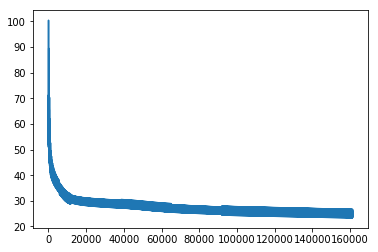

INFO - [261] training...
100%|██████████| 266/266 [00:24<00:00,  9.84it/s]
INFO - [261] training loss:24.644092559814453
INFO - [262] training...
100%|██████████| 266/266 [00:28<00:00,  8.45it/s]
INFO - [262] training loss:24.638893127441406
INFO - [263] training...
100%|██████████| 266/266 [00:27<00:00,  8.22it/s]
INFO - [263] training loss:24.63369369506836
INFO - [264] training...
100%|██████████| 266/266 [00:27<00:00,  9.83it/s]
INFO - [264] training loss:24.628494262695312
INFO - [265] training...
100%|██████████| 266/266 [00:27<00:00,  8.53it/s]
INFO - [265] training loss:24.623289108276367
INFO - [266] training...
100%|██████████| 266/266 [00:22<00:00, 12.67it/s]
INFO - [266] training loss:24.618085861206055
INFO - [267] training...
100%|██████████| 266/266 [00:27<00:00, 10.13it/s]
INFO - [267] training loss:24.612882614135742
INFO - [268] training...
100%|██████████| 266/266 [00:26<00:00, 10.19it/s]
INFO - [268] training loss:24.60767364501953
INFO - [269] training...
100%|████

100%|██████████| 16/16 [00:00<00:00, 215.03it/s]INFO - [270] test loss:25.16879653930664

100%|██████████| 14/14 [00:00<00:00, 207.43it/s]INFO - [270] test loss:23.968507766723633

100%|██████████| 15/15 [00:00<00:00, 202.83it/s]INFO - [270] test loss:24.56806182861328

100%|██████████| 15/15 [00:00<00:00, 204.80it/s]INFO - [270] test loss:24.38088607788086

100%|██████████| 14/14 [00:00<00:00, 207.21it/s]INFO - [270] test loss:24.866792678833008

100%|██████████| 15/15 [00:00<00:00, 202.51it/s]INFO - [270] test loss:24.706893920898438

100%|██████████| 15/15 [00:00<00:00, 214.45it/s]INFO - [270] test loss:23.878347396850586

100%|██████████| 14/14 [00:00<00:00, 207.20it/s]INFO - [270] test loss:23.66051483154297

100%|██████████| 15/15 [00:00<00:00, 193.45it/s]INFO - [270] test loss:24.540550231933594

100%|██████████| 16/16 [00:00<00:00, 212.77it/s]INFO - [270] test loss:25.293731689453125

100%|██████████| 16/16 [00:00<00:00, 221.58it/s]INFO - [270] test loss:23.99652671813965

100%

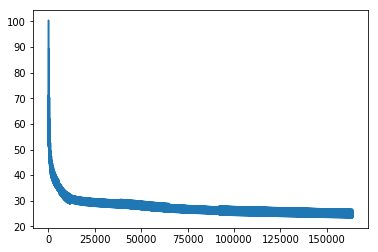

INFO - [271] training...
100%|██████████| 266/266 [00:28<00:00,  7.72it/s]
INFO - [271] training loss:24.592044830322266
INFO - [272] training...
100%|██████████| 266/266 [00:28<00:00,  7.83it/s]
INFO - [272] training loss:24.586830139160156
INFO - [273] training...
100%|██████████| 266/266 [00:28<00:00,  9.38it/s]
INFO - [273] training loss:24.58160972595215
INFO - [274] training...
100%|██████████| 266/266 [00:29<00:00,  9.39it/s]
INFO - [274] training loss:24.576391220092773
INFO - [275] training...
100%|██████████| 266/266 [00:30<00:00,  9.29it/s]
INFO - [275] training loss:24.571163177490234
INFO - [276] training...
100%|██████████| 266/266 [00:29<00:00,  9.15it/s]
INFO - [276] training loss:24.565937042236328
INFO - [277] training...
100%|██████████| 266/266 [00:29<00:00,  8.22it/s]
INFO - [277] training loss:24.56070899963379
INFO - [278] training...
100%|██████████| 266/266 [00:30<00:00,  7.86it/s]
INFO - [278] training loss:24.55547523498535
INFO - [279] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 220.41it/s]INFO - [280] test loss:25.121196746826172

100%|██████████| 14/14 [00:00<00:00, 218.87it/s]INFO - [280] test loss:23.918739318847656

100%|██████████| 22/22 [00:00<00:00, 214.96it/s]
INFO - [280] test loss:24.790481567382812
100%|██████████| 15/15 [00:00<00:00, 153.08it/s]INFO - [280] test loss:24.519887924194336

100%|██████████| 15/15 [00:00<00:00, 137.81it/s]INFO - [280] test loss:24.331905364990234

100%|██████████| 14/14 [00:00<00:00, 222.81it/s]INFO - [280] test loss:24.8211669921875

100%|██████████| 23/23 [00:00<00:00, 222.45it/s]
INFO - [280] test loss:24.901046752929688
100%|██████████| 15/15 [00:00<00:00, 190.76it/s]INFO - [280] test loss:24.655569076538086

100%|██████████| 15/15 [00:00<00:00, 216.98it/s]INFO - [280] test loss:23.825586318969727

100%|██████████| 14/14 [00:00<00:00, 203.02it/s]INFO - [280] test loss:23.613962173461914

100%|██████████| 15/15 [00:00<00:00, 211.56it/s]INFO - [280] test loss:24.497760772705078

1

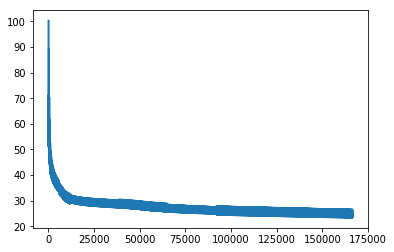

INFO - [281] training...
100%|██████████| 266/266 [00:27<00:00,  9.72it/s]
INFO - [281] training loss:24.53976058959961
INFO - [282] training...
100%|██████████| 266/266 [00:27<00:00,  9.60it/s]
INFO - [282] training loss:24.534515380859375
INFO - [283] training...
100%|██████████| 266/266 [00:27<00:00,  9.73it/s]
INFO - [283] training loss:24.529264450073242
INFO - [284] training...
100%|██████████| 266/266 [00:28<00:00,  8.72it/s]
INFO - [284] training loss:24.52400779724121
INFO - [285] training...
100%|██████████| 266/266 [00:28<00:00,  8.21it/s]
INFO - [285] training loss:24.518754959106445
INFO - [286] training...
100%|██████████| 266/266 [00:28<00:00,  9.54it/s]
INFO - [286] training loss:24.513490676879883
INFO - [287] training...
100%|██████████| 266/266 [00:28<00:00,  9.25it/s]
INFO - [287] training loss:24.508224487304688
INFO - [288] training...
100%|██████████| 266/266 [00:27<00:00, 10.32it/s]
INFO - [288] training loss:24.502958297729492
INFO - [289] training...
100%|████

100%|██████████| 15/15 [00:00<00:00, 218.59it/s]INFO - [290] test loss:25.059066772460938

100%|██████████| 22/22 [00:00<00:00, 226.53it/s]INFO - [290] test loss:24.757652282714844

100%|██████████| 14/14 [00:00<00:00, 219.44it/s]INFO - [290] test loss:24.751550674438477

100%|██████████| 19/19 [00:00<00:00, 226.87it/s]INFO - [290] test loss:25.0117130279541

100%|██████████| 23/23 [00:00<00:00, 230.42it/s]INFO - [290] test loss:24.850242614746094

100%|██████████| 15/15 [00:00<00:00, 213.99it/s]INFO - [290] test loss:24.223201751708984

100%|██████████| 16/16 [00:00<00:00, 208.66it/s]INFO - [290] test loss:24.745010375976562

100%|██████████| 16/16 [00:00<00:00, 230.28it/s]INFO - [290] test loss:25.314922332763672

100%|██████████| 18/18 [00:00<00:00, 229.48it/s]INFO - [290] test loss:24.91615867614746

100%|██████████| 18/18 [00:00<00:00, 223.63it/s]INFO - [290] test loss:25.660432815551758

100%|██████████| 16/16 [00:00<00:00, 229.03it/s]INFO - [290] test loss:24.526493072509766

10

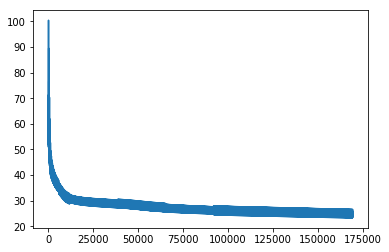

INFO - [291] training...
100%|██████████| 266/266 [00:22<00:00, 11.57it/s]
INFO - [291] training loss:24.48713493347168
INFO - [292] training...
100%|██████████| 266/266 [00:24<00:00,  8.96it/s]
INFO - [292] training loss:24.481849670410156
INFO - [293] training...
100%|██████████| 266/266 [00:21<00:00, 12.22it/s]
INFO - [293] training loss:24.476564407348633
INFO - [294] training...
100%|██████████| 266/266 [00:20<00:00, 12.57it/s]
INFO - [294] training loss:24.471275329589844
INFO - [295] training...
100%|██████████| 266/266 [00:25<00:00, 10.24it/s]
INFO - [295] training loss:24.465978622436523
INFO - [296] training...
100%|██████████| 266/266 [00:25<00:00, 10.61it/s]
INFO - [296] training loss:24.46068572998047
INFO - [297] training...
100%|██████████| 266/266 [00:26<00:00,  9.87it/s]
INFO - [297] training loss:24.455385208129883
INFO - [298] training...
100%|██████████| 266/266 [00:23<00:00, 12.48it/s]
INFO - [298] training loss:24.450082778930664
INFO - [299] training...
100%|████

100%|██████████| 15/15 [00:00<00:00, 217.82it/s]INFO - [300] test loss:25.00459861755371

100%|██████████| 22/22 [00:00<00:00, 232.78it/s]INFO - [300] test loss:24.723182678222656

100%|██████████| 14/14 [00:00<00:00, 228.71it/s]INFO - [300] test loss:24.700162887573242

100%|██████████| 19/19 [00:00<00:00, 226.71it/s]INFO - [300] test loss:24.960580825805664

100%|██████████| 23/23 [00:00<00:00, 234.77it/s]INFO - [300] test loss:24.79941177368164

100%|██████████| 15/15 [00:00<00:00, 226.07it/s]INFO - [300] test loss:24.174190521240234

100%|██████████| 16/16 [00:00<00:00, 224.34it/s]INFO - [300] test loss:24.689697265625

100%|██████████| 16/16 [00:00<00:00, 221.87it/s]INFO - [300] test loss:25.262737274169922

100%|██████████| 18/18 [00:00<00:00, 230.82it/s]INFO - [300] test loss:24.870012283325195

100%|██████████| 18/18 [00:00<00:00, 227.66it/s]INFO - [300] test loss:25.602062225341797

100%|██████████| 16/16 [00:00<00:00, 229.29it/s]INFO - [300] test loss:24.48070526123047

100%|

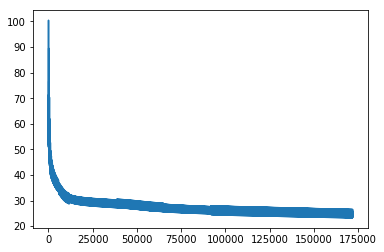

INFO - [301] training...
100%|██████████| 266/266 [00:27<00:00,  9.78it/s]
INFO - [301] training loss:24.434158325195312
INFO - [302] training...
100%|██████████| 266/266 [00:26<00:00,  8.51it/s]
INFO - [302] training loss:24.42884063720703
INFO - [303] training...
100%|██████████| 266/266 [00:27<00:00,  9.56it/s]
INFO - [303] training loss:24.42352294921875
INFO - [304] training...
100%|██████████| 266/266 [00:25<00:00, 10.18it/s]
INFO - [304] training loss:24.418203353881836
INFO - [305] training...
100%|██████████| 266/266 [00:27<00:00, 11.13it/s]
INFO - [305] training loss:24.41288185119629
INFO - [306] training...
100%|██████████| 266/266 [00:21<00:00, 11.89it/s]
INFO - [306] training loss:24.40755844116211
INFO - [307] training...
100%|██████████| 266/266 [00:26<00:00,  9.71it/s]
INFO - [307] training loss:24.4022274017334
INFO - [308] training...
100%|██████████| 266/266 [00:27<00:00,  9.90it/s]
INFO - [308] training loss:24.39689826965332
INFO - [309] training...
100%|█████████

100%|██████████| 16/16 [00:00<00:00, 213.70it/s]INFO - [310] test loss:24.97382354736328

100%|██████████| 14/14 [00:00<00:00, 151.27it/s]INFO - [310] test loss:23.77155876159668

100%|██████████| 15/15 [00:00<00:00, 219.67it/s]INFO - [310] test loss:24.372533798217773

100%|██████████| 15/15 [00:00<00:00, 200.51it/s]INFO - [310] test loss:24.184158325195312

100%|██████████| 14/14 [00:00<00:00, 215.25it/s]INFO - [310] test loss:24.675792694091797

100%|██████████| 15/15 [00:00<00:00, 217.15it/s]INFO - [310] test loss:24.50235939025879

100%|██████████| 15/15 [00:00<00:00, 215.60it/s]INFO - [310] test loss:23.666366577148438

100%|██████████| 14/14 [00:00<00:00, 213.81it/s]INFO - [310] test loss:23.47189712524414

100%|██████████| 15/15 [00:00<00:00, 228.18it/s]INFO - [310] test loss:24.368478775024414

100%|██████████| 16/16 [00:00<00:00, 224.32it/s]INFO - [310] test loss:25.092275619506836

100%|██████████| 16/16 [00:00<00:00, 221.66it/s]INFO - [310] test loss:23.81121826171875

100%

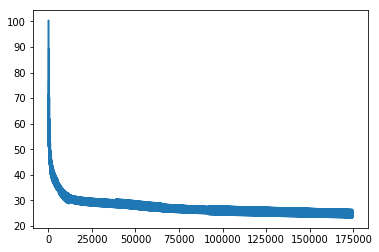

INFO - [311] training...
100%|██████████| 266/266 [00:23<00:00,  7.82it/s]
INFO - [311] training loss:24.380891799926758
INFO - [312] training...
100%|██████████| 266/266 [00:23<00:00, 11.36it/s]
INFO - [312] training loss:24.375553131103516
INFO - [313] training...
100%|██████████| 266/266 [00:27<00:00, 10.95it/s]
INFO - [313] training loss:24.370214462280273
INFO - [314] training...
100%|██████████| 266/266 [00:27<00:00,  9.51it/s]
INFO - [314] training loss:24.364866256713867
INFO - [315] training...
100%|██████████| 266/266 [00:27<00:00,  9.75it/s]
INFO - [315] training loss:24.359521865844727
INFO - [316] training...
100%|██████████| 266/266 [00:26<00:00, 10.75it/s]
INFO - [316] training loss:24.354171752929688
INFO - [317] training...
100%|██████████| 266/266 [00:26<00:00, 10.12it/s]
INFO - [317] training loss:24.34882354736328
INFO - [318] training...
100%|██████████| 266/266 [00:28<00:00,  9.15it/s]
INFO - [318] training loss:24.343475341796875
INFO - [319] training...
100%|███

100%|██████████| 16/16 [00:00<00:00, 210.55it/s]INFO - [320] test loss:24.92328453063965

100%|██████████| 14/14 [00:00<00:00, 224.33it/s]INFO - [320] test loss:23.722761154174805

100%|██████████| 15/15 [00:00<00:00, 222.91it/s]INFO - [320] test loss:24.32234764099121

100%|██████████| 15/15 [00:00<00:00, 222.87it/s]INFO - [320] test loss:24.134870529174805

100%|██████████| 14/14 [00:00<00:00, 222.42it/s]INFO - [320] test loss:24.624784469604492

100%|██████████| 23/23 [00:00<00:00, 228.83it/s]
INFO - [320] test loss:24.69758415222168
100%|██████████| 15/15 [00:00<00:00, 219.74it/s]INFO - [320] test loss:24.45154571533203

100%|██████████| 15/15 [00:00<00:00, 222.55it/s]INFO - [320] test loss:23.61293601989746

100%|██████████| 14/14 [00:00<00:00, 223.68it/s]INFO - [320] test loss:23.42366600036621

100%|██████████| 15/15 [00:00<00:00, 221.19it/s]INFO - [320] test loss:24.324901580810547

100%|██████████| 16/16 [00:00<00:00, 220.46it/s]INFO - [320] test loss:25.0408992767334

100%|██

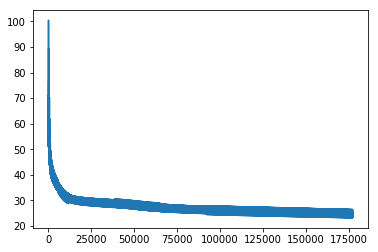

INFO - [321] training...
100%|██████████| 266/266 [00:28<00:00, 11.01it/s]
INFO - [321] training loss:24.327402114868164
INFO - [322] training...
100%|██████████| 266/266 [00:27<00:00,  9.23it/s]
INFO - [322] training loss:24.322044372558594
INFO - [323] training...
100%|██████████| 266/266 [00:27<00:00,  9.21it/s]
INFO - [323] training loss:24.316682815551758
INFO - [324] training...
100%|██████████| 266/266 [00:27<00:00,  9.72it/s]
INFO - [324] training loss:24.311315536499023
INFO - [325] training...
100%|██████████| 266/266 [00:25<00:00, 10.62it/s]
INFO - [325] training loss:24.30594253540039
INFO - [326] training...
100%|██████████| 266/266 [00:27<00:00,  9.72it/s]
INFO - [326] training loss:24.300573348999023
INFO - [327] training...
100%|██████████| 266/266 [00:26<00:00,  8.87it/s]
INFO - [327] training loss:24.29519271850586
INFO - [328] training...
100%|██████████| 266/266 [00:27<00:00,  8.54it/s]
INFO - [328] training loss:24.289810180664062
INFO - [329] training...
100%|████


100%|██████████| 14/14 [00:00<00:00, 216.73it/s]INFO - [330] test loss:23.673654556274414

100%|██████████| 15/15 [00:00<00:00, 219.53it/s]INFO - [330] test loss:24.2713565826416

100%|██████████| 15/15 [00:00<00:00, 218.53it/s]INFO - [330] test loss:24.085668563842773

100%|██████████| 14/14 [00:00<00:00, 213.97it/s]INFO - [330] test loss:24.57236671447754

100%|██████████| 23/23 [00:00<00:00, 220.39it/s]
INFO - [330] test loss:24.646499633789062
100%|██████████| 15/15 [00:00<00:00, 207.40it/s]INFO - [330] test loss:24.400901794433594

100%|██████████| 15/15 [00:00<00:00, 162.82it/s]INFO - [330] test loss:23.55913734436035

100%|██████████| 14/14 [00:00<00:00, 191.20it/s]INFO - [330] test loss:23.37518310546875

100%|██████████| 15/15 [00:00<00:00, 211.21it/s]INFO - [330] test loss:24.280899047851562

100%|██████████| 16/16 [00:00<00:00, 112.02it/s]INFO - [330] test loss:24.989185333251953

100%|██████████| 16/16 [00:00<00:00, 170.02it/s]INFO - [330] test loss:23.716392517089844

100

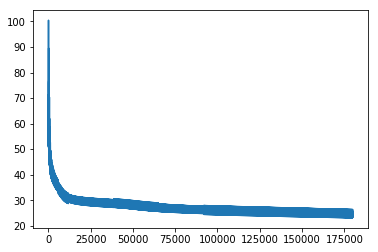

INFO - [331] training...
100%|██████████| 266/266 [00:24<00:00, 10.83it/s]
INFO - [331] training loss:24.273635864257812
INFO - [332] training...
100%|██████████| 266/266 [00:23<00:00,  9.51it/s]
INFO - [332] training loss:24.268230438232422
INFO - [333] training...
100%|██████████| 266/266 [00:26<00:00, 10.01it/s]
INFO - [333] training loss:24.2628173828125
INFO - [334] training...
100%|██████████| 266/266 [00:22<00:00, 11.69it/s]
INFO - [334] training loss:24.25739288330078
INFO - [335] training...
100%|██████████| 266/266 [00:27<00:00, 10.00it/s]
INFO - [335] training loss:24.251962661743164
INFO - [336] training...
100%|██████████| 266/266 [00:26<00:00,  9.92it/s]
INFO - [336] training loss:24.246522903442383
INFO - [337] training...
100%|██████████| 266/266 [00:28<00:00, 10.49it/s]
INFO - [337] training loss:24.241064071655273
INFO - [338] training...
100%|██████████| 266/266 [00:26<00:00, 10.29it/s]
INFO - [338] training loss:24.235591888427734
INFO - [339] training...
100%|█████

100%|██████████| 14/14 [00:00<00:00, 133.60it/s]
INFO - [340] test loss:24.091968536376953
100%|██████████| 14/14 [00:00<00:00, 147.18it/s]INFO - [340] test loss:23.816667556762695

100%|██████████| 15/15 [00:00<00:00, 162.64it/s]INFO - [340] test loss:24.218647003173828

100%|██████████| 14/14 [00:00<00:00, 134.35it/s]
INFO - [340] test loss:24.49553108215332
100%|██████████| 16/16 [00:00<00:00, 203.06it/s]INFO - [340] test loss:23.66875648498535

100%|██████████| 16/16 [00:00<00:00, 212.19it/s]INFO - [340] test loss:24.809782028198242

100%|██████████| 16/16 [00:00<00:00, 219.21it/s]INFO - [340] test loss:24.250391006469727

100%|██████████| 16/16 [00:00<00:00, 218.07it/s]INFO - [340] test loss:23.971405029296875

100%|██████████| 16/16 [00:00<00:00, 213.35it/s]INFO - [340] test loss:24.500324249267578

100%|██████████| 15/15 [00:00<00:00, 224.24it/s]INFO - [340] test loss:24.063623428344727

100%|██████████| 17/17 [00:00<00:00, 225.98it/s]INFO - [340] test loss:24.89557456970215


100%|██████████| 15/15 [00:00<00:00, 223.03it/s]INFO - [340] test loss:24.528650283813477

100%|██████████| 18/18 [00:00<00:00, 226.65it/s]INFO - [340] test loss:25.695627212524414

100%|██████████| 15/15 [00:00<00:00, 224.20it/s]INFO - [340] test loss:23.573579788208008

100%|██████████| 66/66 [00:07<00:00, 12.83it/s]
INFO - [340] loss: 0.19079732353037054; accuracy:0.07023725628376791


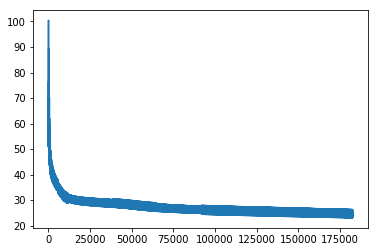

INFO - [341] training...
100%|██████████| 266/266 [00:24<00:00, 10.40it/s]
INFO - [341] training loss:24.219093322753906
INFO - [342] training...
100%|██████████| 266/266 [00:25<00:00, 10.00it/s]
INFO - [342] training loss:24.213560104370117
INFO - [343] training...
100%|██████████| 266/266 [00:28<00:00, 11.47it/s]
INFO - [343] training loss:24.208003997802734
INFO - [344] training...
100%|██████████| 266/266 [00:24<00:00,  8.81it/s]
INFO - [344] training loss:24.202430725097656
INFO - [345] training...
100%|██████████| 266/266 [00:24<00:00, 10.94it/s]
INFO - [345] training loss:24.196840286254883
INFO - [346] training...
100%|██████████| 266/266 [00:27<00:00,  9.45it/s]
INFO - [346] training loss:24.191242218017578
INFO - [347] training...
100%|██████████| 266/266 [00:28<00:00,  8.90it/s]
INFO - [347] training loss:24.185626983642578
INFO - [348] training...
100%|██████████| 266/266 [00:30<00:00,  9.29it/s]
INFO - [348] training loss:24.18000030517578
INFO - [349] training...
100%|███

100%|██████████| 16/16 [00:00<00:00, 226.99it/s]INFO - [350] test loss:24.761722564697266

100%|██████████| 14/14 [00:00<00:00, 216.14it/s]INFO - [350] test loss:23.569564819335938

100%|██████████| 22/22 [00:00<00:00, 218.71it/s]
INFO - [350] test loss:24.513996124267578
100%|██████████| 15/15 [00:00<00:00, 207.46it/s]INFO - [350] test loss:24.163076400756836

100%|██████████| 15/15 [00:00<00:00, 215.53it/s]INFO - [350] test loss:23.987504959106445

100%|██████████| 14/14 [00:00<00:00, 210.94it/s]INFO - [350] test loss:24.458715438842773

100%|██████████| 23/23 [00:00<00:00, 224.10it/s]
INFO - [350] test loss:24.541179656982422
100%|██████████| 15/15 [00:00<00:00, 221.96it/s]INFO - [350] test loss:24.29996681213379

100%|██████████| 15/15 [00:00<00:00, 220.97it/s]INFO - [350] test loss:23.445871353149414

100%|██████████| 14/14 [00:00<00:00, 220.77it/s]INFO - [350] test loss:23.278751373291016

100%|██████████| 15/15 [00:00<00:00, 188.29it/s]INFO - [350] test loss:24.188127517700195



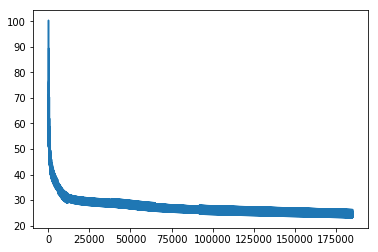

INFO - [351] training...
100%|██████████| 266/266 [00:28<00:00,  9.68it/s]
INFO - [351] training loss:24.163171768188477
INFO - [352] training...
100%|██████████| 266/266 [00:28<00:00,  9.47it/s]
INFO - [352] training loss:24.157596588134766
INFO - [353] training...
100%|██████████| 266/266 [00:27<00:00,  9.60it/s]
INFO - [353] training loss:24.152057647705078
INFO - [354] training...
100%|██████████| 266/266 [00:28<00:00,  9.37it/s]
INFO - [354] training loss:24.146560668945312
INFO - [355] training...
100%|██████████| 266/266 [00:26<00:00,  9.22it/s]
INFO - [355] training loss:24.141117095947266
INFO - [356] training...
100%|██████████| 266/266 [00:28<00:00,  9.95it/s]
INFO - [356] training loss:24.135713577270508
INFO - [357] training...
100%|██████████| 266/266 [00:26<00:00,  9.28it/s]
INFO - [357] training loss:24.130361557006836
INFO - [358] training...
100%|██████████| 266/266 [00:27<00:00,  8.20it/s]
INFO - [358] training loss:24.125062942504883
INFO - [359] training...
100%|██


100%|██████████| 14/14 [00:00<00:00, 160.49it/s]INFO - [360] test loss:23.518600463867188

100%|██████████| 22/22 [00:00<00:00, 212.29it/s]
INFO - [360] test loss:24.458545684814453
100%|██████████| 15/15 [00:00<00:00, 221.49it/s]INFO - [360] test loss:24.110383987426758

100%|██████████| 15/15 [00:00<00:00, 221.11it/s]INFO - [360] test loss:23.939794540405273

100%|██████████| 14/14 [00:00<00:00, 217.85it/s]INFO - [360] test loss:24.40043830871582

100%|██████████| 23/23 [00:00<00:00, 220.94it/s]
INFO - [360] test loss:24.488628387451172
100%|██████████| 15/15 [00:00<00:00, 217.59it/s]INFO - [360] test loss:24.251516342163086

100%|██████████| 15/15 [00:00<00:00, 218.65it/s]INFO - [360] test loss:23.39171600341797

100%|██████████| 14/14 [00:00<00:00, 224.33it/s]INFO - [360] test loss:23.23521614074707

100%|██████████| 15/15 [00:00<00:00, 231.83it/s]INFO - [360] test loss:24.138662338256836

100%|██████████| 16/16 [00:00<00:00, 228.51it/s]INFO - [360] test loss:24.83064079284668

10

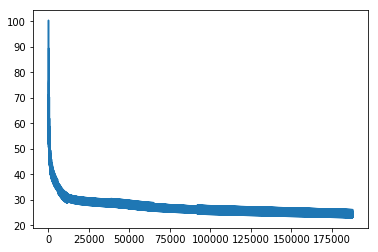

INFO - [361] training...
100%|██████████| 266/266 [00:29<00:00,  9.85it/s]
INFO - [361] training loss:24.10942268371582
INFO - [362] training...
100%|██████████| 266/266 [00:27<00:00,  9.71it/s]
INFO - [362] training loss:24.104276657104492
INFO - [363] training...
100%|██████████| 266/266 [00:27<00:00,  8.79it/s]
INFO - [363] training loss:24.099163055419922
INFO - [364] training...
100%|██████████| 266/266 [00:24<00:00, 10.69it/s]
INFO - [364] training loss:24.09406852722168
INFO - [365] training...
100%|██████████| 266/266 [00:27<00:00,  9.07it/s]
INFO - [365] training loss:24.088991165161133
INFO - [366] training...
100%|██████████| 266/266 [00:29<00:00, 10.54it/s]
INFO - [366] training loss:24.08393096923828
INFO - [367] training...
100%|██████████| 266/266 [00:26<00:00, 10.46it/s]
INFO - [367] training loss:24.078887939453125
INFO - [368] training...
100%|██████████| 266/266 [00:23<00:00, 11.32it/s]
INFO - [368] training loss:24.073854446411133
INFO - [369] training...
100%|█████

100%|██████████| 15/15 [00:00<00:00, 222.39it/s]INFO - [370] test loss:24.643611907958984

100%|██████████| 22/22 [00:00<00:00, 233.49it/s]INFO - [370] test loss:24.41132926940918

100%|██████████| 14/14 [00:00<00:00, 227.30it/s]INFO - [370] test loss:24.349117279052734

100%|██████████| 19/19 [00:00<00:00, 226.91it/s]INFO - [370] test loss:24.58783531188965

100%|██████████| 23/23 [00:00<00:00, 221.54it/s]
INFO - [370] test loss:24.44032096862793

100%|██████████| 15/15 [00:00<00:00, 219.12it/s]INFO - [370] test loss:23.82978057861328

100%|██████████| 16/16 [00:00<00:00, 220.34it/s]INFO - [370] test loss:24.27083396911621

100%|██████████| 16/16 [00:00<00:00, 220.60it/s]INFO - [370] test loss:24.884706497192383

100%|██████████| 18/18 [00:00<00:00, 219.27it/s]INFO - [370] test loss:24.533233642578125

100%|██████████| 18/18 [00:00<00:00, 230.57it/s]INFO - [370] test loss:25.20173454284668

100%|██████████| 16/16 [00:00<00:00, 230.01it/s]INFO - [370] test loss:24.135496139526367

100%

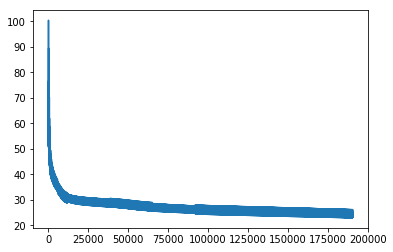

INFO - [371] training...
100%|██████████| 266/266 [00:25<00:00, 12.64it/s]
INFO - [371] training loss:24.058820724487305
INFO - [372] training...
100%|██████████| 266/266 [00:23<00:00,  9.16it/s]
INFO - [372] training loss:24.0538330078125
INFO - [373] training...
100%|██████████| 266/266 [00:26<00:00,  9.95it/s]
INFO - [373] training loss:24.04885482788086
INFO - [374] training...
100%|██████████| 266/266 [00:24<00:00,  9.94it/s]
INFO - [374] training loss:24.043882369995117
INFO - [375] training...
100%|██████████| 266/266 [00:26<00:00, 10.11it/s]
INFO - [375] training loss:24.038921356201172
INFO - [376] training...
100%|██████████| 266/266 [00:27<00:00,  8.87it/s]
INFO - [376] training loss:24.033967971801758
INFO - [377] training...
100%|██████████| 266/266 [00:27<00:00,  9.49it/s]
INFO - [377] training loss:24.029027938842773
INFO - [378] training...
100%|██████████| 266/266 [00:27<00:00,  8.74it/s]
INFO - [378] training loss:24.024091720581055
INFO - [379] training...
100%|█████


100%|██████████| 15/15 [00:00<00:00, 221.56it/s]INFO - [380] test loss:24.59602165222168

100%|██████████| 22/22 [00:00<00:00, 235.49it/s]INFO - [380] test loss:24.368982315063477

100%|██████████| 14/14 [00:00<00:00, 229.70it/s]INFO - [380] test loss:24.3043155670166

100%|██████████| 19/19 [00:00<00:00, 231.73it/s]INFO - [380] test loss:24.537538528442383

100%|██████████| 23/23 [00:00<00:00, 233.27it/s]INFO - [380] test loss:24.393638610839844

100%|██████████| 15/15 [00:00<00:00, 226.90it/s]INFO - [380] test loss:23.786901473999023

100%|██████████| 16/16 [00:00<00:00, 231.29it/s]INFO - [380] test loss:24.216909408569336

100%|██████████| 16/16 [00:00<00:00, 228.93it/s]INFO - [380] test loss:24.838123321533203

100%|██████████| 18/18 [00:00<00:00, 135.75it/s]INFO - [380] test loss:24.49067497253418

100%|██████████| 18/18 [00:00<00:00, 217.98it/s]INFO - [380] test loss:25.150449752807617

100%|██████████| 16/16 [00:00<00:00, 219.70it/s]INFO - [380] test loss:24.092357635498047

10

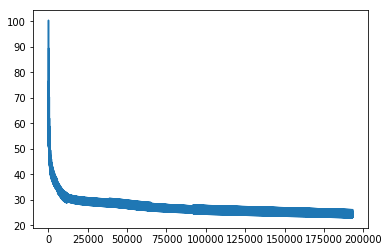

INFO - [381] training...
100%|██████████| 266/266 [00:27<00:00,  9.34it/s]
INFO - [381] training loss:24.00936508178711
INFO - [382] training...
100%|██████████| 266/266 [00:26<00:00,  9.95it/s]
INFO - [382] training loss:24.004474639892578
INFO - [383] training...
100%|██████████| 266/266 [00:27<00:00,  9.60it/s]
INFO - [383] training loss:23.99959945678711
INFO - [384] training...
100%|██████████| 266/266 [00:26<00:00,  9.34it/s]
INFO - [384] training loss:23.994731903076172
INFO - [385] training...
100%|██████████| 266/266 [00:27<00:00,  9.77it/s]
INFO - [385] training loss:23.989877700805664
INFO - [386] training...
100%|██████████| 266/266 [00:27<00:00,  9.14it/s]
INFO - [386] training loss:23.98503303527832
INFO - [387] training...
100%|██████████| 266/266 [00:26<00:00, 10.11it/s]
INFO - [387] training loss:23.98020362854004
INFO - [388] training...
100%|██████████| 266/266 [00:27<00:00,  7.74it/s]
INFO - [388] training loss:23.97538185119629
INFO - [389] training...
100%|███████

100%|██████████| 16/16 [00:00<00:00, 233.88it/s]INFO - [390] test loss:24.563682556152344

100%|██████████| 14/14 [00:00<00:00, 238.11it/s]INFO - [390] test loss:23.391447067260742

100%|██████████| 15/15 [00:00<00:00, 220.81it/s]INFO - [390] test loss:23.97730827331543

100%|██████████| 15/15 [00:00<00:00, 233.68it/s]INFO - [390] test loss:23.80109977722168

100%|██████████| 14/14 [00:00<00:00, 233.53it/s]INFO - [390] test loss:24.24962615966797

100%|██████████| 15/15 [00:00<00:00, 229.23it/s]INFO - [390] test loss:24.114065170288086

100%|██████████| 15/15 [00:00<00:00, 224.89it/s]INFO - [390] test loss:23.260305404663086

100%|██████████| 14/14 [00:00<00:00, 227.57it/s]INFO - [390] test loss:23.105390548706055

100%|██████████| 15/15 [00:00<00:00, 222.14it/s]INFO - [390] test loss:24.004199981689453

100%|██████████| 16/16 [00:00<00:00, 227.20it/s]INFO - [390] test loss:24.696929931640625

100%|██████████| 16/16 [00:00<00:00, 223.09it/s]INFO - [390] test loss:23.437761306762695

10

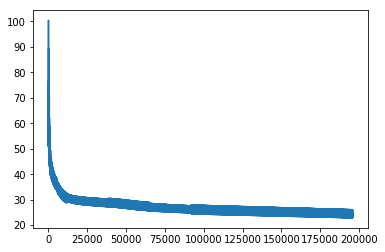

INFO - [391] training...
100%|██████████| 266/266 [00:28<00:00,  8.72it/s]
INFO - [391] training loss:23.961000442504883
INFO - [392] training...
100%|██████████| 266/266 [00:26<00:00,  9.98it/s]
INFO - [392] training loss:23.956226348876953
INFO - [393] training...
100%|██████████| 266/266 [00:21<00:00, 11.81it/s]
INFO - [393] training loss:23.951473236083984
INFO - [394] training...
100%|██████████| 266/266 [00:25<00:00, 10.43it/s]
INFO - [394] training loss:23.946725845336914
INFO - [395] training...
100%|██████████| 266/266 [00:26<00:00, 10.23it/s]
INFO - [395] training loss:23.941993713378906
INFO - [396] training...
100%|██████████| 266/266 [00:27<00:00, 10.02it/s]
INFO - [396] training loss:23.93726921081543
INFO - [397] training...
100%|██████████| 266/266 [00:26<00:00, 10.07it/s]
INFO - [397] training loss:23.93256187438965
INFO - [398] training...
100%|██████████| 266/266 [00:27<00:00,  8.00it/s]
INFO - [398] training loss:23.927867889404297
INFO - [399] training...
100%|████


100%|██████████| 14/14 [00:00<00:00, 213.77it/s]INFO - [400] test loss:23.351470947265625

100%|██████████| 22/22 [00:00<00:00, 216.53it/s]
INFO - [400] test loss:24.287981033325195
100%|██████████| 15/15 [00:00<00:00, 214.79it/s]INFO - [400] test loss:23.93491554260254

100%|██████████| 15/15 [00:00<00:00, 224.64it/s]INFO - [400] test loss:23.75711441040039

100%|██████████| 14/14 [00:00<00:00, 226.86it/s]INFO - [400] test loss:24.20192527770996

100%|██████████| 15/15 [00:00<00:00, 228.61it/s]INFO - [400] test loss:24.070375442504883

100%|██████████| 15/15 [00:00<00:00, 229.75it/s]INFO - [400] test loss:23.219938278198242

100%|██████████| 14/14 [00:00<00:00, 232.27it/s]INFO - [400] test loss:23.06192970275879

100%|██████████| 15/15 [00:00<00:00, 231.18it/s]INFO - [400] test loss:23.96254539489746

100%|██████████| 16/16 [00:00<00:00, 175.51it/s]INFO - [400] test loss:24.655017852783203

100%|██████████| 16/16 [00:00<00:00, 212.49it/s]INFO - [400] test loss:23.395442962646484

100

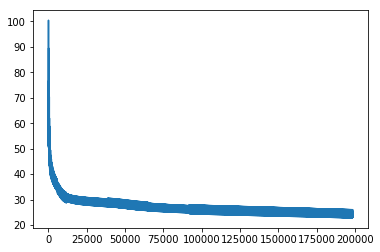

INFO - [401] training...
100%|██████████| 266/266 [00:24<00:00, 10.97it/s]
INFO - [401] training loss:23.91385841369629
INFO - [402] training...
100%|██████████| 266/266 [00:22<00:00, 11.51it/s]
INFO - [402] training loss:23.909215927124023
INFO - [403] training...
100%|██████████| 266/266 [00:25<00:00, 10.41it/s]
INFO - [403] training loss:23.904582977294922
INFO - [404] training...
100%|██████████| 266/266 [00:25<00:00, 10.29it/s]
INFO - [404] training loss:23.89996337890625
INFO - [405] training...
100%|██████████| 266/266 [00:28<00:00,  7.66it/s]
INFO - [405] training loss:23.89535903930664
INFO - [406] training...
100%|██████████| 266/266 [00:27<00:00,  9.82it/s]
INFO - [406] training loss:23.890766143798828
INFO - [407] training...
100%|██████████| 266/266 [00:27<00:00,  9.40it/s]
INFO - [407] training loss:23.886186599731445
INFO - [408] training...
100%|██████████| 266/266 [00:27<00:00,  9.52it/s]
INFO - [408] training loss:23.881616592407227
INFO - [409] training...
100%|█████


100%|██████████| 15/15 [00:00<00:00, 218.01it/s]INFO - [410] test loss:24.460786819458008

100%|██████████| 22/22 [00:00<00:00, 228.64it/s]INFO - [410] test loss:24.24843978881836

100%|██████████| 14/14 [00:00<00:00, 211.11it/s]INFO - [410] test loss:24.175537109375

100%|██████████| 19/19 [00:00<00:00, 224.29it/s]INFO - [410] test loss:24.399120330810547

100%|██████████| 23/23 [00:00<00:00, 226.90it/s]
INFO - [410] test loss:24.260160446166992

100%|██████████| 15/15 [00:00<00:00, 225.67it/s]INFO - [410] test loss:23.66343879699707

100%|██████████| 16/16 [00:00<00:00, 133.49it/s]INFO - [410] test loss:24.066373825073242

100%|██████████| 16/16 [00:00<00:00, 215.76it/s]INFO - [410] test loss:24.708749771118164

100%|██████████| 18/18 [00:00<00:00, 176.99it/s]
INFO - [410] test loss:24.36949348449707

100%|██████████| 18/18 [00:00<00:00, 216.78it/s]INFO - [410] test loss:25.004150390625

100%|██████████| 16/16 [00:00<00:00, 213.80it/s]INFO - [410] test loss:23.975929260253906

100%|

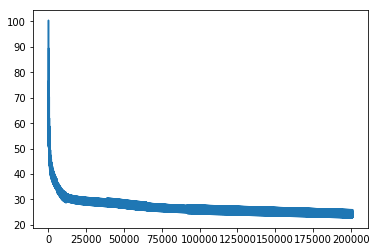

INFO - [411] training...
100%|██████████| 266/266 [00:27<00:00,  9.40it/s]
INFO - [411] training loss:23.867982864379883
INFO - [412] training...
100%|██████████| 266/266 [00:24<00:00, 10.70it/s]
INFO - [412] training loss:23.86347198486328
INFO - [413] training...
100%|██████████| 266/266 [00:26<00:00,  9.22it/s]
INFO - [413] training loss:23.858966827392578
INFO - [414] training...
100%|██████████| 266/266 [00:28<00:00,  9.50it/s]
INFO - [414] training loss:23.85447120666504
INFO - [415] training...
100%|██████████| 266/266 [00:27<00:00,  8.60it/s]
INFO - [415] training loss:23.849987030029297
INFO - [416] training...
100%|██████████| 266/266 [00:26<00:00,  8.66it/s]
INFO - [416] training loss:23.84552574157715
INFO - [417] training...
100%|██████████| 266/266 [00:26<00:00,  9.97it/s]
INFO - [417] training loss:23.841064453125
INFO - [418] training...
100%|██████████| 266/266 [00:27<00:00, 11.16it/s]
INFO - [418] training loss:23.836626052856445
INFO - [419] training...
100%|████████


100%|██████████| 14/14 [00:00<00:00, 208.48it/s]INFO - [420] test loss:23.274200439453125

100%|██████████| 22/22 [00:00<00:00, 211.31it/s]
INFO - [420] test loss:24.209518432617188
100%|██████████| 15/15 [00:00<00:00, 207.97it/s]INFO - [420] test loss:23.85291290283203

100%|██████████| 15/15 [00:00<00:00, 217.84it/s]INFO - [420] test loss:23.672937393188477

100%|██████████| 14/14 [00:00<00:00, 217.71it/s]INFO - [420] test loss:24.109384536743164

100%|██████████| 23/23 [00:00<00:00, 227.37it/s]
INFO - [420] test loss:24.218036651611328
100%|██████████| 15/15 [00:00<00:00, 222.15it/s]INFO - [420] test loss:23.986764907836914

100%|██████████| 15/15 [00:00<00:00, 224.03it/s]INFO - [420] test loss:23.14371109008789

100%|██████████| 14/14 [00:00<00:00, 140.15it/s]INFO - [420] test loss:22.97689437866211

100%|██████████| 15/15 [00:00<00:00, 226.89it/s]INFO - [420] test loss:23.88243293762207

100%|██████████| 16/16 [00:00<00:00, 229.59it/s]INFO - [420] test loss:24.574501037597656

10

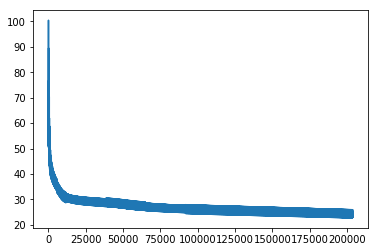

INFO - [421] training...
100%|██████████| 266/266 [00:25<00:00, 10.01it/s]
INFO - [421] training loss:23.8233642578125
INFO - [422] training...
100%|██████████| 266/266 [00:26<00:00, 10.44it/s]
INFO - [422] training loss:23.818971633911133
INFO - [423] training...
100%|██████████| 266/266 [00:25<00:00, 10.32it/s]
INFO - [423] training loss:23.814590454101562
INFO - [424] training...
100%|██████████| 266/266 [00:25<00:00,  9.15it/s]
INFO - [424] training loss:23.810216903686523
INFO - [425] training...
100%|██████████| 266/266 [00:28<00:00,  8.71it/s]
INFO - [425] training loss:23.805856704711914
INFO - [426] training...
100%|██████████| 266/266 [00:26<00:00, 11.33it/s]
INFO - [426] training loss:23.801511764526367
INFO - [427] training...
100%|██████████| 266/266 [00:24<00:00, 10.16it/s]
INFO - [427] training loss:23.797176361083984
INFO - [428] training...
100%|██████████| 266/266 [00:26<00:00, 10.63it/s]
INFO - [428] training loss:23.79285430908203
INFO - [429] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 203.09it/s]INFO - [430] test loss:24.39600372314453

100%|██████████| 14/14 [00:00<00:00, 210.50it/s]INFO - [430] test loss:23.23686408996582

100%|██████████| 22/22 [00:00<00:00, 210.54it/s]
INFO - [430] test loss:24.171247482299805
100%|██████████| 15/15 [00:00<00:00, 200.79it/s]INFO - [430] test loss:23.813396453857422

100%|██████████| 15/15 [00:00<00:00, 214.23it/s]INFO - [430] test loss:23.63265037536621

100%|██████████| 14/14 [00:00<00:00, 201.69it/s]INFO - [430] test loss:24.06458854675293

100%|██████████| 15/15 [00:00<00:00, 137.62it/s]INFO - [430] test loss:23.946796417236328

100%|██████████| 15/15 [00:00<00:00, 201.90it/s]INFO - [430] test loss:23.10780143737793

100%|██████████| 14/14 [00:00<00:00, 204.29it/s]INFO - [430] test loss:22.935508728027344

100%|██████████| 15/15 [00:00<00:00, 201.34it/s]INFO - [430] test loss:23.843847274780273

100%|██████████| 16/16 [00:00<00:00, 204.56it/s]INFO - [430] test loss:24.535799026489258

100%

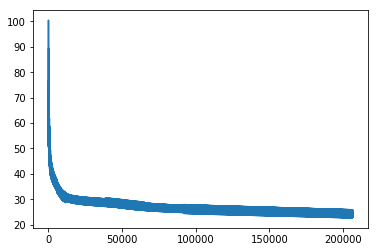

INFO - [431] training...
100%|██████████| 266/266 [00:26<00:00,  9.48it/s]
INFO - [431] training loss:23.779951095581055
INFO - [432] training...
100%|██████████| 266/266 [00:26<00:00, 10.10it/s]
INFO - [432] training loss:23.77567481994629
INFO - [433] training...
100%|██████████| 266/266 [00:26<00:00, 10.32it/s]
INFO - [433] training loss:23.771408081054688
INFO - [434] training...
100%|██████████| 266/266 [00:26<00:00, 10.72it/s]
INFO - [434] training loss:23.76715087890625
INFO - [435] training...
100%|██████████| 266/266 [00:24<00:00, 10.77it/s]
INFO - [435] training loss:23.762907028198242
INFO - [436] training...
100%|██████████| 266/266 [00:25<00:00,  9.88it/s]
INFO - [436] training loss:23.7586727142334
INFO - [437] training...
100%|██████████| 266/266 [00:27<00:00,  9.13it/s]
INFO - [437] training loss:23.75444793701172
INFO - [438] training...
100%|██████████| 266/266 [00:27<00:00,  8.77it/s]
INFO - [438] training loss:23.75023651123047
INFO - [439] training...
100%|████████

100%|██████████| 14/14 [00:00<00:00, 211.25it/s]INFO - [440] test loss:23.200376510620117

100%|██████████| 22/22 [00:00<00:00, 216.90it/s]
INFO - [440] test loss:24.13370132446289
100%|██████████| 15/15 [00:00<00:00, 212.35it/s]INFO - [440] test loss:23.774845123291016

100%|██████████| 15/15 [00:00<00:00, 200.33it/s]INFO - [440] test loss:23.593482971191406

100%|██████████| 14/14 [00:00<00:00, 219.39it/s]INFO - [440] test loss:24.020782470703125

100%|██████████| 23/23 [00:00<00:00, 220.94it/s]
INFO - [440] test loss:24.137510299682617
100%|██████████| 15/15 [00:00<00:00, 218.43it/s]INFO - [440] test loss:23.907981872558594

100%|██████████| 15/15 [00:00<00:00, 219.07it/s]INFO - [440] test loss:23.073293685913086

100%|██████████| 14/14 [00:00<00:00, 229.49it/s]INFO - [440] test loss:22.894922256469727

100%|██████████| 15/15 [00:00<00:00, 238.62it/s]INFO - [440] test loss:23.806194305419922

100%|██████████| 16/16 [00:00<00:00, 231.11it/s]INFO - [440] test loss:24.49803352355957

1

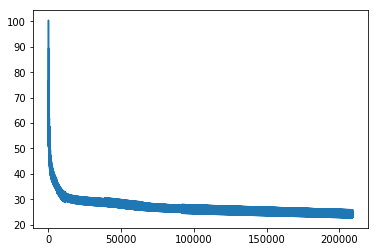

INFO - [441] training...
100%|██████████| 266/266 [00:26<00:00, 12.06it/s]
INFO - [441] training loss:23.737661361694336
INFO - [442] training...
100%|██████████| 266/266 [00:27<00:00,  7.88it/s]
INFO - [442] training loss:23.733491897583008
INFO - [443] training...
100%|██████████| 266/266 [00:27<00:00, 10.72it/s]
INFO - [443] training loss:23.729328155517578
INFO - [444] training...
100%|██████████| 266/266 [00:25<00:00, 10.40it/s]
INFO - [444] training loss:23.725175857543945
INFO - [445] training...
100%|██████████| 266/266 [00:22<00:00, 11.86it/s]
INFO - [445] training loss:23.721040725708008
INFO - [446] training...
100%|██████████| 266/266 [00:24<00:00,  9.46it/s]
INFO - [446] training loss:23.71690559387207
INFO - [447] training...
100%|██████████| 266/266 [00:27<00:00,  9.51it/s]
INFO - [447] training loss:23.712785720825195
INFO - [448] training...
100%|██████████| 266/266 [00:26<00:00, 10.84it/s]
INFO - [448] training loss:23.70867347717285
INFO - [449] training...
100%|████

100%|██████████| 15/15 [00:00<00:00, 227.69it/s]INFO - [450] test loss:24.299009323120117

100%|██████████| 22/22 [00:00<00:00, 206.10it/s]INFO - [450] test loss:24.096933364868164

100%|██████████| 14/14 [00:00<00:00, 176.09it/s]INFO - [450] test loss:24.020139694213867

100%|██████████| 19/19 [00:00<00:00, 156.44it/s]INFO - [450] test loss:24.23226547241211

100%|██████████| 23/23 [00:00<00:00, 206.70it/s]INFO - [450] test loss:24.099166870117188

100%|██████████| 15/15 [00:00<00:00, 219.03it/s]INFO - [450] test loss:23.51218605041504

100%|██████████| 16/16 [00:00<00:00, 222.85it/s]INFO - [450] test loss:23.88599395751953

100%|██████████| 16/16 [00:00<00:00, 202.65it/s]INFO - [450] test loss:24.552106857299805

100%|██████████| 18/18 [00:00<00:00, 213.68it/s]INFO - [450] test loss:24.221471786499023

100%|██████████| 18/18 [00:00<00:00, 213.32it/s]INFO - [450] test loss:24.82591438293457

100%|██████████| 16/16 [00:00<00:00, 229.60it/s]INFO - [450] test loss:23.835229873657227

100

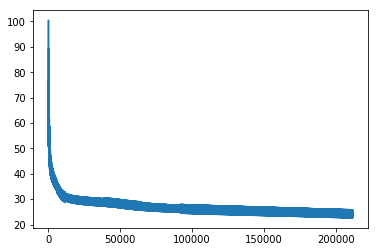

INFO - [451] training...
100%|██████████| 266/266 [00:26<00:00,  9.77it/s]
INFO - [451] training loss:23.696386337280273
INFO - [452] training...
100%|██████████| 266/266 [00:26<00:00,  9.99it/s]
INFO - [452] training loss:23.69230842590332
INFO - [453] training...
100%|██████████| 266/266 [00:26<00:00,  8.63it/s]
INFO - [453] training loss:23.6882381439209
INFO - [454] training...
100%|██████████| 266/266 [00:26<00:00, 10.70it/s]
INFO - [454] training loss:23.68417739868164
INFO - [455] training...
100%|██████████| 266/266 [00:24<00:00, 10.72it/s]
INFO - [455] training loss:23.680124282836914
INFO - [456] training...
100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
INFO - [456] training loss:23.67607879638672
INFO - [457] training...
100%|██████████| 266/266 [00:26<00:00, 10.65it/s]
INFO - [457] training loss:23.672042846679688
INFO - [458] training...
100%|██████████| 266/266 [00:26<00:00,  9.03it/s]
INFO - [458] training loss:23.66800880432129
INFO - [459] training...
100%|████████

100%|██████████| 14/14 [00:00<00:00, 209.44it/s]INFO - [460] test loss:23.12983512878418

100%|██████████| 22/22 [00:00<00:00, 210.60it/s]
INFO - [460] test loss:24.06100082397461
100%|██████████| 15/15 [00:00<00:00, 209.58it/s]INFO - [460] test loss:23.700275421142578

100%|██████████| 15/15 [00:00<00:00, 204.45it/s]INFO - [460] test loss:23.518198013305664

100%|██████████| 14/14 [00:00<00:00, 203.28it/s]INFO - [460] test loss:23.936052322387695

100%|██████████| 15/15 [00:00<00:00, 201.76it/s]INFO - [460] test loss:23.83353614807129

100%|██████████| 15/15 [00:00<00:00, 210.17it/s]INFO - [460] test loss:23.008174896240234

100%|██████████| 14/14 [00:00<00:00, 208.48it/s]INFO - [460] test loss:22.816116333007812

100%|██████████| 15/15 [00:00<00:00, 209.82it/s]INFO - [460] test loss:23.733421325683594

100%|██████████| 16/16 [00:00<00:00, 204.29it/s]INFO - [460] test loss:24.424972534179688

100%|██████████| 16/16 [00:00<00:00, 202.61it/s]INFO - [460] test loss:23.162309646606445

10

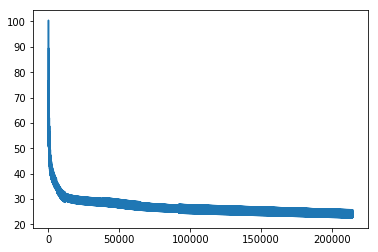

INFO - [461] training...
100%|██████████| 266/266 [00:26<00:00, 11.35it/s]
INFO - [461] training loss:23.65594482421875
INFO - [462] training...
100%|██████████| 266/266 [00:25<00:00, 10.46it/s]
INFO - [462] training loss:23.65194320678711
INFO - [463] training...
100%|██████████| 266/266 [00:26<00:00,  9.90it/s]
INFO - [463] training loss:23.647937774658203
INFO - [464] training...
100%|██████████| 266/266 [00:27<00:00,  9.84it/s]
INFO - [464] training loss:23.643945693969727
INFO - [465] training...
100%|██████████| 266/266 [00:26<00:00,  9.59it/s]
INFO - [465] training loss:23.639949798583984
INFO - [466] training...
100%|██████████| 266/266 [00:28<00:00,  9.71it/s]
INFO - [466] training loss:23.63596534729004
INFO - [467] training...
100%|██████████| 266/266 [00:27<00:00,  9.22it/s]
INFO - [467] training loss:23.631977081298828
INFO - [468] training...
100%|██████████| 266/266 [00:26<00:00, 10.21it/s]
INFO - [468] training loss:23.628000259399414
INFO - [469] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 201.34it/s]INFO - [470] test loss:24.24397850036621

100%|██████████| 14/14 [00:00<00:00, 159.98it/s]INFO - [470] test loss:23.095664978027344

100%|██████████| 15/15 [00:00<00:00, 199.79it/s]INFO - [470] test loss:23.663890838623047

100%|██████████| 14/14 [00:00<00:00, 139.18it/s]
INFO - [470] test loss:23.948131561279297
100%|██████████| 15/15 [00:00<00:00, 193.55it/s]INFO - [470] test loss:23.48187828063965

100%|██████████| 14/14 [00:00<00:00, 195.27it/s]INFO - [470] test loss:23.894994735717773

100%|██████████| 15/15 [00:00<00:00, 198.38it/s]INFO - [470] test loss:23.797693252563477

100%|██████████| 15/15 [00:00<00:00, 191.27it/s]INFO - [470] test loss:22.977357864379883

100%|██████████| 14/14 [00:00<00:00, 140.72it/s]INFO - [470] test loss:22.77773666381836

100%|██████████| 15/15 [00:00<00:00, 196.73it/s]INFO - [470] test loss:23.69806671142578

100%|██████████| 16/16 [00:00<00:00, 208.06it/s]INFO - [470] test loss:24.389436721801758

100

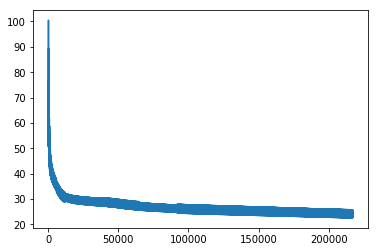

INFO - [471] training...
100%|██████████| 266/266 [00:26<00:00,  9.92it/s]
INFO - [471] training loss:23.61607551574707
INFO - [472] training...
100%|██████████| 266/266 [00:25<00:00, 10.64it/s]
INFO - [472] training loss:23.612102508544922
INFO - [473] training...
100%|██████████| 266/266 [00:23<00:00, 11.38it/s]
INFO - [473] training loss:23.608131408691406
INFO - [474] training...
100%|██████████| 266/266 [00:25<00:00,  9.35it/s]
INFO - [474] training loss:23.604158401489258
INFO - [475] training...
100%|██████████| 266/266 [00:26<00:00, 10.89it/s]
INFO - [475] training loss:23.600181579589844
INFO - [476] training...
100%|██████████| 266/266 [00:24<00:00, 12.72it/s]
INFO - [476] training loss:23.596208572387695
INFO - [477] training...
100%|██████████| 266/266 [00:24<00:00, 10.82it/s]
INFO - [477] training loss:23.592233657836914
INFO - [478] training...
100%|██████████| 266/266 [00:25<00:00, 10.44it/s]
INFO - [478] training loss:23.588253021240234
INFO - [479] training...
100%|███

100%|██████████| 16/16 [00:00<00:00, 209.54it/s]INFO - [480] test loss:24.20708656311035

100%|██████████| 14/14 [00:00<00:00, 213.32it/s]INFO - [480] test loss:23.0620174407959

100%|██████████| 22/22 [00:00<00:00, 210.59it/s]
INFO - [480] test loss:23.99166488647461
100%|██████████| 15/15 [00:00<00:00, 203.91it/s]INFO - [480] test loss:23.627649307250977

100%|██████████| 15/15 [00:00<00:00, 212.16it/s]INFO - [480] test loss:23.44618034362793

100%|██████████| 19/19 [00:00<00:00, 184.34it/s]
INFO - [480] test loss:24.11667251586914
100%|██████████| 14/14 [00:00<00:00, 208.27it/s]INFO - [480] test loss:23.854578018188477

100%|██████████| 15/15 [00:00<00:00, 211.03it/s]INFO - [480] test loss:23.762523651123047

100%|██████████| 15/15 [00:00<00:00, 208.44it/s]INFO - [480] test loss:22.94745635986328

100%|██████████| 14/14 [00:00<00:00, 212.84it/s]INFO - [480] test loss:22.73979377746582

100%|██████████| 15/15 [00:00<00:00, 206.72it/s]INFO - [480] test loss:23.66304588317871

100%|███

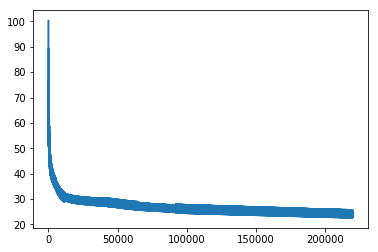

INFO - [481] training...
100%|██████████| 266/266 [00:25<00:00, 10.44it/s]
INFO - [481] training loss:23.576290130615234
INFO - [482] training...
100%|██████████| 266/266 [00:26<00:00, 11.14it/s]
INFO - [482] training loss:23.572284698486328
INFO - [483] training...
100%|██████████| 266/266 [00:25<00:00, 10.92it/s]
INFO - [483] training loss:23.568275451660156
INFO - [484] training...
100%|██████████| 266/266 [00:25<00:00,  9.79it/s]
INFO - [484] training loss:23.56425666809082
INFO - [485] training...
100%|██████████| 266/266 [00:26<00:00, 10.17it/s]
INFO - [485] training loss:23.560226440429688
INFO - [486] training...
100%|██████████| 266/266 [00:26<00:00, 11.52it/s]
INFO - [486] training loss:23.556182861328125
INFO - [487] training...
100%|██████████| 266/266 [00:26<00:00, 10.22it/s]
INFO - [487] training loss:23.55213165283203
INFO - [488] training...
100%|██████████| 266/266 [00:26<00:00, 10.13it/s]
INFO - [488] training loss:23.548067092895508
INFO - [489] training...
100%|████


100%|██████████| 14/14 [00:00<00:00, 205.07it/s]INFO - [490] test loss:23.028505325317383

100%|██████████| 22/22 [00:00<00:00, 219.54it/s]
INFO - [490] test loss:23.95819664001465
100%|██████████| 15/15 [00:00<00:00, 204.04it/s]INFO - [490] test loss:23.59084129333496

100%|██████████| 15/15 [00:00<00:00, 137.61it/s]INFO - [490] test loss:23.410751342773438

100%|██████████| 14/14 [00:00<00:00, 197.27it/s]INFO - [490] test loss:23.814451217651367

100%|██████████| 15/15 [00:00<00:00, 161.34it/s]INFO - [490] test loss:23.727659225463867

100%|██████████| 15/15 [00:00<00:00, 179.60it/s]INFO - [490] test loss:22.918102264404297

100%|██████████| 14/14 [00:00<00:00, 231.15it/s]INFO - [490] test loss:22.70191764831543

100%|██████████| 15/15 [00:00<00:00, 229.19it/s]INFO - [490] test loss:23.627817153930664

100%|██████████| 16/16 [00:00<00:00, 148.92it/s]INFO - [490] test loss:24.319198608398438

100%|██████████| 16/16 [00:00<00:00, 219.09it/s]INFO - [490] test loss:23.054744720458984

1

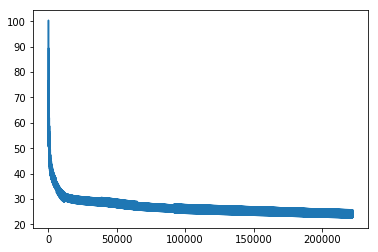

INFO - [491] training...
100%|██████████| 266/266 [00:27<00:00,  8.83it/s]
INFO - [491] training loss:23.535757064819336
INFO - [492] training...
100%|██████████| 266/266 [00:28<00:00,  9.94it/s]
INFO - [492] training loss:23.531618118286133
INFO - [493] training...
100%|██████████| 266/266 [00:26<00:00, 11.21it/s]
INFO - [493] training loss:23.52745246887207
INFO - [494] training...
100%|██████████| 266/266 [00:24<00:00,  9.50it/s]
INFO - [494] training loss:23.523263931274414
INFO - [495] training...
100%|██████████| 266/266 [00:26<00:00,  9.46it/s]
INFO - [495] training loss:23.51905059814453
INFO - [496] training...
100%|██████████| 266/266 [00:26<00:00,  9.44it/s]
INFO - [496] training loss:23.51481056213379
INFO - [497] training...
100%|██████████| 266/266 [00:25<00:00, 10.25it/s]
INFO - [497] training loss:23.510540008544922
INFO - [498] training...
100%|██████████| 266/266 [00:26<00:00, 10.33it/s]
INFO - [498] training loss:23.50623321533203
INFO - [499] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 201.74it/s]INFO - [500] test loss:24.130748748779297

100%|██████████| 14/14 [00:00<00:00, 191.90it/s]INFO - [500] test loss:22.994184494018555

100%|██████████| 15/15 [00:00<00:00, 202.93it/s]INFO - [500] test loss:23.55216407775879

100%|██████████| 15/15 [00:00<00:00, 193.86it/s]INFO - [500] test loss:23.374862670898438

100%|██████████| 14/14 [00:00<00:00, 199.46it/s]INFO - [500] test loss:23.77393341064453

100%|██████████| 15/15 [00:00<00:00, 195.31it/s]INFO - [500] test loss:23.692277908325195

100%|██████████| 15/15 [00:00<00:00, 199.98it/s]INFO - [500] test loss:22.888547897338867

100%|██████████| 14/14 [00:00<00:00, 212.45it/s]INFO - [500] test loss:22.66353416442871

100%|██████████| 15/15 [00:00<00:00, 209.36it/s]INFO - [500] test loss:23.591333389282227

100%|██████████| 16/16 [00:00<00:00, 200.66it/s]INFO - [500] test loss:24.283489227294922

100%|██████████| 16/16 [00:00<00:00, 210.48it/s]INFO - [500] test loss:23.017709732055664

10

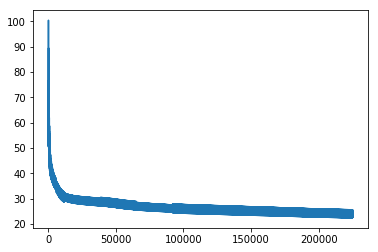

INFO - [501] training...
100%|██████████| 266/266 [00:26<00:00, 10.00it/s]
INFO - [501] training loss:23.49312400817871
INFO - [502] training...
100%|██████████| 266/266 [00:26<00:00, 10.58it/s]
INFO - [502] training loss:23.488677978515625
INFO - [503] training...
100%|██████████| 266/266 [00:26<00:00, 10.61it/s]
INFO - [503] training loss:23.484203338623047
INFO - [504] training...
100%|██████████| 266/266 [00:25<00:00, 10.80it/s]
INFO - [504] training loss:23.47968864440918
INFO - [505] training...
100%|██████████| 266/266 [00:27<00:00,  9.33it/s]
INFO - [505] training loss:23.475135803222656
INFO - [506] training...
100%|██████████| 266/266 [00:26<00:00,  9.78it/s]
INFO - [506] training loss:23.47054672241211
INFO - [507] training...
100%|██████████| 266/266 [00:26<00:00,  8.94it/s]
INFO - [507] training loss:23.465923309326172
INFO - [508] training...
100%|██████████| 266/266 [00:28<00:00,  9.28it/s]
INFO - [508] training loss:23.461273193359375
INFO - [509] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 209.79it/s]INFO - [510] test loss:24.088075637817383

100%|██████████| 14/14 [00:00<00:00, 220.72it/s]INFO - [510] test loss:22.95716094970703

100%|██████████| 15/15 [00:00<00:00, 226.74it/s]INFO - [510] test loss:23.509965896606445

100%|██████████| 15/15 [00:00<00:00, 217.04it/s]INFO - [510] test loss:23.33732032775879

100%|██████████| 14/14 [00:00<00:00, 222.42it/s]INFO - [510] test loss:23.732011795043945

100%|██████████| 23/23 [00:00<00:00, 229.51it/s]
INFO - [510] test loss:23.897733688354492
100%|██████████| 15/15 [00:00<00:00, 227.45it/s]INFO - [510] test loss:23.65484046936035

100%|██████████| 15/15 [00:00<00:00, 222.95it/s]INFO - [510] test loss:22.857385635375977

100%|██████████| 14/14 [00:00<00:00, 220.84it/s]INFO - [510] test loss:22.624265670776367

100%|██████████| 15/15 [00:00<00:00, 224.24it/s]INFO - [510] test loss:23.552078247070312

100%|██████████| 16/16 [00:00<00:00, 223.69it/s]INFO - [510] test loss:24.246217727661133

10

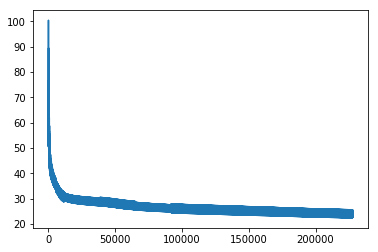

INFO - [511] training...
100%|██████████| 266/266 [00:23<00:00,  9.11it/s]
INFO - [511] training loss:23.447168350219727
INFO - [512] training...
100%|██████████| 266/266 [00:28<00:00,  8.21it/s]
INFO - [512] training loss:23.442432403564453
INFO - [513] training...
100%|██████████| 266/266 [00:28<00:00,  8.59it/s]
INFO - [513] training loss:23.437694549560547
INFO - [514] training...
100%|██████████| 266/266 [00:27<00:00,  9.84it/s]
INFO - [514] training loss:23.43295669555664
INFO - [515] training...
100%|██████████| 266/266 [00:24<00:00,  9.54it/s]
INFO - [515] training loss:23.42822265625
INFO - [516] training...
100%|██████████| 266/266 [00:20<00:00, 12.68it/s]
INFO - [516] training loss:23.423513412475586
INFO - [517] training...
100%|██████████| 266/266 [00:20<00:00, 12.69it/s]
INFO - [517] training loss:23.418827056884766
INFO - [518] training...
100%|██████████| 266/266 [00:24<00:00,  8.88it/s]
INFO - [518] training loss:23.414165496826172
INFO - [519] training...
100%|███████

100%|██████████| 16/16 [00:00<00:00, 222.30it/s]INFO - [520] test loss:24.041318893432617

100%|██████████| 14/14 [00:00<00:00, 222.80it/s]INFO - [520] test loss:22.916719436645508

100%|██████████| 15/15 [00:00<00:00, 225.13it/s]INFO - [520] test loss:23.46572494506836

100%|██████████| 15/15 [00:00<00:00, 233.89it/s]INFO - [520] test loss:23.297700881958008

100%|██████████| 14/14 [00:00<00:00, 208.42it/s]INFO - [520] test loss:23.688520431518555

100%|██████████| 23/23 [00:00<00:00, 226.44it/s]
INFO - [520] test loss:23.865041732788086
100%|██████████| 15/15 [00:00<00:00, 222.62it/s]INFO - [520] test loss:23.614572525024414

100%|██████████| 15/15 [00:00<00:00, 217.01it/s]INFO - [520] test loss:22.8238468170166

100%|██████████| 14/14 [00:00<00:00, 212.81it/s]INFO - [520] test loss:22.58548355102539

100%|██████████| 15/15 [00:00<00:00, 224.98it/s]INFO - [520] test loss:23.510337829589844

100%|██████████| 16/16 [00:00<00:00, 231.45it/s]INFO - [520] test loss:24.20744514465332

100%

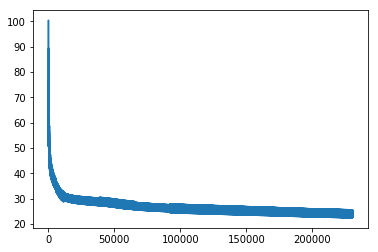

INFO - [521] training...
100%|██████████| 266/266 [00:22<00:00,  9.61it/s]
INFO - [521] training loss:23.40044593811035
INFO - [522] training...
100%|██████████| 266/266 [00:23<00:00,  9.12it/s]
INFO - [522] training loss:23.395971298217773
INFO - [523] training...
100%|██████████| 266/266 [00:24<00:00, 10.79it/s]
INFO - [523] training loss:23.391551971435547
INFO - [524] training...
100%|██████████| 266/266 [00:24<00:00, 10.69it/s]
INFO - [524] training loss:23.387195587158203
INFO - [525] training...
100%|██████████| 266/266 [00:27<00:00,  7.96it/s]
INFO - [525] training loss:23.382890701293945
INFO - [526] training...
100%|██████████| 266/266 [00:27<00:00,  9.71it/s]
INFO - [526] training loss:23.378652572631836
INFO - [527] training...
100%|██████████| 266/266 [00:27<00:00, 10.85it/s]
INFO - [527] training loss:23.374467849731445
INFO - [528] training...
100%|██████████| 266/266 [00:26<00:00,  9.90it/s]
INFO - [528] training loss:23.370342254638672
INFO - [529] training...
100%|███

100%|██████████| 16/16 [00:00<00:00, 229.71it/s]INFO - [530] test loss:23.995622634887695

100%|██████████| 14/14 [00:00<00:00, 217.00it/s]INFO - [530] test loss:22.877023696899414

100%|██████████| 15/15 [00:00<00:00, 213.91it/s]INFO - [530] test loss:23.4252872467041

100%|██████████| 15/15 [00:00<00:00, 193.51it/s]INFO - [530] test loss:23.258155822753906

100%|██████████| 14/14 [00:00<00:00, 185.56it/s]INFO - [530] test loss:23.645830154418945

100%|██████████| 15/15 [00:00<00:00, 206.43it/s]INFO - [530] test loss:23.57412338256836

100%|██████████| 15/15 [00:00<00:00, 211.52it/s]INFO - [530] test loss:22.789974212646484

100%|██████████| 14/14 [00:00<00:00, 180.87it/s]INFO - [530] test loss:22.549264907836914

100%|██████████| 15/15 [00:00<00:00, 217.10it/s]INFO - [530] test loss:23.4699764251709

100%|██████████| 16/16 [00:00<00:00, 206.46it/s]INFO - [530] test loss:24.169736862182617

100%|██████████| 16/16 [00:00<00:00, 212.48it/s]INFO - [530] test loss:22.894081115722656

100%

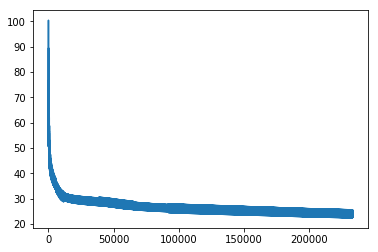

INFO - [531] training...
100%|██████████| 266/266 [00:26<00:00,  9.07it/s]
INFO - [531] training loss:23.358295440673828
INFO - [532] training...
100%|██████████| 266/266 [00:26<00:00, 11.24it/s]
INFO - [532] training loss:23.354379653930664
INFO - [533] training...
100%|██████████| 266/266 [00:25<00:00, 10.30it/s]
INFO - [533] training loss:23.350513458251953
INFO - [534] training...
100%|██████████| 266/266 [00:26<00:00, 10.20it/s]
INFO - [534] training loss:23.34669303894043
INFO - [535] training...
100%|██████████| 266/266 [00:26<00:00, 10.17it/s]
INFO - [535] training loss:23.342914581298828
INFO - [536] training...
100%|██████████| 266/266 [00:25<00:00, 10.34it/s]
INFO - [536] training loss:23.339170455932617
INFO - [537] training...
100%|██████████| 266/266 [00:26<00:00, 10.20it/s]
INFO - [537] training loss:23.33547019958496
INFO - [538] training...
100%|██████████| 266/266 [00:25<00:00, 10.63it/s]
INFO - [538] training loss:23.331804275512695
INFO - [539] training...
100%|████

100%|██████████| 16/16 [00:00<00:00, 204.61it/s]INFO - [540] test loss:23.954833984375

100%|██████████| 14/14 [00:00<00:00, 204.77it/s]INFO - [540] test loss:22.84086036682129

100%|██████████| 22/22 [00:00<00:00, 213.54it/s]
INFO - [540] test loss:23.7923641204834
100%|██████████| 15/15 [00:00<00:00, 210.58it/s]INFO - [540] test loss:23.389930725097656

100%|██████████| 15/15 [00:00<00:00, 198.90it/s]INFO - [540] test loss:23.220672607421875

100%|██████████| 14/14 [00:00<00:00, 193.14it/s]INFO - [540] test loss:23.60582733154297

100%|██████████| 15/15 [00:00<00:00, 203.87it/s]INFO - [540] test loss:23.535900115966797

100%|██████████| 15/15 [00:00<00:00, 150.45it/s]INFO - [540] test loss:22.757572174072266

100%|██████████| 14/14 [00:00<00:00, 201.78it/s]INFO - [540] test loss:22.51534652709961

100%|██████████| 15/15 [00:00<00:00, 178.51it/s]INFO - [540] test loss:23.432937622070312

100%|██████████| 18/18 [00:00<00:00, 176.52it/s]
INFO - [540] test loss:23.88385772705078
100%|███

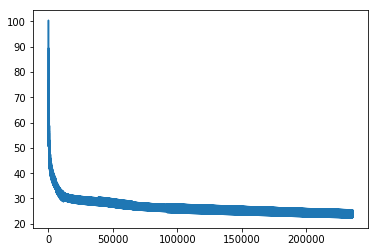

INFO - [541] training...
100%|██████████| 266/266 [00:26<00:00,  9.30it/s]
INFO - [541] training loss:23.32098960876465
INFO - [542] training...
100%|██████████| 266/266 [00:26<00:00, 10.04it/s]
INFO - [542] training loss:23.317447662353516
INFO - [543] training...
100%|██████████| 266/266 [00:26<00:00,  9.88it/s]
INFO - [543] training loss:23.313926696777344
INFO - [544] training...
100%|██████████| 266/266 [00:25<00:00, 10.11it/s]
INFO - [544] training loss:23.310436248779297
INFO - [545] training...
100%|██████████| 266/266 [00:26<00:00, 10.02it/s]
INFO - [545] training loss:23.306957244873047
INFO - [546] training...
100%|██████████| 266/266 [00:24<00:00, 11.00it/s]
INFO - [546] training loss:23.303512573242188
INFO - [547] training...
100%|██████████| 266/266 [00:24<00:00, 10.05it/s]
INFO - [547] training loss:23.30008316040039
INFO - [548] training...
100%|██████████| 266/266 [00:25<00:00, 10.35it/s]
INFO - [548] training loss:23.29667091369629
INFO - [549] training...
100%|█████


100%|██████████| 14/14 [00:00<00:00, 206.20it/s]INFO - [550] test loss:22.80756378173828

100%|██████████| 15/15 [00:00<00:00, 201.81it/s]INFO - [550] test loss:23.357730865478516

100%|██████████| 15/15 [00:00<00:00, 208.80it/s]INFO - [550] test loss:23.18568992614746

100%|██████████| 14/14 [00:00<00:00, 200.39it/s]INFO - [550] test loss:23.568239212036133

100%|██████████| 15/15 [00:00<00:00, 206.97it/s]INFO - [550] test loss:23.50006675720215

100%|██████████| 15/15 [00:00<00:00, 199.22it/s]INFO - [550] test loss:22.726743698120117

100%|██████████| 14/14 [00:00<00:00, 179.30it/s]INFO - [550] test loss:22.48290252685547

100%|██████████| 15/15 [00:00<00:00, 195.21it/s]INFO - [550] test loss:23.39871597290039

100%|██████████| 16/16 [00:00<00:00, 205.91it/s]INFO - [550] test loss:24.1018123626709

100%|██████████| 16/16 [00:00<00:00, 196.96it/s]INFO - [550] test loss:22.81929588317871

100%|██████████| 16/16 [00:00<00:00, 207.52it/s]INFO - [550] test loss:23.864978790283203

100%|█

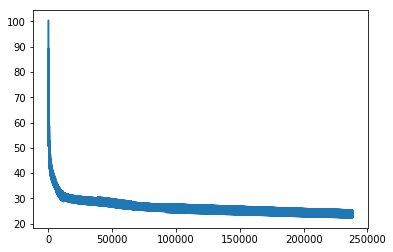

INFO - [551] training...
100%|██████████| 266/266 [00:26<00:00,  9.14it/s]
INFO - [551] training loss:23.28655433654785
INFO - [552] training...
100%|██████████| 266/266 [00:25<00:00, 10.45it/s]
INFO - [552] training loss:23.283212661743164
INFO - [553] training...
100%|██████████| 266/266 [00:26<00:00, 10.46it/s]
INFO - [553] training loss:23.279888153076172
INFO - [554] training...
100%|██████████| 266/266 [00:25<00:00, 11.37it/s]
INFO - [554] training loss:23.276578903198242
INFO - [555] training...
100%|██████████| 266/266 [00:26<00:00,  9.78it/s]
INFO - [555] training loss:23.273283004760742
INFO - [556] training...
100%|██████████| 266/266 [00:25<00:00, 10.39it/s]
INFO - [556] training loss:23.26999855041504
INFO - [557] training...
100%|██████████| 266/266 [00:25<00:00, 10.61it/s]
INFO - [557] training loss:23.26673126220703
INFO - [558] training...
100%|██████████| 266/266 [00:26<00:00, 10.61it/s]
INFO - [558] training loss:23.263471603393555
INFO - [559] training...
100%|█████

100%|██████████| 14/14 [00:00<00:00, 210.41it/s]INFO - [560] test loss:22.776134490966797

100%|██████████| 15/15 [00:00<00:00, 204.46it/s]INFO - [560] test loss:23.32738494873047

100%|██████████| 15/15 [00:00<00:00, 198.14it/s]INFO - [560] test loss:23.152908325195312

100%|██████████| 14/14 [00:00<00:00, 199.77it/s]INFO - [560] test loss:23.532289505004883

100%|██████████| 15/15 [00:00<00:00, 208.03it/s]INFO - [560] test loss:23.466041564941406

100%|██████████| 15/15 [00:00<00:00, 206.89it/s]INFO - [560] test loss:22.697120666503906

100%|██████████| 14/14 [00:00<00:00, 211.24it/s]INFO - [560] test loss:22.451461791992188

100%|██████████| 15/15 [00:00<00:00, 209.13it/s]INFO - [560] test loss:23.36651039123535

100%|██████████| 16/16 [00:00<00:00, 216.21it/s]INFO - [560] test loss:24.07063102722168

100%|██████████| 16/16 [00:00<00:00, 213.33it/s]INFO - [560] test loss:22.785282135009766

100%|██████████| 16/16 [00:00<00:00, 213.69it/s]INFO - [560] test loss:23.8293399810791

100%

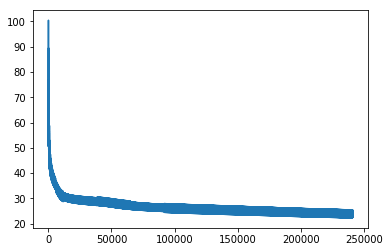

INFO - [561] training...
100%|██████████| 266/266 [00:25<00:00, 10.24it/s]
INFO - [561] training loss:23.253780364990234
INFO - [562] training...
100%|██████████| 266/266 [00:27<00:00, 10.23it/s]
INFO - [562] training loss:23.250577926635742
INFO - [563] training...
100%|██████████| 266/266 [00:25<00:00, 11.33it/s]
INFO - [563] training loss:23.247377395629883
INFO - [564] training...
100%|██████████| 266/266 [00:24<00:00, 10.76it/s]
INFO - [564] training loss:23.24419403076172
INFO - [565] training...
100%|██████████| 266/266 [00:27<00:00,  9.47it/s]
INFO - [565] training loss:23.24102020263672
INFO - [566] training...
100%|██████████| 266/266 [00:26<00:00,  9.54it/s]
INFO - [566] training loss:23.237855911254883
INFO - [567] training...
100%|██████████| 266/266 [00:26<00:00,  9.66it/s]
INFO - [567] training loss:23.234703063964844
INFO - [568] training...
100%|██████████| 266/266 [00:23<00:00, 10.85it/s]
INFO - [568] training loss:23.231555938720703
INFO - [569] training...
100%|████

100%|██████████| 15/15 [00:00<00:00, 217.42it/s]INFO - [570] test loss:23.843793869018555

100%|██████████| 22/22 [00:00<00:00, 219.57it/s]
INFO - [570] test loss:23.69406509399414

100%|██████████| 14/14 [00:00<00:00, 220.16it/s]INFO - [570] test loss:23.565227508544922

100%|██████████| 19/19 [00:00<00:00, 210.04it/s]INFO - [570] test loss:23.77722930908203

100%|██████████| 23/23 [00:00<00:00, 211.42it/s]INFO - [570] test loss:23.699857711791992

100%|██████████| 15/15 [00:00<00:00, 211.81it/s]INFO - [570] test loss:23.064592361450195

100%|██████████| 16/16 [00:00<00:00, 211.18it/s]INFO - [570] test loss:23.403413772583008

100%|██████████| 16/16 [00:00<00:00, 209.69it/s]INFO - [570] test loss:24.088224411010742

100%|██████████| 18/18 [00:00<00:00, 213.68it/s]INFO - [570] test loss:23.78825569152832

100%|██████████| 18/18 [00:00<00:00, 213.46it/s]INFO - [570] test loss:24.336894989013672

100%|██████████| 16/16 [00:00<00:00, 216.74it/s]INFO - [570] test loss:23.414281845092773

1

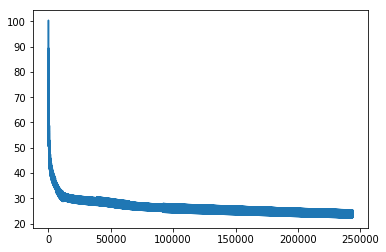

INFO - [571] training...
100%|██████████| 266/266 [00:26<00:00, 11.01it/s]
INFO - [571] training loss:23.22218894958496
INFO - [572] training...
100%|██████████| 266/266 [00:25<00:00, 10.80it/s]
INFO - [572] training loss:23.219087600708008
INFO - [573] training...
100%|██████████| 266/266 [00:26<00:00,  9.53it/s]
INFO - [573] training loss:23.21599006652832
INFO - [574] training...
100%|██████████| 266/266 [00:26<00:00, 10.79it/s]
INFO - [574] training loss:23.21291160583496
INFO - [575] training...
100%|██████████| 266/266 [00:25<00:00, 10.03it/s]
INFO - [575] training loss:23.20983123779297
INFO - [576] training...
100%|██████████| 266/266 [00:26<00:00, 10.15it/s]
INFO - [576] training loss:23.206769943237305
INFO - [577] training...
100%|██████████| 266/266 [00:26<00:00,  9.56it/s]
INFO - [577] training loss:23.203712463378906
INFO - [578] training...
100%|██████████| 266/266 [00:27<00:00,  9.80it/s]
INFO - [578] training loss:23.200668334960938
INFO - [579] training...
100%|██████


100%|██████████| 14/14 [00:00<00:00, 224.76it/s]INFO - [580] test loss:22.716665267944336

100%|██████████| 15/15 [00:00<00:00, 219.80it/s]INFO - [580] test loss:23.27000617980957

100%|██████████| 15/15 [00:00<00:00, 228.03it/s]INFO - [580] test loss:23.092266082763672

100%|██████████| 14/14 [00:00<00:00, 220.52it/s]INFO - [580] test loss:23.463228225708008

100%|██████████| 15/15 [00:00<00:00, 155.24it/s]INFO - [580] test loss:23.401304244995117

100%|██████████| 15/15 [00:00<00:00, 216.70it/s]INFO - [580] test loss:22.64027976989746

100%|██████████| 14/14 [00:00<00:00, 144.15it/s]INFO - [580] test loss:22.390748977661133

100%|██████████| 15/15 [00:00<00:00, 214.55it/s]INFO - [580] test loss:23.306167602539062

100%|██████████| 16/16 [00:00<00:00, 216.15it/s]INFO - [580] test loss:24.011455535888672

100%|██████████| 16/16 [00:00<00:00, 213.89it/s]INFO - [580] test loss:22.721145629882812

100%|██████████| 16/16 [00:00<00:00, 204.24it/s]INFO - [580] test loss:23.762025833129883



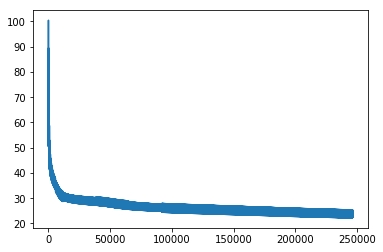

INFO - [581] training...
100%|██████████| 266/266 [00:27<00:00,  7.78it/s]
INFO - [581] training loss:23.19158172607422
INFO - [582] training...
100%|██████████| 266/266 [00:27<00:00,  8.55it/s]
INFO - [582] training loss:23.188570022583008
INFO - [583] training...
100%|██████████| 266/266 [00:25<00:00, 10.28it/s]
INFO - [583] training loss:23.18557357788086
INFO - [584] training...
100%|██████████| 266/266 [00:28<00:00,  9.37it/s]
INFO - [584] training loss:23.182579040527344
INFO - [585] training...
100%|██████████| 266/266 [00:26<00:00, 10.16it/s]
INFO - [585] training loss:23.179597854614258
INFO - [586] training...
100%|██████████| 266/266 [00:24<00:00,  9.63it/s]
INFO - [586] training loss:23.17662239074707
INFO - [587] training...
100%|██████████| 266/266 [00:25<00:00, 11.83it/s]
INFO - [587] training loss:23.173656463623047
INFO - [588] training...
100%|██████████| 266/266 [00:24<00:00, 10.51it/s]
INFO - [588] training loss:23.170703887939453
INFO - [589] training...
100%|█████


100%|██████████| 14/14 [00:00<00:00, 224.45it/s]INFO - [590] test loss:22.68807029724121

100%|██████████| 15/15 [00:00<00:00, 222.40it/s]INFO - [590] test loss:23.242443084716797

100%|██████████| 15/15 [00:00<00:00, 223.77it/s]INFO - [590] test loss:23.063753128051758

100%|██████████| 14/14 [00:00<00:00, 214.93it/s]INFO - [590] test loss:23.429615020751953

100%|██████████| 15/15 [00:00<00:00, 208.66it/s]INFO - [590] test loss:23.369932174682617

100%|██████████| 15/15 [00:00<00:00, 216.51it/s]INFO - [590] test loss:22.612762451171875

100%|██████████| 14/14 [00:00<00:00, 226.53it/s]INFO - [590] test loss:22.36136245727539

100%|██████████| 15/15 [00:00<00:00, 230.82it/s]INFO - [590] test loss:23.277587890625

100%|██████████| 16/16 [00:00<00:00, 226.90it/s]INFO - [590] test loss:23.98296356201172

100%|██████████| 16/16 [00:00<00:00, 228.20it/s]INFO - [590] test loss:22.690425872802734

100%|██████████| 16/16 [00:00<00:00, 229.05it/s]INFO - [590] test loss:23.729841232299805

100%

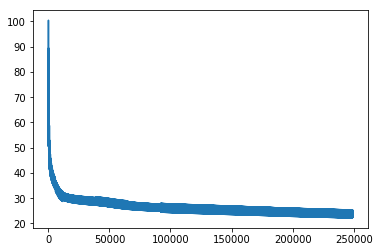

INFO - [591] training...
100%|██████████| 266/266 [00:24<00:00, 10.78it/s]
INFO - [591] training loss:23.16188621520996
INFO - [592] training...
100%|██████████| 266/266 [00:25<00:00, 10.62it/s]
INFO - [592] training loss:23.158964157104492
INFO - [593] training...
100%|██████████| 266/266 [00:26<00:00, 10.20it/s]
INFO - [593] training loss:23.15605354309082
INFO - [594] training...
100%|██████████| 266/266 [00:25<00:00, 10.28it/s]
INFO - [594] training loss:23.15315055847168
INFO - [595] training...
100%|██████████| 266/266 [00:25<00:00, 10.28it/s]
INFO - [595] training loss:23.150253295898438
INFO - [596] training...
100%|██████████| 266/266 [00:24<00:00, 10.72it/s]
INFO - [596] training loss:23.147369384765625
INFO - [597] training...
100%|██████████| 266/266 [00:26<00:00, 10.56it/s]
INFO - [597] training loss:23.144495010375977
INFO - [598] training...
100%|██████████| 266/266 [00:25<00:00,  8.18it/s]
INFO - [598] training loss:23.14162826538086
INFO - [599] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 211.70it/s]INFO - [600] test loss:23.753461837768555

100%|██████████| 14/14 [00:00<00:00, 205.48it/s]INFO - [600] test loss:22.660078048706055

100%|██████████| 22/22 [00:00<00:00, 214.85it/s]
INFO - [600] test loss:23.59587860107422
100%|██████████| 15/15 [00:00<00:00, 212.48it/s]INFO - [600] test loss:23.215478897094727

100%|██████████| 15/15 [00:00<00:00, 204.46it/s]INFO - [600] test loss:23.036161422729492

100%|██████████| 14/14 [00:00<00:00, 214.06it/s]INFO - [600] test loss:23.396507263183594

100%|██████████| 15/15 [00:00<00:00, 212.91it/s]INFO - [600] test loss:23.339025497436523

100%|██████████| 15/15 [00:00<00:00, 210.50it/s]INFO - [600] test loss:22.585838317871094

100%|██████████| 14/14 [00:00<00:00, 208.64it/s]INFO - [600] test loss:22.33264923095703

100%|██████████| 15/15 [00:00<00:00, 209.42it/s]INFO - [600] test loss:23.249980926513672

100%|██████████| 16/16 [00:00<00:00, 205.38it/s]INFO - [600] test loss:23.955049514770508

1

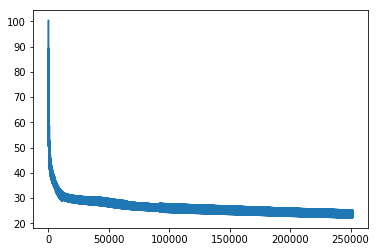

INFO - [601] training...
100%|██████████| 266/266 [00:27<00:00,  9.79it/s]
INFO - [601] training loss:23.133075714111328
INFO - [602] training...
100%|██████████| 266/266 [00:27<00:00,  9.63it/s]
INFO - [602] training loss:23.1302433013916
INFO - [603] training...
100%|██████████| 266/266 [00:26<00:00, 10.01it/s]
INFO - [603] training loss:23.12742042541504
INFO - [604] training...
100%|██████████| 266/266 [00:26<00:00,  9.38it/s]
INFO - [604] training loss:23.124605178833008
INFO - [605] training...
100%|██████████| 266/266 [00:27<00:00,  7.98it/s]
INFO - [605] training loss:23.121793746948242
INFO - [606] training...
100%|██████████| 266/266 [00:27<00:00,  9.26it/s]
INFO - [606] training loss:23.118995666503906
INFO - [607] training...
100%|██████████| 266/266 [00:27<00:00,  9.49it/s]
INFO - [607] training loss:23.11620330810547
INFO - [608] training...
100%|██████████| 266/266 [00:24<00:00,  9.81it/s]
INFO - [608] training loss:23.113428115844727
INFO - [609] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 187.11it/s]INFO - [610] test loss:23.72205924987793

100%|██████████| 14/14 [00:00<00:00, 207.07it/s]INFO - [610] test loss:22.632667541503906

100%|██████████| 15/15 [00:00<00:00, 195.73it/s]INFO - [610] test loss:23.1890926361084

100%|██████████| 15/15 [00:00<00:00, 198.32it/s]INFO - [610] test loss:23.009323120117188

100%|██████████| 14/14 [00:00<00:00, 198.31it/s]INFO - [610] test loss:23.363941192626953

100%|██████████| 15/15 [00:00<00:00, 195.15it/s]INFO - [610] test loss:23.30855941772461

100%|██████████| 15/15 [00:00<00:00, 201.93it/s]INFO - [610] test loss:22.55956268310547

100%|██████████| 14/14 [00:00<00:00, 206.11it/s]INFO - [610] test loss:22.30463218688965

100%|██████████| 15/15 [00:00<00:00, 199.05it/s]INFO - [610] test loss:23.223344802856445

100%|██████████| 16/16 [00:00<00:00, 203.58it/s]INFO - [610] test loss:23.92769432067871

100%|██████████| 16/16 [00:00<00:00, 205.42it/s]INFO - [610] test loss:22.631074905395508

100%|█

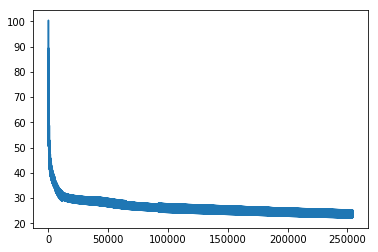

INFO - [611] training...
100%|██████████| 266/266 [00:27<00:00,  9.59it/s]
INFO - [611] training loss:23.105131149291992
INFO - [612] training...
100%|██████████| 266/266 [00:26<00:00, 10.10it/s]
INFO - [612] training loss:23.102388381958008
INFO - [613] training...
100%|██████████| 266/266 [00:26<00:00, 10.33it/s]
INFO - [613] training loss:23.099645614624023
INFO - [614] training...
100%|██████████| 266/266 [00:27<00:00,  9.45it/s]
INFO - [614] training loss:23.0969181060791
INFO - [615] training...
100%|██████████| 266/266 [00:25<00:00,  9.60it/s]
INFO - [615] training loss:23.09419822692871
INFO - [616] training...
100%|██████████| 266/266 [00:26<00:00, 10.35it/s]
INFO - [616] training loss:23.091482162475586
INFO - [617] training...
100%|██████████| 266/266 [00:26<00:00, 10.16it/s]
INFO - [617] training loss:23.08877944946289
INFO - [618] training...
100%|██████████| 266/266 [00:26<00:00, 10.19it/s]
INFO - [618] training loss:23.086082458496094
INFO - [619] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 210.84it/s]INFO - [620] test loss:23.691171646118164

100%|██████████| 14/14 [00:00<00:00, 208.01it/s]INFO - [620] test loss:22.605867385864258

100%|██████████| 15/15 [00:00<00:00, 151.91it/s]INFO - [620] test loss:23.163341522216797

100%|██████████| 15/15 [00:00<00:00, 211.25it/s]INFO - [620] test loss:22.983118057250977

100%|██████████| 14/14 [00:00<00:00, 206.73it/s]INFO - [620] test loss:23.33201026916504

100%|██████████| 15/15 [00:00<00:00, 204.92it/s]INFO - [620] test loss:23.278587341308594

100%|██████████| 15/15 [00:00<00:00, 210.84it/s]INFO - [620] test loss:22.53403091430664

100%|██████████| 14/14 [00:00<00:00, 196.41it/s]INFO - [620] test loss:22.277345657348633

100%|██████████| 15/15 [00:00<00:00, 189.98it/s]INFO - [620] test loss:23.19765281677246

100%|██████████| 16/16 [00:00<00:00, 201.38it/s]INFO - [620] test loss:23.90089988708496

100%|██████████| 16/16 [00:00<00:00, 206.86it/s]INFO - [620] test loss:22.602399826049805

100

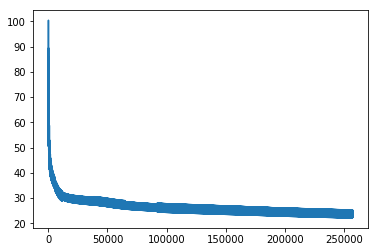

INFO - [621] training...
100%|██████████| 266/266 [00:27<00:00,  7.17it/s]
INFO - [621] training loss:23.078048706054688
INFO - [622] training...
100%|██████████| 266/266 [00:26<00:00,  8.86it/s]
INFO - [622] training loss:23.075387954711914
INFO - [623] training...
100%|██████████| 266/266 [00:23<00:00, 12.72it/s]
INFO - [623] training loss:23.07273292541504
INFO - [624] training...
100%|██████████| 266/266 [00:22<00:00,  8.59it/s]
INFO - [624] training loss:23.070087432861328
INFO - [625] training...
100%|██████████| 266/266 [00:21<00:00, 12.67it/s]
INFO - [625] training loss:23.067453384399414
INFO - [626] training...
100%|██████████| 266/266 [00:25<00:00, 10.52it/s]
INFO - [626] training loss:23.06482696533203
INFO - [627] training...
100%|██████████| 266/266 [00:26<00:00,  9.90it/s]
INFO - [627] training loss:23.06220817565918
INFO - [628] training...
100%|██████████| 266/266 [00:25<00:00, 10.08it/s]
INFO - [628] training loss:23.059595108032227
INFO - [629] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 219.03it/s]INFO - [630] test loss:23.660940170288086

100%|██████████| 14/14 [00:00<00:00, 219.75it/s]INFO - [630] test loss:22.579734802246094

100%|██████████| 15/15 [00:00<00:00, 221.56it/s]INFO - [630] test loss:23.13829231262207

100%|██████████| 15/15 [00:00<00:00, 156.22it/s]INFO - [630] test loss:22.957460403442383

100%|██████████| 14/14 [00:00<00:00, 222.80it/s]INFO - [630] test loss:23.300817489624023

100%|██████████| 23/23 [00:00<00:00, 224.39it/s]
INFO - [630] test loss:23.535552978515625
100%|██████████| 15/15 [00:00<00:00, 226.92it/s]INFO - [630] test loss:23.24920082092285

100%|██████████| 15/15 [00:00<00:00, 212.69it/s]INFO - [630] test loss:22.50932502746582

100%|██████████| 14/14 [00:00<00:00, 211.45it/s]INFO - [630] test loss:22.250812530517578

100%|██████████| 15/15 [00:00<00:00, 217.65it/s]INFO - [630] test loss:23.172882080078125

100%|██████████| 16/16 [00:00<00:00, 220.78it/s]INFO - [630] test loss:23.874698638916016

10

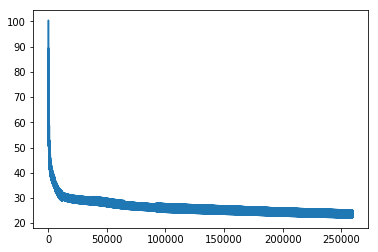

INFO - [631] training...
100%|██████████| 266/266 [00:26<00:00, 10.09it/s]
INFO - [631] training loss:23.051815032958984
INFO - [632] training...
100%|██████████| 266/266 [00:27<00:00,  9.14it/s]
INFO - [632] training loss:23.04924201965332
INFO - [633] training...
100%|██████████| 266/266 [00:26<00:00, 10.14it/s]
INFO - [633] training loss:23.04666519165039
INFO - [634] training...
100%|██████████| 266/266 [00:26<00:00,  9.99it/s]
INFO - [634] training loss:23.044111251831055
INFO - [635] training...
100%|██████████| 266/266 [00:26<00:00,  9.78it/s]
INFO - [635] training loss:23.04155921936035
INFO - [636] training...
100%|██████████| 266/266 [00:25<00:00, 10.49it/s]
INFO - [636] training loss:23.039018630981445
INFO - [637] training...
100%|██████████| 266/266 [00:27<00:00,  9.51it/s]
INFO - [637] training loss:23.03647804260254
INFO - [638] training...
100%|██████████| 266/266 [00:25<00:00,  8.75it/s]
INFO - [638] training loss:23.033958435058594
INFO - [639] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 187.94it/s]INFO - [640] test loss:22.911466598510742

100%|██████████| 15/15 [00:00<00:00, 195.55it/s]INFO - [640] test loss:23.62973976135254

100%|██████████| 22/22 [00:00<00:00, 195.14it/s]INFO - [640] test loss:23.465078353881836

100%|██████████| 14/14 [00:00<00:00, 188.58it/s]INFO - [640] test loss:23.36845588684082

100%|██████████| 19/19 [00:00<00:00, 206.18it/s]INFO - [640] test loss:23.564504623413086

100%|██████████| 23/23 [00:00<00:00, 207.44it/s]INFO - [640] test loss:23.509658813476562

100%|██████████| 15/15 [00:00<00:00, 207.99it/s]INFO - [640] test loss:22.867380142211914

100%|██████████| 16/16 [00:00<00:00, 208.59it/s]INFO - [640] test loss:23.191265106201172

100%|██████████| 16/16 [00:00<00:00, 202.26it/s]INFO - [640] test loss:23.887081146240234

100%|██████████| 18/18 [00:00<00:00, 217.03it/s]INFO - [640] test loss:23.594528198242188

100%|██████████| 18/18 [00:00<00:00, 208.28it/s]INFO - [640] test loss:24.129526138305664

1

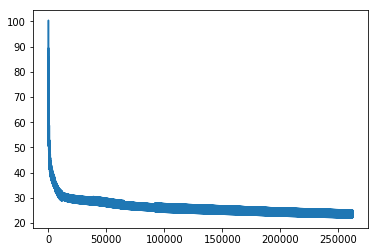

INFO - [641] training...
100%|██████████| 266/266 [00:25<00:00,  9.77it/s]
INFO - [641] training loss:23.026430130004883
INFO - [642] training...
100%|██████████| 266/266 [00:25<00:00, 10.80it/s]
INFO - [642] training loss:23.02393913269043
INFO - [643] training...
100%|██████████| 266/266 [00:26<00:00, 10.36it/s]
INFO - [643] training loss:23.021455764770508
INFO - [644] training...
100%|██████████| 266/266 [00:24<00:00, 10.66it/s]
INFO - [644] training loss:23.018980026245117
INFO - [645] training...
100%|██████████| 266/266 [00:25<00:00, 10.27it/s]
INFO - [645] training loss:23.016508102416992
INFO - [646] training...
100%|██████████| 266/266 [00:26<00:00, 10.11it/s]
INFO - [646] training loss:23.014057159423828
INFO - [647] training...
100%|██████████| 266/266 [00:23<00:00, 12.74it/s]
INFO - [647] training loss:23.011600494384766
INFO - [648] training...
100%|██████████| 266/266 [00:26<00:00, 10.63it/s]
INFO - [648] training loss:23.0091552734375
INFO - [649] training...
100%|█████

100%|██████████| 15/15 [00:00<00:00, 226.89it/s]INFO - [650] test loss:23.60236358642578

100%|██████████| 22/22 [00:00<00:00, 235.76it/s]INFO - [650] test loss:23.43347930908203

100%|██████████| 14/14 [00:00<00:00, 225.51it/s]INFO - [650] test loss:23.343116760253906

100%|██████████| 19/19 [00:00<00:00, 231.29it/s]INFO - [650] test loss:23.536672592163086

100%|██████████| 23/23 [00:00<00:00, 226.19it/s]
INFO - [650] test loss:23.484092712402344

100%|██████████| 15/15 [00:00<00:00, 236.67it/s]INFO - [650] test loss:22.841075897216797

100%|██████████| 16/16 [00:00<00:00, 228.84it/s]INFO - [650] test loss:23.163619995117188

100%|██████████| 16/16 [00:00<00:00, 226.78it/s]INFO - [650] test loss:23.862150192260742

100%|██████████| 18/18 [00:00<00:00, 235.79it/s]INFO - [650] test loss:23.56992530822754

100%|██████████| 18/18 [00:00<00:00, 227.83it/s]INFO - [650] test loss:24.102609634399414

100%|██████████| 16/16 [00:00<00:00, 220.62it/s]INFO - [650] test loss:23.185829162597656

1

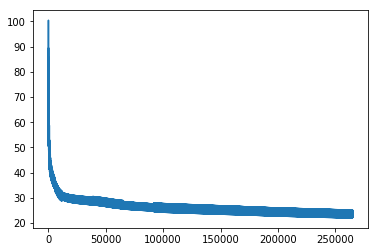

INFO - [651] training...
100%|██████████| 266/266 [00:26<00:00, 10.02it/s]
INFO - [651] training loss:23.001874923706055
INFO - [652] training...
100%|██████████| 266/266 [00:24<00:00, 10.64it/s]
INFO - [652] training loss:22.999465942382812
INFO - [653] training...
100%|██████████| 266/266 [00:25<00:00,  7.95it/s]
INFO - [653] training loss:22.997066497802734
INFO - [654] training...
100%|██████████| 266/266 [00:25<00:00,  9.69it/s]
INFO - [654] training loss:22.99466323852539
INFO - [655] training...
100%|██████████| 266/266 [00:25<00:00, 11.23it/s]
INFO - [655] training loss:22.992279052734375
INFO - [656] training...
100%|██████████| 266/266 [00:25<00:00,  9.87it/s]
INFO - [656] training loss:22.98990249633789
INFO - [657] training...
100%|██████████| 266/266 [00:26<00:00, 10.68it/s]
INFO - [657] training loss:22.987529754638672
INFO - [658] training...
100%|██████████| 266/266 [00:25<00:00, 10.27it/s]
INFO - [658] training loss:22.985166549682617
INFO - [659] training...
100%|████


100%|██████████| 14/14 [00:00<00:00, 210.46it/s]INFO - [660] test loss:22.505874633789062

100%|██████████| 15/15 [00:00<00:00, 201.12it/s]INFO - [660] test loss:23.068010330200195

100%|██████████| 15/15 [00:00<00:00, 178.62it/s]INFO - [660] test loss:22.883554458618164

100%|██████████| 14/14 [00:00<00:00, 188.56it/s]INFO - [660] test loss:23.21268653869629

100%|██████████| 15/15 [00:00<00:00, 136.57it/s]INFO - [660] test loss:23.165746688842773

100%|██████████| 15/15 [00:00<00:00, 203.51it/s]INFO - [660] test loss:22.440534591674805

100%|██████████| 14/14 [00:00<00:00, 180.14it/s]INFO - [660] test loss:22.17571449279785

100%|██████████| 15/15 [00:00<00:00, 206.62it/s]INFO - [660] test loss:23.103374481201172

100%|██████████| 16/16 [00:00<00:00, 207.31it/s]INFO - [660] test loss:23.799890518188477

100%|██████████| 16/16 [00:00<00:00, 212.60it/s]INFO - [660] test loss:22.495357513427734

100%|██████████| 16/16 [00:00<00:00, 207.30it/s]INFO - [660] test loss:23.530065536499023



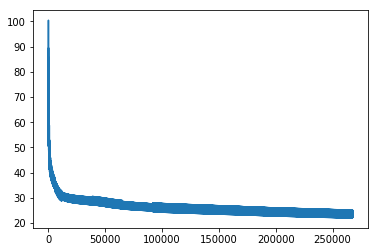

INFO - [661] training...
100%|██████████| 266/266 [00:26<00:00, 10.43it/s]
INFO - [661] training loss:22.97812271118164
INFO - [662] training...
100%|██████████| 266/266 [00:25<00:00, 10.43it/s]
INFO - [662] training loss:22.975784301757812
INFO - [663] training...
100%|██████████| 266/266 [00:26<00:00,  9.81it/s]
INFO - [663] training loss:22.97346305847168
INFO - [664] training...
100%|██████████| 266/266 [00:25<00:00, 11.39it/s]
INFO - [664] training loss:22.971139907836914
INFO - [665] training...
100%|██████████| 266/266 [00:25<00:00, 10.63it/s]
INFO - [665] training loss:22.968830108642578
INFO - [666] training...
100%|██████████| 266/266 [00:25<00:00, 10.34it/s]
INFO - [666] training loss:22.966527938842773
INFO - [667] training...
100%|██████████| 266/266 [00:25<00:00, 10.48it/s]
INFO - [667] training loss:22.9642276763916
INFO - [668] training...
100%|██████████| 266/266 [00:25<00:00, 11.23it/s]
INFO - [668] training loss:22.961936950683594
INFO - [669] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 208.00it/s]INFO - [670] test loss:23.548847198486328

100%|██████████| 14/14 [00:00<00:00, 208.85it/s]INFO - [670] test loss:22.48281478881836

100%|██████████| 15/15 [00:00<00:00, 208.67it/s]INFO - [670] test loss:23.046226501464844

100%|██████████| 15/15 [00:00<00:00, 209.00it/s]INFO - [670] test loss:22.859983444213867

100%|██████████| 14/14 [00:00<00:00, 200.34it/s]INFO - [670] test loss:23.18522834777832

100%|██████████| 15/15 [00:00<00:00, 167.49it/s]INFO - [670] test loss:23.13973617553711

100%|██████████| 15/15 [00:00<00:00, 133.76it/s]INFO - [670] test loss:22.41929817199707

100%|██████████| 14/14 [00:00<00:00, 211.58it/s]INFO - [670] test loss:22.15209197998047

100%|██████████| 15/15 [00:00<00:00, 208.96it/s]INFO - [670] test loss:23.081560134887695

100%|██████████| 16/16 [00:00<00:00, 211.86it/s]INFO - [670] test loss:23.776268005371094

100%|██████████| 16/16 [00:00<00:00, 210.01it/s]INFO - [670] test loss:22.470664978027344

100%

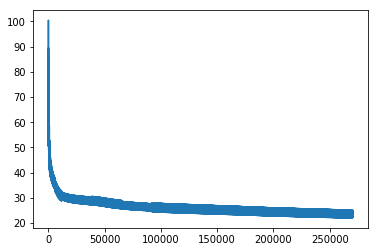

INFO - [671] training...
100%|██████████| 266/266 [00:26<00:00, 10.34it/s]
INFO - [671] training loss:22.95511245727539
INFO - [672] training...
100%|██████████| 266/266 [00:25<00:00, 10.00it/s]
INFO - [672] training loss:22.952848434448242
INFO - [673] training...
100%|██████████| 266/266 [00:26<00:00, 10.13it/s]
INFO - [673] training loss:22.950592041015625
INFO - [674] training...
100%|██████████| 266/266 [00:27<00:00, 10.07it/s]
INFO - [674] training loss:22.948348999023438
INFO - [675] training...
100%|██████████| 266/266 [00:26<00:00, 10.23it/s]
INFO - [675] training loss:22.946107864379883
INFO - [676] training...
100%|██████████| 266/266 [00:25<00:00,  9.76it/s]
INFO - [676] training loss:22.943872451782227
INFO - [677] training...
100%|██████████| 266/266 [00:26<00:00,  8.72it/s]
INFO - [677] training loss:22.9416446685791
INFO - [678] training...
100%|██████████| 266/266 [00:26<00:00, 10.01it/s]
INFO - [678] training loss:22.939424514770508
INFO - [679] training...
100%|█████

100%|██████████| 15/15 [00:00<00:00, 211.60it/s]INFO - [680] test loss:23.52547836303711

100%|██████████| 22/22 [00:00<00:00, 211.14it/s]
INFO - [680] test loss:23.343204498291016

100%|██████████| 14/14 [00:00<00:00, 204.73it/s]INFO - [680] test loss:23.2707462310791

100%|██████████| 19/19 [00:00<00:00, 212.86it/s]INFO - [680] test loss:23.458215713500977

100%|██████████| 23/23 [00:00<00:00, 213.43it/s]INFO - [680] test loss:23.409299850463867

100%|██████████| 15/15 [00:00<00:00, 208.44it/s]INFO - [680] test loss:22.76547622680664

100%|██████████| 16/16 [00:00<00:00, 211.43it/s]INFO - [680] test loss:23.085596084594727

100%|██████████| 16/16 [00:00<00:00, 207.82it/s]INFO - [680] test loss:23.791732788085938

100%|██████████| 18/18 [00:00<00:00, 211.06it/s]INFO - [680] test loss:23.501176834106445

100%|██████████| 18/18 [00:00<00:00, 210.96it/s]INFO - [680] test loss:24.025760650634766

100%|██████████| 16/16 [00:00<00:00, 210.74it/s]INFO - [680] test loss:23.109773635864258

10

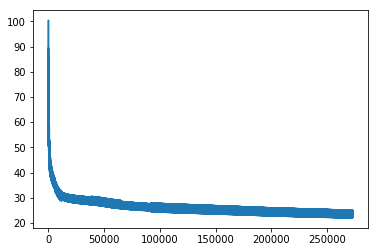

INFO - [681] training...
100%|██████████| 266/266 [00:25<00:00,  9.31it/s]
INFO - [681] training loss:22.93280029296875
INFO - [682] training...
100%|██████████| 266/266 [00:25<00:00, 10.71it/s]
INFO - [682] training loss:22.93060302734375
INFO - [683] training...
100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
INFO - [683] training loss:22.928417205810547
INFO - [684] training...
100%|██████████| 266/266 [00:24<00:00, 11.26it/s]
INFO - [684] training loss:22.92623519897461
INFO - [685] training...
100%|██████████| 266/266 [00:25<00:00, 11.96it/s]
INFO - [685] training loss:22.92405891418457
INFO - [686] training...
100%|██████████| 266/266 [00:25<00:00,  9.21it/s]
INFO - [686] training loss:22.921890258789062
INFO - [687] training...
100%|██████████| 266/266 [00:25<00:00,  9.68it/s]
INFO - [687] training loss:22.91972541809082
INFO - [688] training...
100%|██████████| 266/266 [00:26<00:00, 10.01it/s]
INFO - [688] training loss:22.917570114135742
INFO - [689] training...
100%|███████


100%|██████████| 14/14 [00:00<00:00, 210.32it/s]INFO - [690] test loss:22.43888282775879

100%|██████████| 22/22 [00:00<00:00, 214.71it/s]
INFO - [690] test loss:23.314611434936523
100%|██████████| 15/15 [00:00<00:00, 217.03it/s]INFO - [690] test loss:23.004865646362305

100%|██████████| 15/15 [00:00<00:00, 197.09it/s]INFO - [690] test loss:22.81454849243164

100%|██████████| 14/14 [00:00<00:00, 218.62it/s]INFO - [690] test loss:23.133005142211914

100%|██████████| 23/23 [00:00<00:00, 223.91it/s]
INFO - [690] test loss:23.384965896606445
100%|██████████| 15/15 [00:00<00:00, 216.64it/s]INFO - [690] test loss:23.09041404724121

100%|██████████| 15/15 [00:00<00:00, 206.97it/s]INFO - [690] test loss:22.378982543945312

100%|██████████| 14/14 [00:00<00:00, 222.85it/s]INFO - [690] test loss:22.10675048828125

100%|██████████| 15/15 [00:00<00:00, 151.20it/s]INFO - [690] test loss:23.039573669433594

100%|██████████| 16/16 [00:00<00:00, 215.28it/s]INFO - [690] test loss:23.73094367980957

100

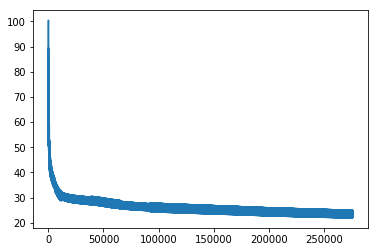

INFO - [691] training...
100%|██████████| 266/266 [00:25<00:00,  9.04it/s]
INFO - [691] training loss:22.911134719848633
INFO - [692] training...
100%|██████████| 266/266 [00:28<00:00,  9.85it/s]
INFO - [692] training loss:22.908998489379883
INFO - [693] training...
100%|██████████| 266/266 [00:26<00:00, 10.98it/s]
INFO - [693] training loss:22.90687370300293
INFO - [694] training...
100%|██████████| 266/266 [00:26<00:00, 10.98it/s]
INFO - [694] training loss:22.90475082397461
INFO - [695] training...
100%|██████████| 266/266 [00:27<00:00,  9.40it/s]
INFO - [695] training loss:22.902637481689453
INFO - [696] training...
100%|██████████| 266/266 [00:26<00:00,  9.10it/s]
INFO - [696] training loss:22.900527954101562
INFO - [697] training...
100%|██████████| 266/266 [00:25<00:00, 10.40it/s]
INFO - [697] training loss:22.89842987060547
INFO - [698] training...
100%|██████████| 266/266 [00:26<00:00, 11.17it/s]
INFO - [698] training loss:22.896326065063477
INFO - [699] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 227.34it/s]INFO - [700] test loss:23.474437713623047

100%|██████████| 14/14 [00:00<00:00, 199.31it/s]INFO - [700] test loss:22.417932510375977

100%|██████████| 15/15 [00:00<00:00, 225.86it/s]INFO - [700] test loss:22.985166549682617

100%|██████████| 15/15 [00:00<00:00, 192.23it/s]INFO - [700] test loss:22.79267120361328

100%|██████████| 14/14 [00:00<00:00, 219.59it/s]INFO - [700] test loss:23.108135223388672

100%|██████████| 15/15 [00:00<00:00, 222.97it/s]INFO - [700] test loss:23.06700325012207

100%|██████████| 15/15 [00:00<00:00, 222.53it/s]INFO - [700] test loss:22.35978126525879

100%|██████████| 14/14 [00:00<00:00, 224.01it/s]INFO - [700] test loss:22.0849609375

100%|██████████| 15/15 [00:00<00:00, 218.82it/s]INFO - [700] test loss:23.019311904907227

100%|██████████| 16/16 [00:00<00:00, 219.83it/s]INFO - [700] test loss:23.70918083190918

100%|██████████| 16/16 [00:00<00:00, 207.87it/s]INFO - [700] test loss:22.4013671875

100%|████████

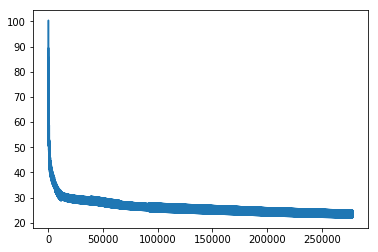

INFO - [701] training...
100%|██████████| 266/266 [00:24<00:00,  8.84it/s]
INFO - [701] training loss:22.89006996154785
INFO - [702] training...
100%|██████████| 266/266 [00:27<00:00,  9.67it/s]
INFO - [702] training loss:22.887990951538086
INFO - [703] training...
100%|██████████| 266/266 [00:25<00:00, 10.61it/s]
INFO - [703] training loss:22.885923385620117
INFO - [704] training...
100%|██████████| 266/266 [00:26<00:00,  9.69it/s]
INFO - [704] training loss:22.883865356445312
INFO - [705] training...
100%|██████████| 266/266 [00:24<00:00, 11.02it/s]
INFO - [705] training loss:22.881805419921875
INFO - [706] training...
100%|██████████| 266/266 [00:27<00:00, 10.75it/s]
INFO - [706] training loss:22.87975311279297
INFO - [707] training...
100%|██████████| 266/266 [00:26<00:00, 10.34it/s]
INFO - [707] training loss:22.877702713012695
INFO - [708] training...
100%|██████████| 266/266 [00:23<00:00,  8.87it/s]
INFO - [708] training loss:22.87566566467285
INFO - [709] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 219.18it/s]INFO - [710] test loss:23.451210021972656

100%|██████████| 14/14 [00:00<00:00, 218.25it/s]INFO - [710] test loss:22.397613525390625

100%|██████████| 15/15 [00:00<00:00, 224.42it/s]INFO - [710] test loss:22.966041564941406

100%|██████████| 15/15 [00:00<00:00, 226.08it/s]INFO - [710] test loss:22.77132225036621

100%|██████████| 14/14 [00:00<00:00, 170.09it/s]INFO - [710] test loss:23.084012985229492

100%|██████████| 15/15 [00:00<00:00, 205.19it/s]INFO - [710] test loss:23.04433250427246

100%|██████████| 15/15 [00:00<00:00, 226.96it/s]INFO - [710] test loss:22.341156005859375

100%|██████████| 14/14 [00:00<00:00, 218.89it/s]INFO - [710] test loss:22.0637264251709

100%|██████████| 15/15 [00:00<00:00, 193.26it/s]INFO - [710] test loss:22.99949836730957

100%|██████████| 16/16 [00:00<00:00, 225.88it/s]INFO - [710] test loss:23.687978744506836

100%|██████████| 16/16 [00:00<00:00, 220.09it/s]INFO - [710] test loss:22.379764556884766

100%

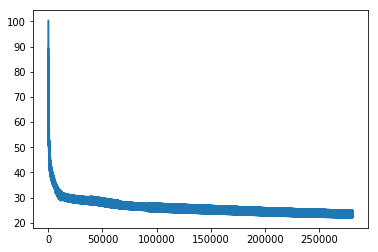

INFO - [711] training...
100%|██████████| 266/266 [00:25<00:00, 10.29it/s]
INFO - [711] training loss:22.86956787109375
INFO - [712] training...
100%|██████████| 266/266 [00:24<00:00,  9.77it/s]
INFO - [712] training loss:22.867551803588867
INFO - [713] training...
100%|██████████| 266/266 [00:26<00:00,  9.98it/s]
INFO - [713] training loss:22.865537643432617
INFO - [714] training...
100%|██████████| 266/266 [00:26<00:00,  9.92it/s]
INFO - [714] training loss:22.863525390625
INFO - [715] training...
100%|██████████| 266/266 [00:24<00:00, 10.83it/s]
INFO - [715] training loss:22.861526489257812
INFO - [716] training...
100%|██████████| 266/266 [00:27<00:00,  9.53it/s]
INFO - [716] training loss:22.859521865844727
INFO - [717] training...
100%|██████████| 266/266 [00:27<00:00, 10.39it/s]
INFO - [717] training loss:22.857532501220703
INFO - [718] training...
100%|██████████| 266/266 [00:23<00:00, 11.53it/s]
INFO - [718] training loss:22.855545043945312
INFO - [719] training...
100%|██████

100%|██████████| 15/15 [00:00<00:00, 229.13it/s]INFO - [720] test loss:23.433744430541992

100%|██████████| 22/22 [00:00<00:00, 148.82it/s]INFO - [720] test loss:23.233055114746094

100%|██████████| 14/14 [00:00<00:00, 223.13it/s]INFO - [720] test loss:23.18226432800293

100%|██████████| 19/19 [00:00<00:00, 222.74it/s]INFO - [720] test loss:23.365234375

100%|██████████| 23/23 [00:00<00:00, 227.04it/s]
INFO - [720] test loss:23.313589096069336

100%|██████████| 15/15 [00:00<00:00, 216.27it/s]INFO - [720] test loss:22.67325210571289

100%|██████████| 16/16 [00:00<00:00, 218.54it/s]INFO - [720] test loss:22.992111206054688

100%|██████████| 16/16 [00:00<00:00, 217.72it/s]INFO - [720] test loss:23.706087112426758

100%|██████████| 18/18 [00:00<00:00, 223.49it/s]INFO - [720] test loss:23.418848037719727

100%|██████████| 18/18 [00:00<00:00, 221.46it/s]INFO - [720] test loss:23.931976318359375

100%|██████████| 16/16 [00:00<00:00, 181.72it/s]INFO - [720] test loss:23.018468856811523

100%|█

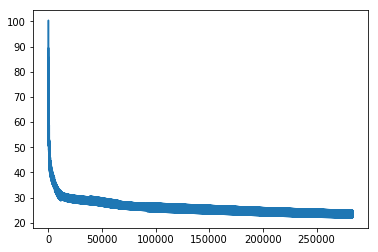

INFO - [721] training...
100%|██████████| 266/266 [00:24<00:00, 11.03it/s]
INFO - [721] training loss:22.849605560302734
INFO - [722] training...
100%|██████████| 266/266 [00:23<00:00, 11.20it/s]
INFO - [722] training loss:22.84763526916504
INFO - [723] training...
100%|██████████| 266/266 [00:23<00:00, 11.24it/s]
INFO - [723] training loss:22.845678329467773
INFO - [724] training...
100%|██████████| 266/266 [00:27<00:00,  9.78it/s]
INFO - [724] training loss:22.843721389770508
INFO - [725] training...
100%|██████████| 266/266 [00:26<00:00,  9.93it/s]
INFO - [725] training loss:22.841768264770508
INFO - [726] training...
100%|██████████| 266/266 [00:26<00:00, 10.44it/s]
INFO - [726] training loss:22.839818954467773
INFO - [727] training...
100%|██████████| 266/266 [00:26<00:00,  9.29it/s]
INFO - [727] training loss:22.837879180908203
INFO - [728] training...
100%|██████████| 266/266 [00:26<00:00, 10.26it/s]
INFO - [728] training loss:22.835935592651367
INFO - [729] training...
100%|███

100%|██████████| 15/15 [00:00<00:00, 213.06it/s]INFO - [730] test loss:23.412471771240234

100%|██████████| 22/22 [00:00<00:00, 228.18it/s]INFO - [730] test loss:23.207239151000977

100%|██████████| 14/14 [00:00<00:00, 217.57it/s]INFO - [730] test loss:23.16140365600586

100%|██████████| 19/19 [00:00<00:00, 221.51it/s]INFO - [730] test loss:23.343868255615234

100%|██████████| 23/23 [00:00<00:00, 232.65it/s]INFO - [730] test loss:23.29033851623535

100%|██████████| 15/15 [00:00<00:00, 229.96it/s]INFO - [730] test loss:22.651697158813477

100%|██████████| 16/16 [00:00<00:00, 226.62it/s]INFO - [730] test loss:22.970355987548828

100%|██████████| 16/16 [00:00<00:00, 218.57it/s]INFO - [730] test loss:23.685958862304688

100%|██████████| 18/18 [00:00<00:00, 221.07it/s]INFO - [730] test loss:23.39957046508789

100%|██████████| 18/18 [00:00<00:00, 222.40it/s]INFO - [730] test loss:23.90996742248535

100%|██████████| 16/16 [00:00<00:00, 229.31it/s]INFO - [730] test loss:22.99725341796875

100%

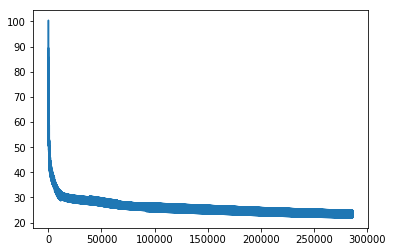

INFO - [731] training...
100%|██████████| 266/266 [00:26<00:00, 10.69it/s]
INFO - [731] training loss:22.83016014099121
INFO - [732] training...
100%|██████████| 266/266 [00:26<00:00, 10.82it/s]
INFO - [732] training loss:22.82823944091797
INFO - [733] training...
100%|██████████| 266/266 [00:25<00:00, 10.41it/s]
INFO - [733] training loss:22.826326370239258
INFO - [734] training...
100%|██████████| 266/266 [00:25<00:00, 10.25it/s]
INFO - [734] training loss:22.824417114257812
INFO - [735] training...
100%|██████████| 266/266 [00:26<00:00, 10.55it/s]
INFO - [735] training loss:22.822519302368164
INFO - [736] training...
100%|██████████| 266/266 [00:25<00:00,  9.64it/s]
INFO - [736] training loss:22.82062339782715
INFO - [737] training...
100%|██████████| 266/266 [00:22<00:00, 12.64it/s]
INFO - [737] training loss:22.818729400634766
INFO - [738] training...
100%|██████████| 266/266 [00:22<00:00, 11.75it/s]
INFO - [738] training loss:22.816844940185547
INFO - [739] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 203.87it/s]INFO - [740] test loss:23.38541603088379

100%|██████████| 15/15 [00:00<00:00, 143.54it/s]
INFO - [740] test loss:23.391799926757812
100%|██████████| 14/14 [00:00<00:00, 151.25it/s]INFO - [740] test loss:22.340126037597656

100%|██████████| 15/15 [00:00<00:00, 212.24it/s]INFO - [740] test loss:22.911666870117188

100%|██████████| 15/15 [00:00<00:00, 213.18it/s]INFO - [740] test loss:22.71026611328125

100%|██████████| 14/14 [00:00<00:00, 135.91it/s]
INFO - [740] test loss:23.015668869018555

100%|██████████| 15/15 [00:00<00:00, 151.49it/s]INFO - [740] test loss:22.98015022277832

100%|██████████| 15/15 [00:00<00:00, 221.44it/s]INFO - [740] test loss:22.2884464263916

100%|██████████| 14/14 [00:00<00:00, 232.00it/s]INFO - [740] test loss:22.003196716308594

100%|██████████| 15/15 [00:00<00:00, 221.67it/s]INFO - [740] test loss:22.942441940307617

100%|██████████| 16/16 [00:00<00:00, 223.70it/s]INFO - [740] test loss:23.6274356842041

100%|

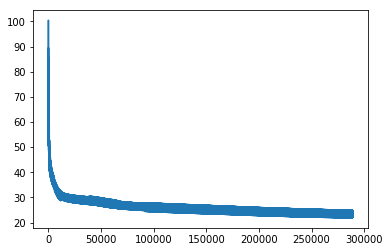

INFO - [741] training...
100%|██████████| 266/266 [00:26<00:00, 10.10it/s]
INFO - [741] training loss:22.81121063232422
INFO - [742] training...
100%|██████████| 266/266 [00:27<00:00,  9.65it/s]
INFO - [742] training loss:22.809341430664062
INFO - [743] training...
100%|██████████| 266/266 [00:25<00:00, 10.28it/s]
INFO - [743] training loss:22.807472229003906
INFO - [744] training...
100%|██████████| 266/266 [00:26<00:00,  9.94it/s]
INFO - [744] training loss:22.805618286132812
INFO - [745] training...
100%|██████████| 266/266 [00:25<00:00,  9.66it/s]
INFO - [745] training loss:22.80376434326172
INFO - [746] training...
100%|██████████| 266/266 [00:22<00:00, 11.86it/s]
INFO - [746] training loss:22.80191421508789
INFO - [747] training...
100%|██████████| 266/266 [00:26<00:00,  9.86it/s]
INFO - [747] training loss:22.800071716308594
INFO - [748] training...
100%|██████████| 266/266 [00:25<00:00,  9.50it/s]
INFO - [748] training loss:22.79823112487793
INFO - [749] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 214.69it/s]INFO - [750] test loss:23.364635467529297

100%|██████████| 14/14 [00:00<00:00, 216.19it/s]INFO - [750] test loss:22.322021484375

100%|██████████| 22/22 [00:00<00:00, 217.47it/s]
INFO - [750] test loss:23.157588958740234
100%|██████████| 15/15 [00:00<00:00, 214.25it/s]INFO - [750] test loss:22.894432067871094

100%|██████████| 15/15 [00:00<00:00, 194.30it/s]INFO - [750] test loss:22.690847396850586

100%|██████████| 14/14 [00:00<00:00, 197.43it/s]INFO - [750] test loss:22.994102478027344

100%|██████████| 15/15 [00:00<00:00, 201.30it/s]INFO - [750] test loss:22.959842681884766

100%|██████████| 15/15 [00:00<00:00, 206.29it/s]INFO - [750] test loss:22.271875381469727

100%|██████████| 14/14 [00:00<00:00, 199.14it/s]INFO - [750] test loss:21.984025955200195

100%|██████████| 15/15 [00:00<00:00, 202.51it/s]INFO - [750] test loss:22.924144744873047

100%|██████████| 16/16 [00:00<00:00, 129.39it/s]INFO - [750] test loss:23.608192443847656

10

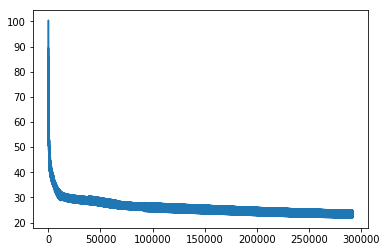

INFO - [751] training...
100%|██████████| 266/266 [00:27<00:00,  9.73it/s]
INFO - [751] training loss:22.792736053466797
INFO - [752] training...
100%|██████████| 266/266 [00:25<00:00, 10.46it/s]
INFO - [752] training loss:22.790912628173828
INFO - [753] training...
100%|██████████| 266/266 [00:24<00:00, 10.64it/s]
INFO - [753] training loss:22.789098739624023
INFO - [754] training...
100%|██████████| 266/266 [00:25<00:00,  9.74it/s]
INFO - [754] training loss:22.78728485107422
INFO - [755] training...
100%|██████████| 266/266 [00:24<00:00, 11.07it/s]
INFO - [755] training loss:22.785476684570312
INFO - [756] training...
100%|██████████| 266/266 [00:25<00:00,  9.74it/s]
INFO - [756] training loss:22.78367042541504
INFO - [757] training...
100%|██████████| 266/266 [00:26<00:00, 10.22it/s]
INFO - [757] training loss:22.781871795654297
INFO - [758] training...
100%|██████████| 266/266 [00:26<00:00,  9.60it/s]
INFO - [758] training loss:22.780078887939453
INFO - [759] training...
100%|████

100%|██████████| 16/16 [00:00<00:00, 213.79it/s]INFO - [760] test loss:23.344379425048828

100%|██████████| 14/14 [00:00<00:00, 213.59it/s]INFO - [760] test loss:22.304401397705078

100%|██████████| 22/22 [00:00<00:00, 216.62it/s]
INFO - [760] test loss:23.133718490600586
100%|██████████| 15/15 [00:00<00:00, 209.97it/s]INFO - [760] test loss:22.87758445739746

100%|██████████| 15/15 [00:00<00:00, 216.17it/s]INFO - [760] test loss:22.671865463256836

100%|██████████| 14/14 [00:00<00:00, 134.03it/s]
INFO - [760] test loss:22.973087310791016

100%|██████████| 15/15 [00:00<00:00, 206.13it/s]INFO - [760] test loss:22.93999481201172

100%|██████████| 15/15 [00:00<00:00, 208.52it/s]INFO - [760] test loss:22.255762100219727

100%|██████████| 14/14 [00:00<00:00, 210.10it/s]INFO - [760] test loss:21.965333938598633

100%|██████████| 15/15 [00:00<00:00, 213.45it/s]INFO - [760] test loss:22.906179428100586

100%|██████████| 16/16 [00:00<00:00, 160.01it/s]INFO - [760] test loss:23.589385986328125



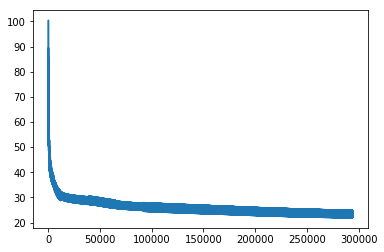

INFO - [761] training...
100%|██████████| 266/266 [00:25<00:00, 10.07it/s]
INFO - [761] training loss:22.774721145629883
INFO - [762] training...
100%|██████████| 266/266 [00:25<00:00, 10.31it/s]
INFO - [762] training loss:22.7729434967041
INFO - [763] training...
100%|██████████| 266/266 [00:26<00:00, 10.15it/s]
INFO - [763] training loss:22.771169662475586
INFO - [764] training...
100%|██████████| 266/266 [00:26<00:00,  8.99it/s]
INFO - [764] training loss:22.769407272338867
INFO - [765] training...
100%|██████████| 266/266 [00:24<00:00, 10.86it/s]
INFO - [765] training loss:22.767635345458984
INFO - [766] training...
100%|██████████| 266/266 [00:25<00:00, 10.82it/s]
INFO - [766] training loss:22.76588249206543
INFO - [767] training...
100%|██████████| 266/266 [00:23<00:00, 11.98it/s]
INFO - [767] training loss:22.764122009277344
INFO - [768] training...
100%|██████████| 266/266 [00:24<00:00,  9.96it/s]
INFO - [768] training loss:22.762371063232422
INFO - [769] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 204.57it/s]INFO - [770] test loss:22.62202262878418

100%|██████████| 15/15 [00:00<00:00, 132.87it/s]INFO - [770] test loss:23.33316993713379

100%|██████████| 22/22 [00:00<00:00, 202.55it/s]INFO - [770] test loss:23.110450744628906

100%|██████████| 14/14 [00:00<00:00, 169.76it/s]INFO - [770] test loss:23.082197189331055

100%|██████████| 19/19 [00:00<00:00, 202.21it/s]INFO - [770] test loss:23.264877319335938

100%|██████████| 23/23 [00:00<00:00, 198.63it/s]INFO - [770] test loss:23.200088500976562

100%|██████████| 15/15 [00:00<00:00, 203.98it/s]INFO - [770] test loss:22.571090698242188

100%|██████████| 16/16 [00:00<00:00, 201.92it/s]INFO - [770] test loss:22.888683319091797

100%|██████████| 16/16 [00:00<00:00, 214.03it/s]INFO - [770] test loss:23.609994888305664

100%|██████████| 18/18 [00:00<00:00, 208.45it/s]INFO - [770] test loss:23.3266544342041

100%|██████████| 18/18 [00:00<00:00, 214.54it/s]INFO - [770] test loss:23.82720947265625

100%

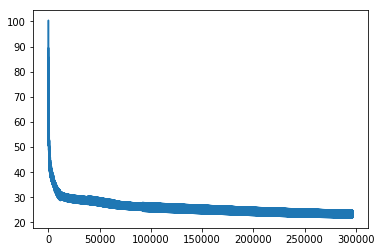

INFO - [771] training...
100%|██████████| 266/266 [00:26<00:00, 11.70it/s]
INFO - [771] training loss:22.757143020629883
INFO - [772] training...
100%|██████████| 266/266 [00:26<00:00,  9.87it/s]
INFO - [772] training loss:22.755407333374023
INFO - [773] training...
100%|██████████| 266/266 [00:25<00:00, 10.34it/s]
INFO - [773] training loss:22.753679275512695
INFO - [774] training...
100%|██████████| 266/266 [00:26<00:00, 10.00it/s]
INFO - [774] training loss:22.751949310302734
INFO - [775] training...
100%|██████████| 266/266 [00:26<00:00, 10.02it/s]
INFO - [775] training loss:22.750228881835938
INFO - [776] training...
100%|██████████| 266/266 [00:26<00:00,  9.94it/s]
INFO - [776] training loss:22.748512268066406
INFO - [777] training...
100%|██████████| 266/266 [00:27<00:00,  9.03it/s]
INFO - [777] training loss:22.746797561645508
INFO - [778] training...
100%|██████████| 266/266 [00:27<00:00,  9.72it/s]
INFO - [778] training loss:22.74508285522461
INFO - [779] training...
100%|███

100%|██████████| 14/14 [00:00<00:00, 215.23it/s]INFO - [780] test loss:22.27043914794922

100%|██████████| 22/22 [00:00<00:00, 214.63it/s]
INFO - [780] test loss:23.087726593017578
100%|██████████| 15/15 [00:00<00:00, 211.95it/s]INFO - [780] test loss:22.84494400024414

100%|██████████| 15/15 [00:00<00:00, 131.00it/s]INFO - [780] test loss:22.635099411010742

100%|██████████| 14/14 [00:00<00:00, 201.63it/s]INFO - [780] test loss:22.932579040527344

100%|██████████| 15/15 [00:00<00:00, 207.20it/s]INFO - [780] test loss:22.90150260925293

100%|██████████| 15/15 [00:00<00:00, 196.11it/s]INFO - [780] test loss:22.224828720092773

100%|██████████| 14/14 [00:00<00:00, 222.40it/s]INFO - [780] test loss:21.929285049438477

100%|██████████| 15/15 [00:00<00:00, 224.45it/s]INFO - [780] test loss:22.871164321899414

100%|██████████| 16/16 [00:00<00:00, 221.31it/s]INFO - [780] test loss:23.55295181274414

100%|██████████| 16/16 [00:00<00:00, 226.66it/s]INFO - [780] test loss:22.24578094482422

100%

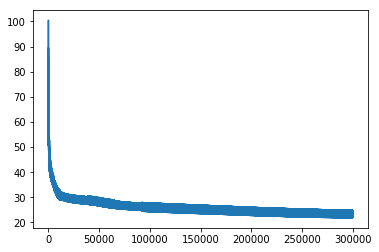

INFO - [781] training...
100%|██████████| 266/266 [00:27<00:00, 11.59it/s]
INFO - [781] training loss:22.739980697631836
INFO - [782] training...
100%|██████████| 266/266 [00:22<00:00, 11.99it/s]
INFO - [782] training loss:22.738283157348633
INFO - [783] training...
100%|██████████| 266/266 [00:21<00:00, 12.24it/s]
INFO - [783] training loss:22.73659324645996
INFO - [784] training...
100%|██████████| 266/266 [00:26<00:00, 10.99it/s]
INFO - [784] training loss:22.734901428222656
INFO - [785] training...
100%|██████████| 266/266 [00:26<00:00,  9.66it/s]
INFO - [785] training loss:22.73322296142578
INFO - [786] training...
100%|██████████| 266/266 [00:25<00:00, 10.49it/s]
INFO - [786] training loss:22.731542587280273
INFO - [787] training...
100%|██████████| 266/266 [00:27<00:00,  9.73it/s]
INFO - [787] training loss:22.729867935180664
INFO - [788] training...
100%|██████████| 266/266 [00:22<00:00, 11.57it/s]
INFO - [788] training loss:22.72819709777832
INFO - [789] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 224.59it/s]INFO - [790] test loss:23.286293029785156

100%|██████████| 14/14 [00:00<00:00, 194.15it/s]INFO - [790] test loss:22.2540340423584

100%|██████████| 22/22 [00:00<00:00, 217.90it/s]
INFO - [790] test loss:23.065536499023438
100%|██████████| 15/15 [00:00<00:00, 211.71it/s]INFO - [790] test loss:22.82911491394043

100%|██████████| 15/15 [00:00<00:00, 214.01it/s]INFO - [790] test loss:22.617263793945312

100%|██████████| 14/14 [00:00<00:00, 215.74it/s]INFO - [790] test loss:22.913034439086914

100%|██████████| 15/15 [00:00<00:00, 172.45it/s]INFO - [790] test loss:22.882780075073242

100%|██████████| 15/15 [00:00<00:00, 184.01it/s]INFO - [790] test loss:22.209943771362305

100%|██████████| 14/14 [00:00<00:00, 160.78it/s]INFO - [790] test loss:21.911884307861328

100%|██████████| 15/15 [00:00<00:00, 214.70it/s]INFO - [790] test loss:22.854084014892578

100%|██████████| 16/16 [00:00<00:00, 213.26it/s]INFO - [790] test loss:23.53528594970703

100

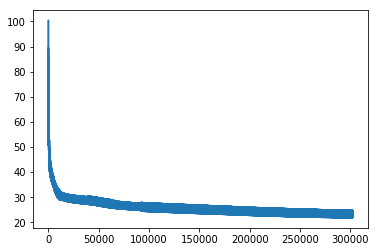

INFO - [791] training...
100%|██████████| 266/266 [00:27<00:00, 10.13it/s]
INFO - [791] training loss:22.723201751708984
INFO - [792] training...
100%|██████████| 266/266 [00:26<00:00, 10.27it/s]
INFO - [792] training loss:22.72154998779297
INFO - [793] training...
100%|██████████| 266/266 [00:27<00:00,  9.74it/s]
INFO - [793] training loss:22.719892501831055
INFO - [794] training...
100%|██████████| 266/266 [00:26<00:00, 11.11it/s]
INFO - [794] training loss:22.718244552612305
INFO - [795] training...
100%|██████████| 266/266 [00:26<00:00, 10.73it/s]
INFO - [795] training loss:22.716596603393555
INFO - [796] training...
100%|██████████| 266/266 [00:25<00:00, 10.34it/s]
INFO - [796] training loss:22.71495819091797
INFO - [797] training...
100%|██████████| 266/266 [00:22<00:00, 11.97it/s]
INFO - [797] training loss:22.713321685791016
INFO - [798] training...
100%|██████████| 266/266 [00:26<00:00,  8.81it/s]
INFO - [798] training loss:22.711685180664062
INFO - [799] training...
100%|████

100%|██████████| 14/14 [00:00<00:00, 212.54it/s]INFO - [800] test loss:22.237974166870117

100%|██████████| 15/15 [00:00<00:00, 132.31it/s]INFO - [800] test loss:22.81357192993164

100%|██████████| 15/15 [00:00<00:00, 212.28it/s]INFO - [800] test loss:22.599756240844727

100%|██████████| 14/14 [00:00<00:00, 217.76it/s]INFO - [800] test loss:22.893911361694336

100%|██████████| 23/23 [00:00<00:00, 222.88it/s]
INFO - [800] test loss:23.13517189025879
100%|██████████| 15/15 [00:00<00:00, 223.22it/s]INFO - [800] test loss:22.864364624023438

100%|██████████| 15/15 [00:00<00:00, 179.07it/s]INFO - [800] test loss:22.195411682128906

100%|██████████| 14/14 [00:00<00:00, 215.99it/s]INFO - [800] test loss:21.894874572753906

100%|██████████| 15/15 [00:00<00:00, 226.04it/s]INFO - [800] test loss:22.83727264404297

100%|██████████| 16/16 [00:00<00:00, 222.15it/s]INFO - [800] test loss:23.517961502075195

100%|██████████| 16/16 [00:00<00:00, 223.77it/s]INFO - [800] test loss:22.211904525756836

10

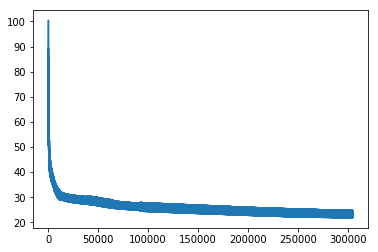

INFO - [801] training...
100%|██████████| 266/266 [00:25<00:00, 10.69it/s]
INFO - [801] training loss:22.70680046081543
INFO - [802] training...
100%|██████████| 266/266 [00:24<00:00, 10.94it/s]
INFO - [802] training loss:22.705183029174805
INFO - [803] training...
100%|██████████| 266/266 [00:24<00:00, 11.17it/s]
INFO - [803] training loss:22.70356559753418
INFO - [804] training...
100%|██████████| 266/266 [00:24<00:00, 10.38it/s]
INFO - [804] training loss:22.70195198059082
INFO - [805] training...
100%|██████████| 266/266 [00:24<00:00, 10.86it/s]
INFO - [805] training loss:22.700342178344727
INFO - [806] training...
100%|██████████| 266/266 [00:23<00:00, 11.19it/s]
INFO - [806] training loss:22.698728561401367
INFO - [807] training...
100%|██████████| 266/266 [00:25<00:00,  9.87it/s]
INFO - [807] training loss:22.69713020324707
INFO - [808] training...
100%|██████████| 266/266 [00:26<00:00, 10.87it/s]
INFO - [808] training loss:22.695528030395508
INFO - [809] training...
100%|██████


100%|██████████| 14/14 [00:00<00:00, 230.21it/s]INFO - [810] test loss:22.222227096557617

100%|██████████| 15/15 [00:00<00:00, 225.34it/s]INFO - [810] test loss:22.798315048217773

100%|██████████| 15/15 [00:00<00:00, 231.11it/s]INFO - [810] test loss:22.582548141479492

100%|██████████| 14/14 [00:00<00:00, 230.33it/s]INFO - [810] test loss:22.875200271606445

100%|██████████| 15/15 [00:00<00:00, 230.42it/s]INFO - [810] test loss:22.846229553222656

100%|██████████| 15/15 [00:00<00:00, 230.60it/s]INFO - [810] test loss:22.181203842163086

100%|██████████| 14/14 [00:00<00:00, 226.63it/s]INFO - [810] test loss:21.878232955932617

100%|██████████| 15/15 [00:00<00:00, 236.85it/s]INFO - [810] test loss:22.82071876525879

100%|██████████| 16/16 [00:00<00:00, 232.39it/s]INFO - [810] test loss:23.500951766967773

100%|██████████| 16/16 [00:00<00:00, 231.25it/s]INFO - [810] test loss:22.195531845092773

100%|██████████| 16/16 [00:00<00:00, 233.33it/s]INFO - [810] test loss:23.213760375976562


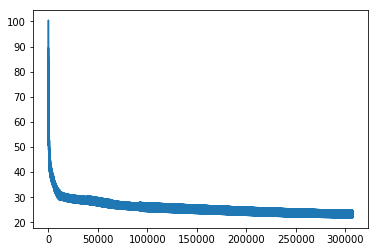

INFO - [811] training...
100%|██████████| 266/266 [00:25<00:00,  9.68it/s]
INFO - [811] training loss:22.69074821472168
INFO - [812] training...
100%|██████████| 266/266 [00:26<00:00,  9.70it/s]
INFO - [812] training loss:22.689165115356445
INFO - [813] training...
100%|██████████| 266/266 [00:28<00:00,  7.89it/s]
INFO - [813] training loss:22.68758201599121
INFO - [814] training...
100%|██████████| 266/266 [00:27<00:00, 10.15it/s]
INFO - [814] training loss:22.68600082397461
INFO - [815] training...
100%|██████████| 266/266 [00:26<00:00,  7.83it/s]
INFO - [815] training loss:22.68442153930664
INFO - [816] training...
100%|██████████| 266/266 [00:26<00:00, 10.12it/s]
INFO - [816] training loss:22.682849884033203
INFO - [817] training...
100%|██████████| 266/266 [00:23<00:00, 12.44it/s]
INFO - [817] training loss:22.6812801361084
INFO - [818] training...
100%|██████████| 266/266 [00:20<00:00, 12.68it/s]
INFO - [818] training loss:22.67970848083496
INFO - [819] training...
100%|█████████


100%|██████████| 14/14 [00:00<00:00, 193.83it/s]INFO - [820] test loss:22.206769943237305

100%|██████████| 15/15 [00:00<00:00, 144.56it/s]
INFO - [820] test loss:22.7833251953125

100%|██████████| 15/15 [00:00<00:00, 208.70it/s]INFO - [820] test loss:22.56561851501465

100%|██████████| 14/14 [00:00<00:00, 214.34it/s]INFO - [820] test loss:22.856884002685547

100%|██████████| 15/15 [00:00<00:00, 211.86it/s]INFO - [820] test loss:22.82835578918457

100%|██████████| 15/15 [00:00<00:00, 229.74it/s]INFO - [820] test loss:22.167308807373047

100%|██████████| 14/14 [00:00<00:00, 226.04it/s]INFO - [820] test loss:21.861940383911133

100%|██████████| 15/15 [00:00<00:00, 226.27it/s]INFO - [820] test loss:22.80440902709961

100%|██████████| 16/16 [00:00<00:00, 228.64it/s]INFO - [820] test loss:23.484249114990234

100%|██████████| 16/16 [00:00<00:00, 227.30it/s]INFO - [820] test loss:22.17950439453125

100%|██████████| 16/16 [00:00<00:00, 225.91it/s]INFO - [820] test loss:23.195985794067383

100

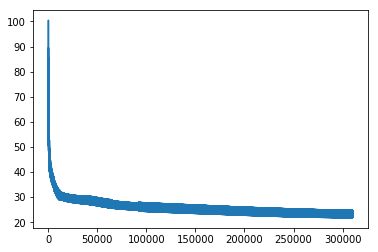

INFO - [821] training...
100%|██████████| 266/266 [00:28<00:00,  9.30it/s]
INFO - [821] training loss:22.675025939941406
INFO - [822] training...
100%|██████████| 266/266 [00:26<00:00, 11.65it/s]
INFO - [822] training loss:22.673473358154297
INFO - [823] training...
100%|██████████| 266/266 [00:24<00:00, 10.15it/s]
INFO - [823] training loss:22.671918869018555
INFO - [824] training...
100%|██████████| 266/266 [00:24<00:00, 10.89it/s]
INFO - [824] training loss:22.67037010192871
INFO - [825] training...
100%|██████████| 266/266 [00:21<00:00,  9.28it/s]
INFO - [825] training loss:22.668825149536133
INFO - [826] training...
100%|██████████| 266/266 [00:24<00:00, 10.71it/s]
INFO - [826] training loss:22.66728401184082
INFO - [827] training...
100%|██████████| 266/266 [00:25<00:00,  8.71it/s]
INFO - [827] training loss:22.665739059448242
INFO - [828] training...
100%|██████████| 266/266 [00:26<00:00, 11.35it/s]
INFO - [828] training loss:22.664201736450195
INFO - [829] training...
100%|████

100%|██████████| 16/16 [00:00<00:00, 217.82it/s]INFO - [830] test loss:23.21385383605957

100%|██████████| 14/14 [00:00<00:00, 213.53it/s]INFO - [830] test loss:22.191593170166016

100%|██████████| 22/22 [00:00<00:00, 218.03it/s]
INFO - [830] test loss:22.981630325317383
100%|██████████| 15/15 [00:00<00:00, 214.13it/s]INFO - [830] test loss:22.768611907958984

100%|██████████| 15/15 [00:00<00:00, 218.12it/s]INFO - [830] test loss:22.548948287963867

100%|██████████| 14/14 [00:00<00:00, 214.57it/s]INFO - [830] test loss:22.838930130004883

100%|██████████| 23/23 [00:00<00:00, 220.52it/s]
INFO - [830] test loss:23.072521209716797
100%|██████████| 15/15 [00:00<00:00, 213.61it/s]INFO - [830] test loss:22.810718536376953

100%|██████████| 15/15 [00:00<00:00, 215.51it/s]INFO - [830] test loss:22.153697967529297

100%|██████████| 14/14 [00:00<00:00, 213.19it/s]INFO - [830] test loss:21.84598731994629

100%|██████████| 15/15 [00:00<00:00, 215.89it/s]INFO - [830] test loss:22.788333892822266

1

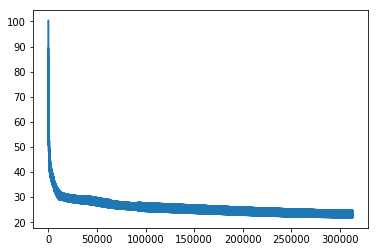

INFO - [831] training...
100%|██████████| 266/266 [00:24<00:00,  9.49it/s]
INFO - [831] training loss:22.65960693359375
INFO - [832] training...
100%|██████████| 266/266 [00:24<00:00, 10.96it/s]
INFO - [832] training loss:22.658082962036133
INFO - [833] training...
100%|██████████| 266/266 [00:24<00:00, 11.74it/s]
INFO - [833] training loss:22.656557083129883
INFO - [834] training...
100%|██████████| 266/266 [00:25<00:00,  9.60it/s]
INFO - [834] training loss:22.655040740966797
INFO - [835] training...
100%|██████████| 266/266 [00:26<00:00,  9.37it/s]
INFO - [835] training loss:22.653522491455078
INFO - [836] training...
100%|██████████| 266/266 [00:25<00:00,  8.55it/s]
INFO - [836] training loss:22.652008056640625
INFO - [837] training...
100%|██████████| 266/266 [00:26<00:00, 11.16it/s]
INFO - [837] training loss:22.650495529174805
INFO - [838] training...
100%|██████████| 266/266 [00:27<00:00,  9.73it/s]
INFO - [838] training loss:22.648984909057617
INFO - [839] training...
100%|███

100%|██████████| 16/16 [00:00<00:00, 236.22it/s]INFO - [840] test loss:23.196455001831055

100%|██████████| 14/14 [00:00<00:00, 236.24it/s]INFO - [840] test loss:22.176677703857422

100%|██████████| 15/15 [00:00<00:00, 228.41it/s]INFO - [840] test loss:22.7541561126709

100%|██████████| 15/15 [00:00<00:00, 231.75it/s]INFO - [840] test loss:22.53252601623535

100%|██████████| 14/14 [00:00<00:00, 234.03it/s]INFO - [840] test loss:22.821306228637695

100%|██████████| 15/15 [00:00<00:00, 231.98it/s]INFO - [840] test loss:22.793317794799805

100%|██████████| 15/15 [00:00<00:00, 236.48it/s]INFO - [840] test loss:22.14035415649414

100%|██████████| 14/14 [00:00<00:00, 226.18it/s]INFO - [840] test loss:21.830352783203125

100%|██████████| 15/15 [00:00<00:00, 237.35it/s]INFO - [840] test loss:22.77248191833496

100%|██████████| 16/16 [00:00<00:00, 231.75it/s]INFO - [840] test loss:23.451709747314453

100%|██████████| 16/16 [00:00<00:00, 229.10it/s]INFO - [840] test loss:22.148395538330078

100%

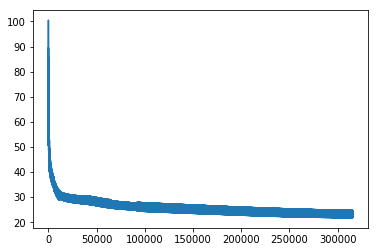

INFO - [841] training...
100%|██████████| 266/266 [00:28<00:00,  9.45it/s]
INFO - [841] training loss:22.644472122192383
INFO - [842] training...
100%|██████████| 266/266 [00:26<00:00,  9.44it/s]
INFO - [842] training loss:22.642974853515625
INFO - [843] training...
100%|██████████| 266/266 [00:27<00:00,  9.59it/s]
INFO - [843] training loss:22.641481399536133
INFO - [844] training...
100%|██████████| 266/266 [00:26<00:00,  9.42it/s]
INFO - [844] training loss:22.639989852905273
INFO - [845] training...
100%|██████████| 266/266 [00:28<00:00,  8.79it/s]
INFO - [845] training loss:22.63850212097168
INFO - [846] training...
100%|██████████| 266/266 [00:27<00:00,  9.87it/s]
INFO - [846] training loss:22.637008666992188
INFO - [847] training...
100%|██████████| 266/266 [00:27<00:00,  9.84it/s]
INFO - [847] training loss:22.63552474975586
INFO - [848] training...
100%|██████████| 266/266 [00:26<00:00, 10.09it/s]
INFO - [848] training loss:22.634044647216797
INFO - [849] training...
100%|████

100%|██████████| 16/16 [00:00<00:00, 224.71it/s]INFO - [850] test loss:23.179309844970703

100%|██████████| 14/14 [00:00<00:00, 224.82it/s]INFO - [850] test loss:22.16201400756836

100%|██████████| 15/15 [00:00<00:00, 225.25it/s]INFO - [850] test loss:22.73995590209961

100%|██████████| 15/15 [00:00<00:00, 225.67it/s]INFO - [850] test loss:22.516340255737305

100%|██████████| 14/14 [00:00<00:00, 230.18it/s]INFO - [850] test loss:22.80400276184082

100%|██████████| 15/15 [00:00<00:00, 215.72it/s]INFO - [850] test loss:22.77613639831543

100%|██████████| 15/15 [00:00<00:00, 214.00it/s]INFO - [850] test loss:22.127277374267578

100%|██████████| 14/14 [00:00<00:00, 212.81it/s]INFO - [850] test loss:21.815019607543945

100%|██████████| 15/15 [00:00<00:00, 158.23it/s]INFO - [850] test loss:22.75684928894043

100%|██████████| 16/16 [00:00<00:00, 227.40it/s]INFO - [850] test loss:23.43584442138672

100%|██████████| 16/16 [00:00<00:00, 128.39it/s]INFO - [850] test loss:22.13327407836914

100%|█

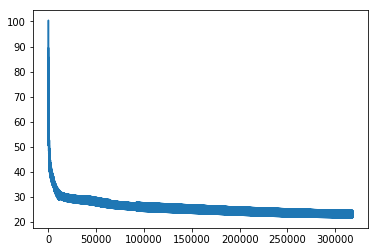

INFO - [851] training...
100%|██████████| 266/266 [00:27<00:00,  9.75it/s]
INFO - [851] training loss:22.629606246948242
INFO - [852] training...
100%|██████████| 266/266 [00:27<00:00,  9.62it/s]
INFO - [852] training loss:22.628135681152344
INFO - [853] training...
100%|██████████| 266/266 [00:26<00:00,  9.71it/s]
INFO - [853] training loss:22.626667022705078
INFO - [854] training...
100%|██████████| 266/266 [00:24<00:00, 10.49it/s]
INFO - [854] training loss:22.62520408630371
INFO - [855] training...
100%|██████████| 266/266 [00:25<00:00, 10.36it/s]
INFO - [855] training loss:22.62373161315918
INFO - [856] training...
100%|██████████| 266/266 [00:29<00:00,  9.06it/s]
INFO - [856] training loss:22.622272491455078
INFO - [857] training...
100%|██████████| 266/266 [00:21<00:00, 12.11it/s]
INFO - [857] training loss:22.62080955505371
INFO - [858] training...
100%|██████████| 266/266 [00:22<00:00,  9.91it/s]
INFO - [858] training loss:22.619354248046875
INFO - [859] training...
100%|█████

100%|██████████| 14/14 [00:00<00:00, 214.37it/s]INFO - [860] test loss:22.147602081298828

100%|██████████| 22/22 [00:00<00:00, 218.65it/s]
INFO - [860] test loss:22.923742294311523
100%|██████████| 15/15 [00:00<00:00, 217.71it/s]INFO - [860] test loss:22.72602653503418

100%|██████████| 15/15 [00:00<00:00, 217.35it/s]INFO - [860] test loss:22.500404357910156

100%|██████████| 14/14 [00:00<00:00, 219.85it/s]INFO - [860] test loss:22.786991119384766

100%|██████████| 23/23 [00:00<00:00, 220.84it/s]
INFO - [860] test loss:23.012592315673828
100%|██████████| 15/15 [00:00<00:00, 217.02it/s]INFO - [860] test loss:22.759178161621094

100%|██████████| 15/15 [00:00<00:00, 217.30it/s]INFO - [860] test loss:22.11444854736328

100%|██████████| 14/14 [00:00<00:00, 217.96it/s]INFO - [860] test loss:21.79998779296875

100%|██████████| 15/15 [00:00<00:00, 219.88it/s]INFO - [860] test loss:22.741422653198242

100%|██████████| 16/16 [00:00<00:00, 218.48it/s]INFO - [860] test loss:23.420238494873047

10

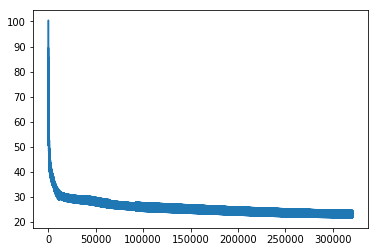

INFO - [861] training...
100%|██████████| 266/266 [00:24<00:00, 10.89it/s]
INFO - [861] training loss:22.614992141723633
INFO - [862] training...
100%|██████████| 266/266 [00:25<00:00, 11.20it/s]
INFO - [862] training loss:22.613544464111328
INFO - [863] training...
100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
INFO - [863] training loss:22.61209487915039
INFO - [864] training...
100%|██████████| 266/266 [00:23<00:00,  8.62it/s]
INFO - [864] training loss:22.610654830932617
INFO - [865] training...
100%|██████████| 266/266 [00:26<00:00, 12.50it/s]
INFO - [865] training loss:22.60921287536621
INFO - [866] training...
100%|██████████| 266/266 [00:20<00:00, 12.68it/s]
INFO - [866] training loss:22.607770919799805
INFO - [867] training...
100%|██████████| 266/266 [00:26<00:00,  9.70it/s]
INFO - [867] training loss:22.606334686279297
INFO - [868] training...
100%|██████████| 266/266 [00:27<00:00, 10.47it/s]
INFO - [868] training loss:22.604900360107422
INFO - [869] training...
100%|████


100%|██████████| 14/14 [00:00<00:00, 211.16it/s]INFO - [870] test loss:22.133438110351562

100%|██████████| 15/15 [00:00<00:00, 200.68it/s]INFO - [870] test loss:22.712364196777344

100%|██████████| 15/15 [00:00<00:00, 202.83it/s]INFO - [870] test loss:22.484725952148438

100%|██████████| 14/14 [00:00<00:00, 204.00it/s]INFO - [870] test loss:22.770248413085938

100%|██████████| 15/15 [00:00<00:00, 183.55it/s]INFO - [870] test loss:22.74245262145996

100%|██████████| 15/15 [00:00<00:00, 218.50it/s]INFO - [870] test loss:22.10187339782715

100%|██████████| 14/14 [00:00<00:00, 203.88it/s]INFO - [870] test loss:21.78524398803711

100%|██████████| 15/15 [00:00<00:00, 182.06it/s]INFO - [870] test loss:22.726211547851562

100%|██████████| 16/16 [00:00<00:00, 207.76it/s]INFO - [870] test loss:23.404888153076172

100%|██████████| 16/16 [00:00<00:00, 202.65it/s]INFO - [870] test loss:22.103811264038086

100%|██████████| 16/16 [00:00<00:00, 155.55it/s]
INFO - [870] test loss:23.11101722717285

1

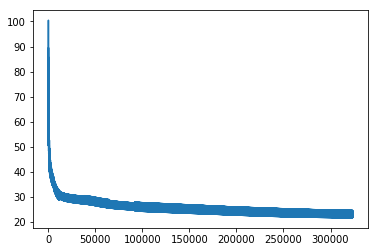

INFO - [871] training...
100%|██████████| 266/266 [00:24<00:00, 10.56it/s]
INFO - [871] training loss:22.600605010986328
INFO - [872] training...
100%|██████████| 266/266 [00:27<00:00, 11.07it/s]
INFO - [872] training loss:22.59918212890625
INFO - [873] training...
100%|██████████| 266/266 [00:24<00:00, 10.86it/s]
INFO - [873] training loss:22.597759246826172
INFO - [874] training...
100%|██████████| 266/266 [00:24<00:00, 10.97it/s]
INFO - [874] training loss:22.596336364746094
INFO - [875] training...
100%|██████████| 266/266 [00:24<00:00, 10.65it/s]
INFO - [875] training loss:22.594919204711914
INFO - [876] training...
100%|██████████| 266/266 [00:25<00:00, 11.11it/s]
INFO - [876] training loss:22.593502044677734
INFO - [877] training...
100%|██████████| 266/266 [00:24<00:00, 11.09it/s]
INFO - [877] training loss:22.592084884643555
INFO - [878] training...
100%|██████████| 266/266 [00:24<00:00, 11.76it/s]
INFO - [878] training loss:22.590675354003906
INFO - [879] training...
100%|███

100%|██████████| 15/15 [00:00<00:00, 202.06it/s]INFO - [880] test loss:23.151620864868164

100%|██████████| 22/22 [00:00<00:00, 194.92it/s]INFO - [880] test loss:22.887727737426758

100%|██████████| 14/14 [00:00<00:00, 208.70it/s]INFO - [880] test loss:22.88616371154785

100%|██████████| 19/19 [00:00<00:00, 210.27it/s]INFO - [880] test loss:23.086870193481445

100%|██████████| 23/23 [00:00<00:00, 213.36it/s]INFO - [880] test loss:22.974706649780273

100%|██████████| 15/15 [00:00<00:00, 213.05it/s]INFO - [880] test loss:22.386959075927734

100%|██████████| 16/16 [00:00<00:00, 210.16it/s]INFO - [880] test loss:22.694534301757812

100%|██████████| 16/16 [00:00<00:00, 212.66it/s]INFO - [880] test loss:23.4269962310791

100%|██████████| 18/18 [00:00<00:00, 216.77it/s]INFO - [880] test loss:23.14847183227539

100%|██████████| 18/18 [00:00<00:00, 216.83it/s]INFO - [880] test loss:23.636314392089844

100%|██████████| 16/16 [00:00<00:00, 219.09it/s]INFO - [880] test loss:22.727869033813477

100

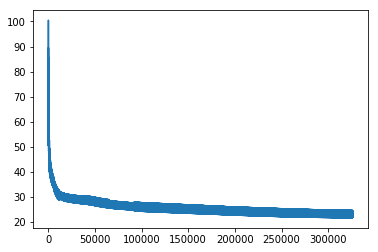

INFO - [881] training...
100%|██████████| 266/266 [00:25<00:00, 10.62it/s]
INFO - [881] training loss:22.58645248413086
INFO - [882] training...
100%|██████████| 266/266 [00:25<00:00, 11.40it/s]
INFO - [882] training loss:22.585046768188477
INFO - [883] training...
100%|██████████| 266/266 [00:24<00:00, 10.73it/s]
INFO - [883] training loss:22.583646774291992
INFO - [884] training...
100%|██████████| 266/266 [00:25<00:00, 10.66it/s]
INFO - [884] training loss:22.58224868774414
INFO - [885] training...
100%|██████████| 266/266 [00:25<00:00, 10.70it/s]
INFO - [885] training loss:22.580848693847656
INFO - [886] training...
100%|██████████| 266/266 [00:24<00:00,  9.41it/s]
INFO - [886] training loss:22.579456329345703
INFO - [887] training...
100%|██████████| 266/266 [00:25<00:00, 10.92it/s]
INFO - [887] training loss:22.57806396484375
INFO - [888] training...
100%|██████████| 266/266 [00:25<00:00, 10.64it/s]
INFO - [888] training loss:22.576675415039062
INFO - [889] training...
100%|█████

100%|██████████| 16/16 [00:00<00:00, 205.53it/s]INFO - [890] test loss:23.113231658935547

100%|██████████| 14/14 [00:00<00:00, 208.08it/s]INFO - [890] test loss:22.10586166381836

100%|██████████| 22/22 [00:00<00:00, 211.49it/s]
INFO - [890] test loss:22.870527267456055
100%|██████████| 15/15 [00:00<00:00, 213.97it/s]INFO - [890] test loss:22.685874938964844

100%|██████████| 15/15 [00:00<00:00, 210.02it/s]INFO - [890] test loss:22.4542179107666

100%|██████████| 14/14 [00:00<00:00, 189.19it/s]INFO - [890] test loss:22.73748016357422

100%|██████████| 15/15 [00:00<00:00, 213.68it/s]INFO - [890] test loss:22.709739685058594

100%|██████████| 15/15 [00:00<00:00, 189.67it/s]INFO - [890] test loss:22.07746696472168

100%|██████████| 14/14 [00:00<00:00, 216.67it/s]INFO - [890] test loss:21.756616592407227

100%|██████████| 15/15 [00:00<00:00, 215.52it/s]INFO - [890] test loss:22.696382522583008

100%|██████████| 16/16 [00:00<00:00, 217.87it/s]INFO - [890] test loss:23.37491798400879

100%|

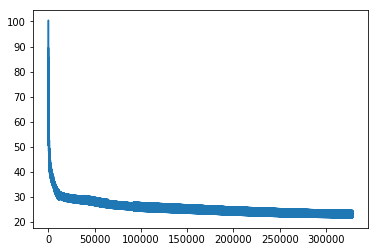

INFO - [891] training...
100%|██████████| 266/266 [00:24<00:00, 10.81it/s]
INFO - [891] training loss:22.5725154876709
INFO - [892] training...
100%|██████████| 266/266 [00:25<00:00, 10.97it/s]
INFO - [892] training loss:22.571134567260742
INFO - [893] training...
100%|██████████| 266/266 [00:24<00:00, 10.66it/s]
INFO - [893] training loss:22.569751739501953
INFO - [894] training...
100%|██████████| 266/266 [00:25<00:00, 10.52it/s]
INFO - [894] training loss:22.568378448486328
INFO - [895] training...
100%|██████████| 266/266 [00:25<00:00,  6.59it/s]
INFO - [895] training loss:22.567001342773438
INFO - [896] training...
100%|██████████| 266/266 [00:25<00:00, 10.34it/s]
INFO - [896] training loss:22.565628051757812
INFO - [897] training...
100%|██████████| 266/266 [00:25<00:00, 10.39it/s]
INFO - [897] training loss:22.564258575439453
INFO - [898] training...
100%|██████████| 266/266 [00:25<00:00, 10.39it/s]
INFO - [898] training loss:22.56288719177246
INFO - [899] training...
100%|█████


100%|██████████| 14/14 [00:00<00:00, 182.65it/s]INFO - [900] test loss:22.092453002929688

100%|██████████| 15/15 [00:00<00:00, 221.00it/s]INFO - [900] test loss:22.67303466796875

100%|██████████| 15/15 [00:00<00:00, 214.47it/s]INFO - [900] test loss:22.439411163330078

100%|██████████| 14/14 [00:00<00:00, 211.21it/s]INFO - [900] test loss:22.721416473388672

100%|██████████| 15/15 [00:00<00:00, 202.80it/s]INFO - [900] test loss:22.69377326965332

100%|██████████| 15/15 [00:00<00:00, 210.38it/s]INFO - [900] test loss:22.065631866455078

100%|██████████| 14/14 [00:00<00:00, 184.01it/s]INFO - [900] test loss:21.742727279663086

100%|██████████| 15/15 [00:00<00:00, 186.91it/s]INFO - [900] test loss:22.68177604675293

100%|██████████| 16/16 [00:00<00:00, 211.17it/s]INFO - [900] test loss:23.36027717590332

100%|██████████| 16/16 [00:00<00:00, 194.81it/s]INFO - [900] test loss:22.06141471862793

100%|██████████| 16/16 [00:00<00:00, 205.31it/s]INFO - [900] test loss:23.063396453857422

100

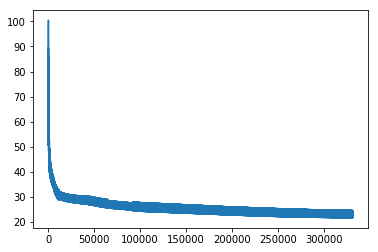

INFO - [901] training...
100%|██████████| 266/266 [00:25<00:00, 10.34it/s]
INFO - [901] training loss:22.558794021606445
INFO - [902] training...
100%|██████████| 266/266 [00:26<00:00, 10.16it/s]
INFO - [902] training loss:22.55743408203125
INFO - [903] training...
100%|██████████| 266/266 [00:25<00:00, 10.66it/s]
INFO - [903] training loss:22.556074142456055
INFO - [904] training...
100%|██████████| 266/266 [00:26<00:00, 10.31it/s]
INFO - [904] training loss:22.554716110229492
INFO - [905] training...
100%|██████████| 266/266 [00:26<00:00, 10.08it/s]
INFO - [905] training loss:22.553363800048828
INFO - [906] training...
100%|██████████| 266/266 [00:25<00:00, 10.38it/s]
INFO - [906] training loss:22.552013397216797
INFO - [907] training...
100%|██████████| 266/266 [00:25<00:00,  9.34it/s]
INFO - [907] training loss:22.5506649017334
INFO - [908] training...
100%|██████████| 266/266 [00:26<00:00,  9.30it/s]
INFO - [908] training loss:22.549318313598633
INFO - [909] training...
100%|█████

100%|██████████| 14/14 [00:00<00:00, 215.40it/s]INFO - [910] test loss:22.07930564880371

100%|██████████| 22/22 [00:00<00:00, 218.25it/s]
INFO - [910] test loss:22.83772087097168
100%|██████████| 15/15 [00:00<00:00, 215.67it/s]INFO - [910] test loss:22.660472869873047

100%|██████████| 15/15 [00:00<00:00, 197.48it/s]INFO - [910] test loss:22.42491912841797

100%|██████████| 14/14 [00:00<00:00, 205.89it/s]INFO - [910] test loss:22.705541610717773

100%|██████████| 15/15 [00:00<00:00, 218.17it/s]INFO - [910] test loss:22.678071975708008

100%|██████████| 15/15 [00:00<00:00, 216.24it/s]INFO - [910] test loss:22.054035186767578

100%|██████████| 14/14 [00:00<00:00, 218.26it/s]INFO - [910] test loss:21.729122161865234

100%|██████████| 15/15 [00:00<00:00, 207.13it/s]INFO - [910] test loss:22.667360305786133

100%|██████████| 16/16 [00:00<00:00, 198.51it/s]INFO - [910] test loss:23.34585189819336

100%|██████████| 16/16 [00:00<00:00, 215.24it/s]INFO - [910] test loss:22.04775619506836

100%

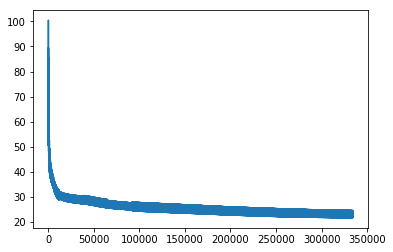

INFO - [911] training...
100%|██████████| 266/266 [00:25<00:00, 10.40it/s]
INFO - [911] training loss:22.545286178588867
INFO - [912] training...
100%|██████████| 266/266 [00:25<00:00, 10.37it/s]
INFO - [912] training loss:22.54395294189453
INFO - [913] training...
100%|██████████| 266/266 [00:26<00:00, 10.69it/s]
INFO - [913] training loss:22.54261589050293
INFO - [914] training...
100%|██████████| 266/266 [00:24<00:00, 10.67it/s]
INFO - [914] training loss:22.54128074645996
INFO - [915] training...
100%|██████████| 266/266 [00:25<00:00, 10.25it/s]
INFO - [915] training loss:22.539947509765625
INFO - [916] training...
100%|██████████| 266/266 [00:25<00:00, 10.71it/s]
INFO - [916] training loss:22.538616180419922
INFO - [917] training...
100%|██████████| 266/266 [00:25<00:00, 10.31it/s]
INFO - [917] training loss:22.53728675842285
INFO - [918] training...
100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
INFO - [918] training loss:22.535961151123047
INFO - [919] training...
100%|██████

100%|██████████| 16/16 [00:00<00:00, 212.30it/s]INFO - [920] test loss:23.066387176513672

100%|██████████| 14/14 [00:00<00:00, 210.15it/s]INFO - [920] test loss:22.0664005279541

100%|██████████| 15/15 [00:00<00:00, 201.54it/s]INFO - [920] test loss:22.648181915283203

100%|██████████| 15/15 [00:00<00:00, 216.11it/s]INFO - [920] test loss:22.410737991333008

100%|██████████| 14/14 [00:00<00:00, 111.24it/s]INFO - [920] test loss:22.689855575561523

100%|██████████| 15/15 [00:00<00:00, 173.51it/s]INFO - [920] test loss:22.662647247314453

100%|██████████| 15/15 [00:00<00:00, 208.13it/s]INFO - [920] test loss:22.042665481567383

100%|██████████| 14/14 [00:00<00:00, 217.00it/s]INFO - [920] test loss:21.715795516967773

100%|██████████| 15/15 [00:00<00:00, 212.86it/s]INFO - [920] test loss:22.653146743774414

100%|██████████| 16/16 [00:00<00:00, 156.46it/s]
INFO - [920] test loss:23.331647872924805

100%|██████████| 16/16 [00:00<00:00, 164.51it/s]INFO - [920] test loss:22.034334182739258



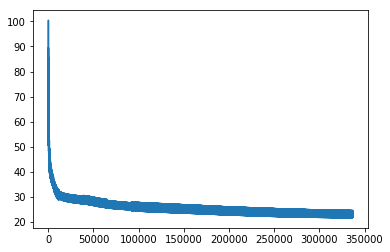

INFO - [921] training...
100%|██████████| 266/266 [00:24<00:00, 10.44it/s]
INFO - [921] training loss:22.531999588012695
INFO - [922] training...
100%|██████████| 266/266 [00:24<00:00, 10.67it/s]
INFO - [922] training loss:22.530683517456055
INFO - [923] training...
100%|██████████| 266/266 [00:25<00:00, 10.71it/s]
INFO - [923] training loss:22.529367446899414
INFO - [924] training...
100%|██████████| 266/266 [00:25<00:00, 10.28it/s]
INFO - [924] training loss:22.52805519104004
INFO - [925] training...
 54%|█████▍    | 143/266 [00:12<00:11, 11.04it/s]

In [ ]:
from torch import optim
op = optim.SGD(gen.parameters(), lr=0.0001, momentum=0.1)
from tqdm import tqdm
crit = nn.NLLLoss()
sample_ids = _samples_ids

import random
random.shuffle(sample_ids)

sample_size = len(sample_ids)
ratio = 0.8
pivot = int(ratio * sample_size)
trainset, testset = sample_ids[:pivot], sample_ids[pivot:]

print_every = 10
gen.train()
#train_losses = []
batch_size = 128
log.setLevel(logging.INFO)
gen.cuda()
for epoch in range(10000):
    log.info('[{}] training...'.format(epoch))
    for i in _tqdm(range(len(trainset)//batch_size)):
        #log.debug('  ==== batch {}'.format(i))
        samples = trainset[batch_size * i:batch_size * (i+1)]
        if not samples:
            continue
        samples = batch_op(samples)
        op.zero_grad()
        hidden = gen.init_hidden(batch_size).cuda()
        loss = 0
        #log.debug('\n  == samples {}'.format(pformat(samples)))
        for j in range(len(samples[0]) - 1):
            #log.debug('  index-j:{}'.format(j))
            #log.debug('  len(samples[0])-1: {}'.format(len(samples[0]) - 1))            
            log.setLevel(logging.INFO)

            cat = [sample[j][0] for sample in samples]
            char = [sample[j][1] for sample in samples]
            target = [sample[j+1][1] for sample in samples]
            cat = torch.LongTensor(cat).cuda()
            char = torch.LongTensor(char).cuda()
            target = torch.LongTensor(target).cuda()
            log.debug('\ncat: {}\n char: {}, \ntarget: {}'.format(cat, char, target))
            cat, char, target = Variable(cat), Variable(char), Variable(target)
            hidden, output = gen(cat, char, hidden)
            loss += crit(output, target)
               
        
        
        train_losses.append(loss.data[0])
        loss.backward()
        op.step()
    log.info('[{}] training loss:{}'.format(epoch, loss.data[0]))
    if epoch % print_every == 0:
        log.info('outputs and targets: {}'.format(pformat(
                [i for i in zip(output.data.max(1)[1].cpu().numpy(), 
                    target.data.cpu().numpy())]
                   )))
        
        log.info('[{}] evaluating...'.format(epoch))
        losses = []
        correct = 0
        #log.debug('  ==== batch {}'.format(i))
        for i in _tqdm(range(len(testset)//batch_size)):
            samples = testset[batch_size * i:batch_size * (i+1)]
            if not samples:
                continue
            samples = batch_op(samples)
            op.zero_grad()
            hidden = gen.init_hidden(batch_size).cuda()
            loss = 0
            #log.debug('\n  == samples {}'.format(pformat(samples)))
            for j in _tqdm(range(len(samples[0]) - 1)):
                #log.debug('  index-j:{}'.format(j))
                #log.debug('  len(samples[0])-1: {}'.format(len(samples[0]) - 1))            
                log.setLevel(logging.INFO)
                cat = [sample[j][0] for sample in samples]
                char = [sample[j][1] for sample in samples]
                target = [sample[j+1][1] for sample in samples]
                cat = torch.LongTensor(cat).cuda()
                char = torch.LongTensor(char).cuda()
                target = torch.LongTensor(target).cuda()
                log.debug('\ncat: {}\n char: {}, \ntarget: {}'.format(cat, char, target))
                cat, char, target = Variable(cat), Variable(char), Variable(target)
                hidden, output = gen(cat, char, hidden)
                loss += crit(output, target)
                if output.data.max(1)[1].cpu().numpy()[0] == target.data[0]:
                    correct += 1
            log.info('[{}] test loss:{}'.format(epoch, loss.data[0]))
            losses.append(loss.data[0]/len(samples))
        if len(losses):
            log.info('[{}] loss: {}; accuracy:{}'.format(epoch, sum(losses)/len(losses), correct/len(testset)))
        plt.plot(train_losses)
        plt.show()

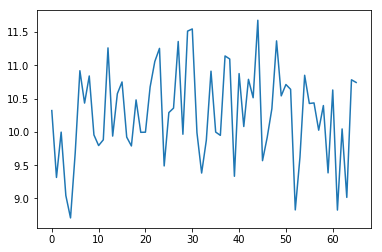

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses)

In [75]:
max_length = 20

# Sample from a category and starting letter
def Sample(category, start_letter='A'):
    category_tensor = Variable(torch.LongTensor([categories.index(category)]))
    input = Variable(torch.LongTensor([letters.index(start_letter)]))
    hidden = gen.init_hidden()

    output_name = start_letter

    for i in range(max_length):
        hidden, output = gen(category_tensor, input, hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == len(letters) - 1:
            break
        else:
            letter = letters[topi]
            output_name += letter
        input = Variable(torch.LongTensor([letters.index(letter)]))

    return output_name

# Get multiple samples from one category and multiple starting letters
def Samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [86]:
gen.cpu()
Samples('boy', 'அஅஇஎக')

அ்க்
அ்க்
இ்க்
எ்
க்க்


In [ ]:
[x for x in gen.inp_embedding.parameters()]